In [1]:
# This is used to read fits files 
from astropy.io import fits

# Useful for a bunch of stuff
import numpy as np

# Used for Log plots
from matplotlib.colors import LogNorm

# Used to draw ellipses
from matplotlib.patches import Ellipse

# Prettier plots
import seaborn as sns

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_formats = ('png', 'retina')

# Used for median filter to handle noise
from scipy import ndimage

# Used to regrid data
from scipy.interpolate import griddata

In [2]:
def extract_FITS(filename):
    '''
       Extracts the data cube from the FITS file.
       
       Arguments: 
           filename : name of the file including path
           
       Return variables:
           hdu_list : hdu_list[0].data contains the data cube array in order of wavelength, y, x
           Min      : the starting wavelength value in the cube in Angstroms
           Max      : the ending wavelength value in the cube in Angstroms
           Step     : the step size of the wavelength
           xlen     : the size of the horizontal axis of FOV in arcseconds
           ylen     : the size of the horizontal axis of FOV in arcseconds
    '''
    
    hdu_list = fits.open(filename)
    image, header = fits.getdata(filename, header=True)
    Min = header['CRVAL3']
    step = header['CD3_3']
    Max = Min +  (np.shape(image)[0] - 1) * step
    ypixel = len(hdu_list[0].data[0])
    xpixel = len(hdu_list[0].data[0][0])
    xlen = (header['CD1_1']**2 + header['CD2_1']**2)**(0.5) * xpixel * 3600
    ylen = (header['CD1_2']**2 + header['CD2_2']**2)**(0.5) * ypixel * 3600
    return hdu_list, Min, Max, step, xlen, ylen

def wave2pix(wave, color):
    '''
       Converts a given wavelength value into the corresponding pixel of the specified cube.
       
       Arguments:
           wave     : the wavelength value 
           color    : blue, green, or red
        
       Return variables: 
           pixel    : the pixel value 
    '''
    
    if color == "blue":
        return int((wave - Min_blue) / step_blue)
            
    if color == "green":
        return int((wave - Min_green) / step_green)
            
    if color == "red":
        return int((wave - Min_red) / step_red)
    
def plot_hist(sum_img, hist_range=0):
    '''
       Displays a histogram of a summed image. Useful for deciding the colorbar. 
       
       Arguments:
           sum_img      : the summed image  
           hist_range   : (optional) specify a particular range for the x-axis
        
       Return variables: 
           none
    '''
    
    plt.figure(figsize=(9,4))
    if hist_range: 
        plt.hist(sum_img.flatten(), 100, range=hist_range)
    else:
        plt.hist(sum_img.flatten(), 100)
    plt.show()

def make_vx(hdu_list):
    '''
       Manipulates the cube by summing all the y pixels to obtain a 2D array of wavelength vs x.
       
       Arguments:
           hdu_list   : hdu_list[0].data contains the data cube array in order of wavelength, y, x  
        
       Return variables: 
           sum_ylst   : 2D array of wavelength vs x
    '''
    
    # Transposing to make the data format easier to sum 
    t_hdu_list = np.transpose(hdu_list[0].data, (0, 2, 1))
    
    sum_ylst = np.zeros((len(t_hdu_list), len(t_hdu_list[0])))
    for i in range(len(t_hdu_list)):                    # i = wavelength
        for j in range(len(t_hdu_list[0])):             # j = x
            sum_ylst[i][j] = np.sum(t_hdu_list[i][j])
    return sum_ylst


def plot_vx(sum_ylst, minpix, maxpix, asp, tick, color):
    '''
       Plots the sum_ylst 2D array. 
       
       Arguments:
           sum_ylst : 2D array of wavelength vs x
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           asp      : aspect ratio
           tick     : tuple of (min, max, step) for wavelength axis label
           color    : blue, green, or red
        
       Return variables: 
           none
    '''
    
    if color == "blue":
        Min = Min_blue
        Max = Max_blue
        
    if color == "green":
        Min = Min_green
        Max = Max_green
            
    if color == "red":
        Min = Min_red
        Max = Max_red
    
    plt.imshow(sum_ylst, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen,  Min, Max], aspect=asp, origin='upper')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, xlen, 2));
    ax.set_yticks(np.arange(tick[0], tick[1], tick[2]));
    plt.xlabel('x (\u2033)');
    plt.ylabel('Wavelength (\u212b)');

    
def plot_vx_slice(center, low, high, minpix, maxpix, tick, color, med_filter=3, asp=False):
    '''
       Plots a slice of the sum_ylst 2D array for a specific line and labels
       the wavelength axis in terms of velocity.
       The return variables are used for regridding.
       
       Arguments:
           center      : line center wavelength
           low         : line lowest wavelength 
           high        : line highest wavelength
           minpix      : the min value of the colorbar 
           maxpix      : the max value of the colorbar
           tick        : tuple of (min, max, step) for velocity axis label
           color       : blue, green, or red
           med_filter  : (optional) strength parameter for the median filter
           asp         : (optional) aspect ratio
        
       Return variables: 
           vvals       : 1D array of the velocity axis values
           vx_slice    : a copy of the sliced 2D array 
    '''
    
    # For consistency I set an arbitrary value of 20 for the aspect ratio 
    if not asp:
        asp = 20.0 / (np.abs(tick[0]) + tick[1] - tick[2])
    
    if color == "blue":
        sum_ylst_med = ndimage.median_filter(sum_ylst_blue, med_filter)
        step = step_blue
        
    if color == "green":
        sum_ylst_med = ndimage.median_filter(sum_ylst_green, med_filter)
        step = step_green
            
    if color == "red":
        sum_ylst_med = ndimage.median_filter(sum_ylst_red, med_filter)
        step = step_red
        
    wv_lst = np.arange(low, high+step, step)
    vvals = 299792.458 * ((wv_lst  - center) / center)
                        
    v_low = vvals[0]
    v_high = vvals[-1]
    
    print("v_low = {}, v_high = {}, aspect = {}".format(v_low, v_high, asp))
    
    vx_slice = sum_ylst_med[wave2pix(low, color):wave2pix(high+step, color), :]
    plot_hist(vx_slice)
    
    plt.imshow(vx_slice, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, v_low, v_high], aspect=asp, origin='lower')
    plt.hlines(0, 0, xlen, linestyle='-', linewidth=1, color='white')
    plt.colorbar();
    
    ax = plt.gca()
    ax.set_xticks(np.arange(0, xlen, 1));
    ax.set_yticks(np.arange(tick[0], tick[1], tick[2]));
    plt.xlabel('x (\u2033)');
    plt.ylabel('v (km/s)');
    
    return vvals, np.copy(vx_slice)

def regrid_vx_slice(old_vvals, vx_slice, regrid_method='cubic'):
    '''
       Regrids a given slice of the sum_ylst 2D array with velocity points of multiples of 5. 
       
       Arguments:
           old_vvals     : the original velocity points of the slice
           vx_slice      : the slice of the cube that needs to be regridded
           regrid_method : (optional) 'nearest', 'linear', or 'cubic'
           
       Return variables: 
           new_vvals     : new velocity points after regridding 
           new_vx_slice  : regridded slice of the cube 
    '''
    
    # Rounding 
    grid_low = int(int(old_vvals[0] / 5.0)* 5.0)
    grid_high = int(int(old_vvals[-1] / 5.0) * 5.0)
    new_vvals = np.arange(grid_low, grid_high + 5, 5)
    
    xvals = np.linspace(0, xlen, np.shape(vx_slice)[1])
    
    old_grid_x, old_grid_v = np.meshgrid(xvals, old_vvals)
    new_grid_x, new_grid_v = np.meshgrid(xvals, new_vvals)
    
    x_lst = old_grid_x.flatten()
    v_lst = old_grid_v.flatten()
    f_lst = vx_slice.flatten()
    
    new_vx_slice = griddata((v_lst, x_lst), f_lst, (new_grid_v, new_grid_x), method=regrid_method)    
    
    return new_vvals, new_vx_slice

def plot_new_vx_slice(vx_slice, v_low, v_high, minpix, maxpix, tick, asp=False):
    '''
       Plots the regridded slice of the cube.  
       
       Arguments:
           vx_slice : regridded slice of the cube 
           v_low    : lowest velocity point  
           v_high   : highest velocity point 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           tick     : tuple of (min, max, step) for velocity axis label
           asp      : (optional) aspect ratio of the image 
        
       Return variables: 
           none
    '''
    
    if not asp:
        asp = 20.0 / (np.abs(tick[0]) + tick[1] - tick[2])
        
    plt.imshow(vx_slice, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, v_low, v_high], aspect=asp, origin='lower')
    plt.hlines(0, 0, xlen, linestyle='-', linewidth=1, color='white')
    plt.colorbar();
    
    ax = plt.gca()
    ax.set_xticks(np.arange(0, xlen, 1));
    ax.set_yticks(np.arange(tick[0], tick[1], tick[2]));
    plt.xlabel('x (\u2033)');
    plt.ylabel('v (km/s)');
    
def test_grid_methods(old_vvals, vx_slice, minpix, maxpix, tick, asp=False):
    '''
       Tests the different interpolation methods and compare plots.  
       Returns vvals and vx_slice for the cubic method. 
       
       Arguments:
           old_vvals     : the original velocity points of the slice
           vx_slice      : the slice of the cube that needs to be regridded
           minpix        : the min value of the colorbar 
           maxpix        : the max value of the colorbar
           tick          : tuple of (min, max, step) for velocity axis label
           asp           : (optional) aspect ratio of the image 
        
       Return variables: 
           new_vvals     : new velocity points after regridding 
           new_vx_slice  : regridded slice of the cube 
    '''
    
    plt.figure(figsize=(17, 6))
    for i, grid_method in enumerate(('original','nearest', 'linear', 'cubic')):
        plt.subplot(1, 4, i+1)
        if grid_method == 'original':
            plot_new_vx_slice(vx_slice, old_vvals[0], old_vvals[-1], minpix, maxpix, tick, asp)
        else: 
            new_vvals, new_vx_slice = regrid_vx_slice(old_vvals, vx_slice, grid_method)
            plot_new_vx_slice(new_vx_slice, new_vvals[0], new_vvals[-1], minpix, maxpix, tick, asp)
        plt.title('{}'.format(grid_method))
    plt.tight_layout()
    return new_vvals, new_vx_slice

def match_grids(new_vvals1, new_vx_slice1, new_vvals2, new_vx_slice2):
    '''
       Slices the larger image to match the new grids of the smaller image
       so the two can be used for division. 
       
       Arguments: 
           new_vvals1            : velocity points of first regridded image
           new_vx_slice1         : first regridded image
           new_vvals2            : velocity points of second regridded image
           new_vx_slice2         : second regridded image
           
        Return variables:
           new_vvals1[a:b]       : matched velocity points 
           new_vx_slice1[:,a:b]  : matched first regridded image
           new_vx_slice2[:,c:d]  : matched second regridded image 
    '''
    
    a = 0
    b = len(new_vvals1)
    c = 0
    d = len(new_vvals2)
    
    if np.min(new_vvals1) <= np.min(new_vvals2):
        a, = np.where(new_vvals1==np.min(new_vvals2))[0]
        
    else: 
        c, = np.where(new_vvals2==np.min(new_vvals1))[0]
        
    if np.max(new_vvals1) >= np.max(new_vvals2):
        b, = np.where(new_vvals1==np.max(new_vvals2))[0] + 1
        
    else:
        d, = np.where(new_vvals2==np.max(new_vvals1))[0] + 1
    
    return new_vvals1[a:b], new_vx_slice1[a:b,:], new_vx_slice2[c:d,:]
    
def extract_back(vx_slice, v_low, v_high, minpix, maxpix, tick, size=(8,8), asp=False):
    '''
       Extracts the sky background in a sliced image. The extracted background is shown
       as a white box.
       
       Arguments:
           vx_slice  : regridded slice of the cube  
           v_low     : lowest velocity point  
           v_high    : highest velocity point
           minpix    : the min value of the colorbar 
           maxpix    : the max value of the colorbar
           tick      : tuple of (min, max, step) for velocity axis label
           size      : (optional) the size of the white box (height, width)
           asp       : (optional) aspect ratio of the image 
          
       Return variables: 
           median    : the median value of the sky background
           std       : the standard deviation value of the sky background 
    '''
    
    vx_slicec = np.copy(vx_slice);
    back = [];
    for i in range(size[0]):
        for j in range(size[1]):
            back.append(vx_slice[-i-3][-j-3])
            vx_slicec[-i-3][-j-3] = None
    plot_new_vx_slice(vx_slicec, v_low, v_high, minpix, maxpix, tick, asp)
    median = np.median([i for i in back if i > 0])
    std = np.std(back)
    print("median = {}, std = {}".format(median, std))
    return median, std

def remove_noise(vx_slice, v_low, v_high, minpix, maxpix, tick, num, size=(8,8), asp=False):
    '''
       Removes all pixels that are a specified factor of the standard deviation above the 
       median of the sky background.
       
       Arguments:
           vx_slice  : regridded slice of the cube  
           v_low     : lowest velocity point  
           v_high    : highest velocity point
           minpix    : the min value of the colorbar 
           maxpix    : the max value of the colorbar
           tick      : tuple of (min, max, step) for velocity axis label
           num       : the specified threshold (median + num * std)
           size      : (optional) the size of the white box (height, width)
           asp       : (optional) aspect ratio of the image 
        
       Return variables: 
           vx_slicec : the sliced image with pixels above the threshold removed
    '''
    
    median, std = extract_back(vx_slice, v_low, v_high, minpix, maxpix, tick, size, asp)
    plt.show()
    vx_slicec = np.copy(vx_slice);
    for i in range(len(vx_slice)):
        for j in range(len(vx_slice[0])):
            if vx_slicec[i][j] <= median + num * std:
                vx_slicec[i][j] = None
    plot_new_vx_slice(vx_slicec, v_low, v_high, minpix, maxpix, tick)
    plt.show()
    return vx_slicec

def find_max_flux(vvals, vx_slice, minpix, maxpix, tick, nextMax=False, asp=False):
    '''
       Displays the point of max flux in a given image. 
       
       Arguments:
           vvals         : the velocity points of the image
           vx_slice      : regridded slice of the cube
           minpix        : the min value of the colorbar 
           maxpix        : the max value of the colorbar
           tick          : tuple of (min, max, step) for velocity axis label
           nextMax       : (optional) set True if second largest flux desired
           asp           : (optional) aspect ratio of the image
           
        
       Return variables: 
           none
    '''
    
    xvals = np.linspace(0, xlen, 3*np.shape(vx_slice)[1])
    
    new_vx_slice = np.copy(vx_slice)
    [a],[b] = np.where(new_vx_slice == np.max(new_vx_slice[new_vx_slice==new_vx_slice]))
    
    if nextMax:
        new_vx_slice[a][b] = None
        [a],[b] = np.where(new_vx_slice == np.max(new_vx_slice[new_vx_slice==new_vx_slice]))
        
    max_v = vvals[a];
    max_x = round(xvals[3*b], 4);
    max_flux = round(np.max(new_vx_slice[new_vx_slice==new_vx_slice]), 4)
    
    new_vx_slice[a][b] = None
    
    plot_new_vx_slice(new_vx_slice, vvals[0], vvals[-1], minpix, maxpix, tick, asp)
    plt.figtext(0.5, 0.020, "({} km/s, {}\u2033, {})".format(max_v, max_x, max_flux), size='12', horizontalalignment='center')
    circle1 = Ellipse((xvals[3*b+1], vvals[a]), 0.5, 12, fill=True, lw=3.5, fc='white', ec='black')
    ax = plt.gca()
    ax.add_artist(circle1)

In [3]:
image_blue  = 'surf2018/data/cubes/s_HH32abd-OII3727.fits'
image_green = 'surf2018/data/cubes/s_HH32abd-OIII5007.fits'
image_red   = 'surf2018/data/cubes/s_HH32abd-OI6300.fits'

hdu_list_blue, Min_blue, Max_blue, step_blue, xlen, ylen = extract_FITS(image_blue)
hdu_list_green, Min_green, Max_green, step_green, xlen, ylen = extract_FITS(image_green)
hdu_list_red, Min_red, Max_red, step_red, xlen, ylen = extract_FITS(image_red)

# Update default figure and font size
plt.rcParams["figure.figsize"] = [3, 10]
plt.rcParams.update({'font.size': 10})

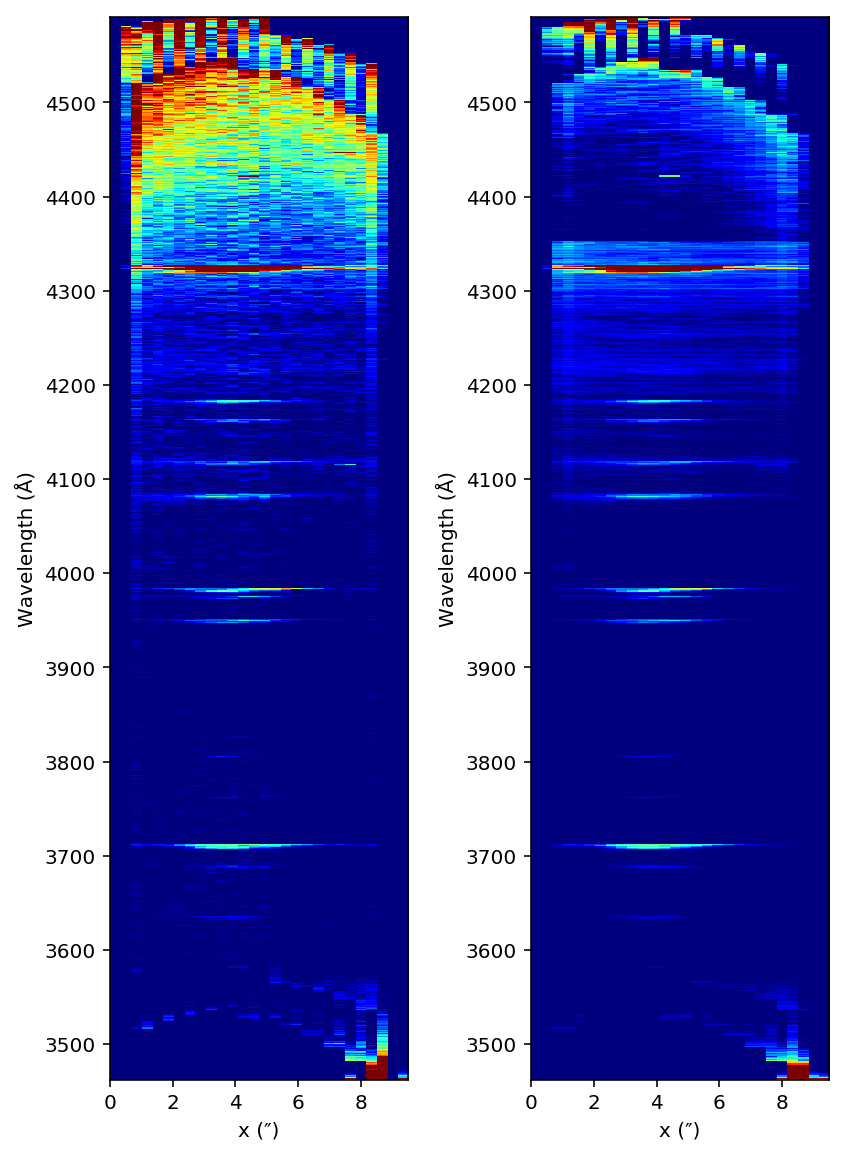

In [4]:
plt.figure(figsize=(6, 20))

plt.subplot(1, 2, 1)
sum_ylst_blue = make_vx(hdu_list_blue)
plot_vx(sum_ylst_blue, 25, 120, 0.03, (3500, 4600, 100), "blue")

sum_ylst_blue_med = ndimage.median_filter(sum_ylst_blue, 3)

# Removing brightness in the beginning 
for i in range(wave2pix(3700, "blue")-wave2pix(Min_blue, "blue")):
    for j in range(28):
        sum_ylst_blue_med[i][0+j] -= np.absolute(np.average(sum_ylst_blue_med[i]))

plt.subplot(1, 2, 2)
plot_vx(sum_ylst_blue_med, 25, 120, 0.03, (3500, 4600, 100), "blue")

plt.tight_layout()

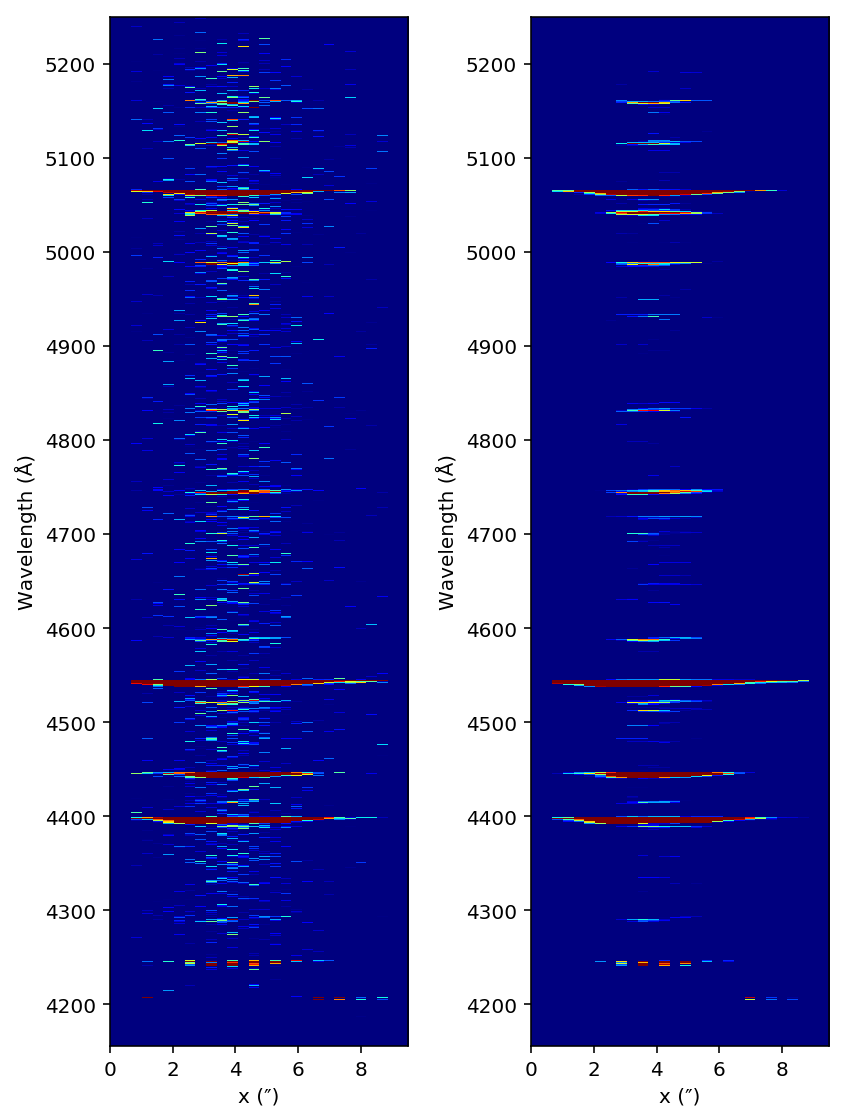

In [5]:
plt.figure(figsize=(6, 20))

plt.subplot(1, 2, 1)
sum_ylst_green = make_vx(hdu_list_green)
plot_vx(sum_ylst_green, 5, 15, 0.03, (4200, 5300, 100), "green")

plt.subplot(1, 2, 2)
sum_ylst_green_med = ndimage.median_filter(sum_ylst_green, 3)
plot_vx(sum_ylst_green_med, 5, 15, 0.03, (4200, 5300, 100), "green")

plt.tight_layout()

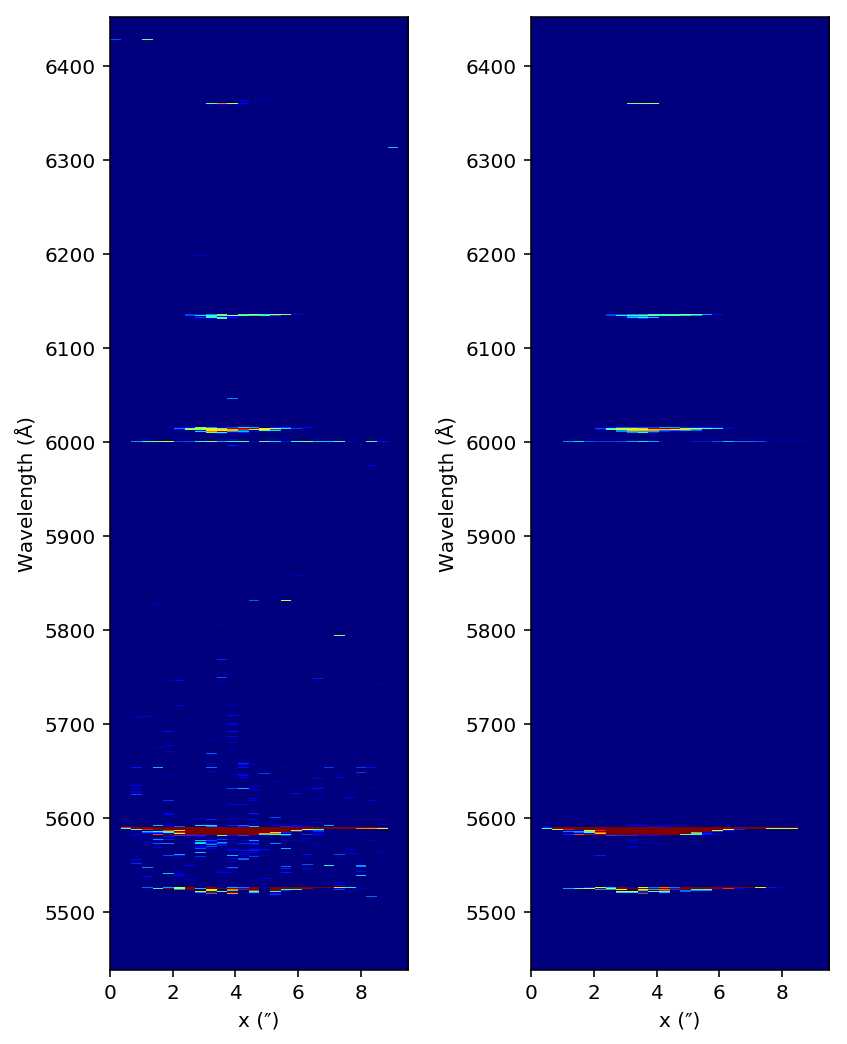

In [6]:
plt.figure(figsize=(6, 20))

plt.subplot(1, 2, 1)
sum_ylst_red = make_vx(hdu_list_red)
plot_vx(sum_ylst_red, 7, 25, 0.03, (5500, 6500, 100), "red")

plt.subplot(1, 2, 2)
sum_ylst_red_med = ndimage.median_filter(sum_ylst_red, 3)
plot_vx(sum_ylst_red_med, 7, 25, 0.03, (5500, 6500, 100), "red")

plt.tight_layout()

In [7]:
plt.rcParams["figure.figsize"] = [6, 8]
plt.rcParams.update({'font.size': 11})

v_low = -66.60231966148731, v_high = 395.9137890988725, aspect = 0.04


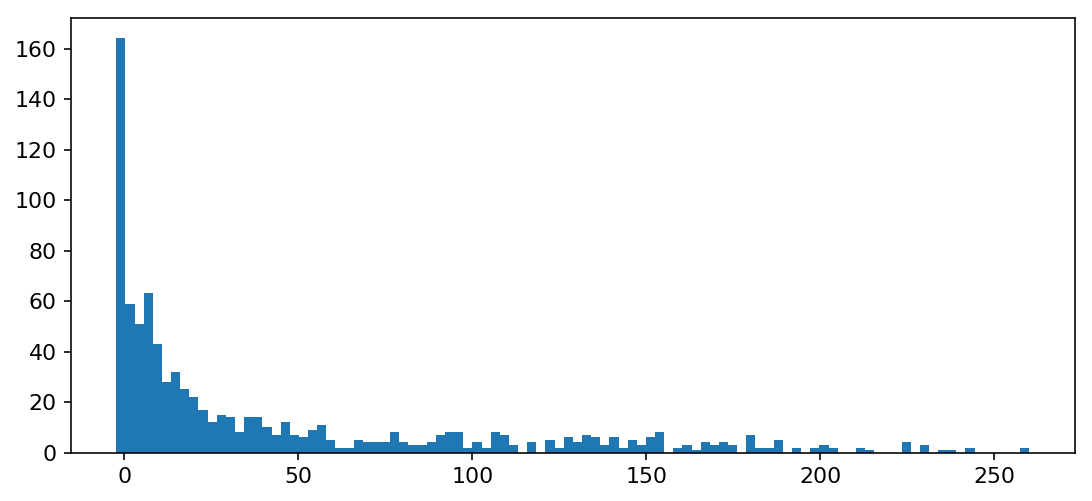

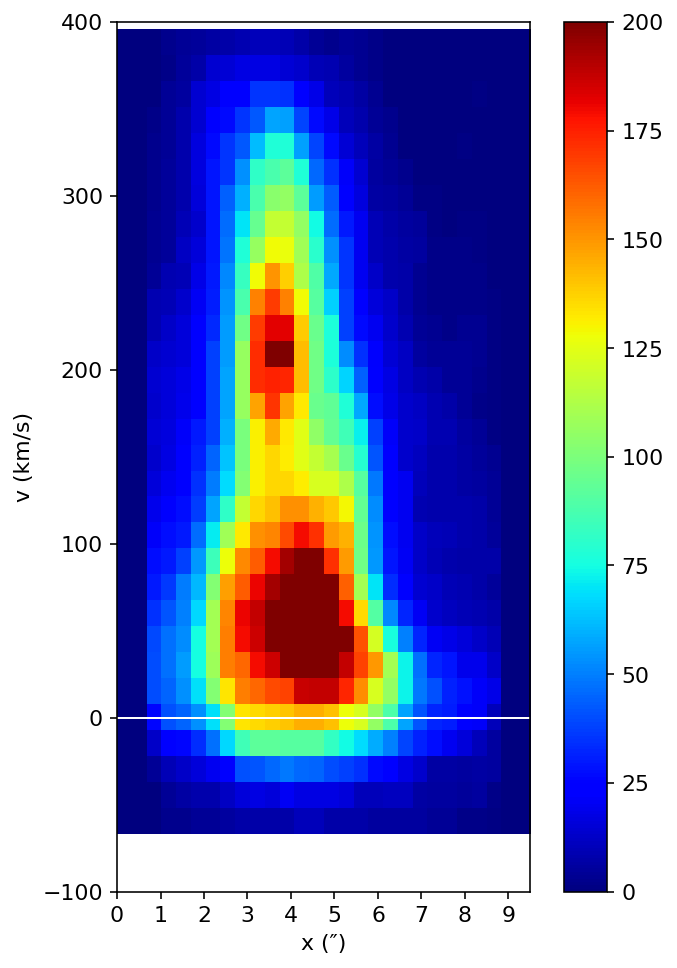

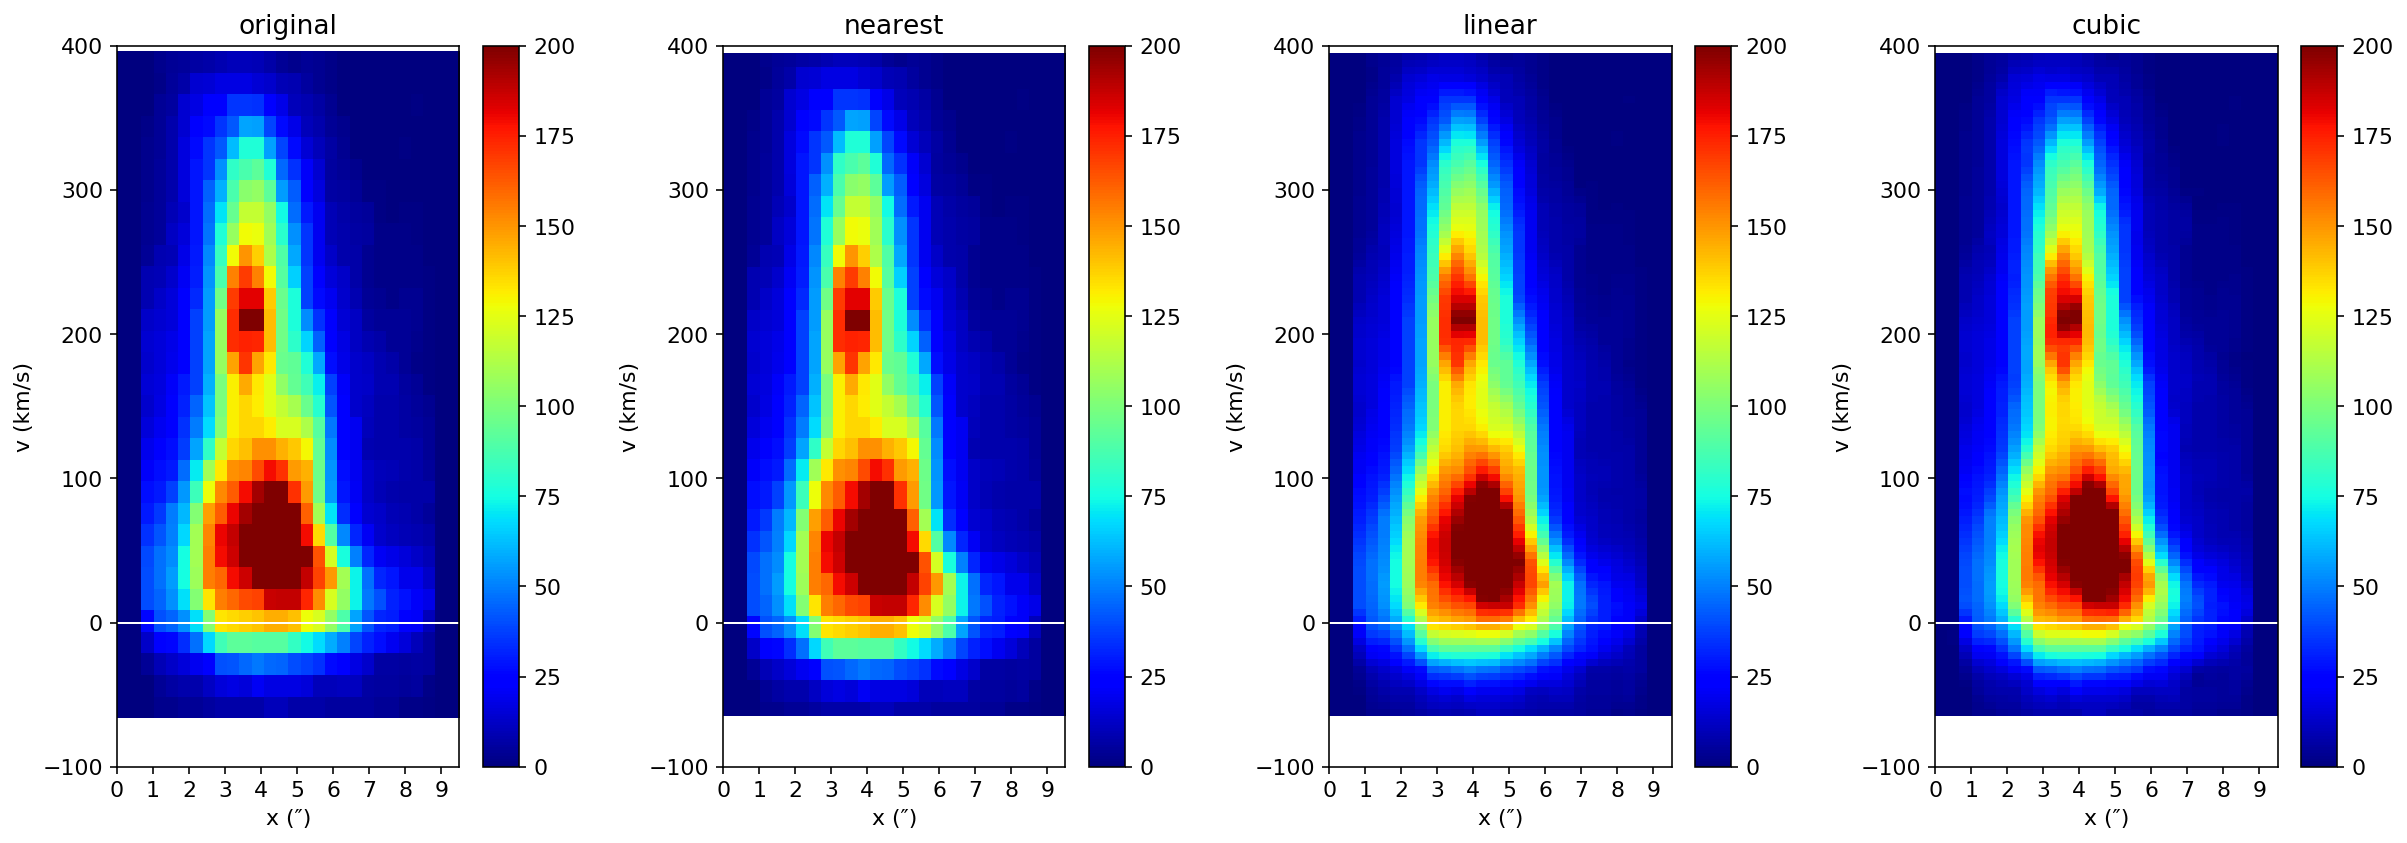

In [8]:
center = 4861.33
low =  4860.25
high = 4867.75
minpix = 0
maxpix = 200
tick = (-100, 500, 100)
color = "green"

hbeta_vvals, hbeta  = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_hbeta_vvals, new_hbeta = test_grid_methods(hbeta_vvals, hbeta, minpix, maxpix, tick)
plt.show()

v_low = -54.085929122746585, v_high = 366.1763579798001, aspect = 0.04


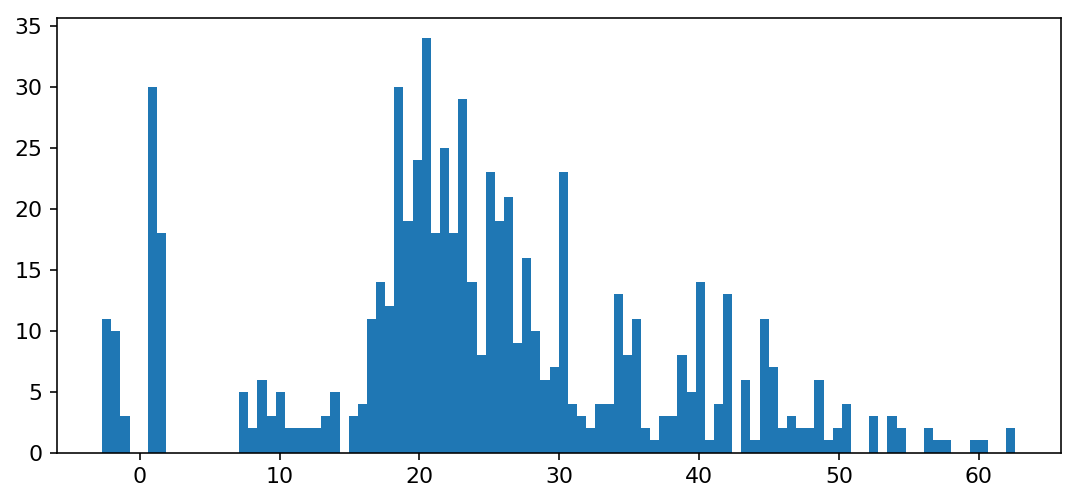

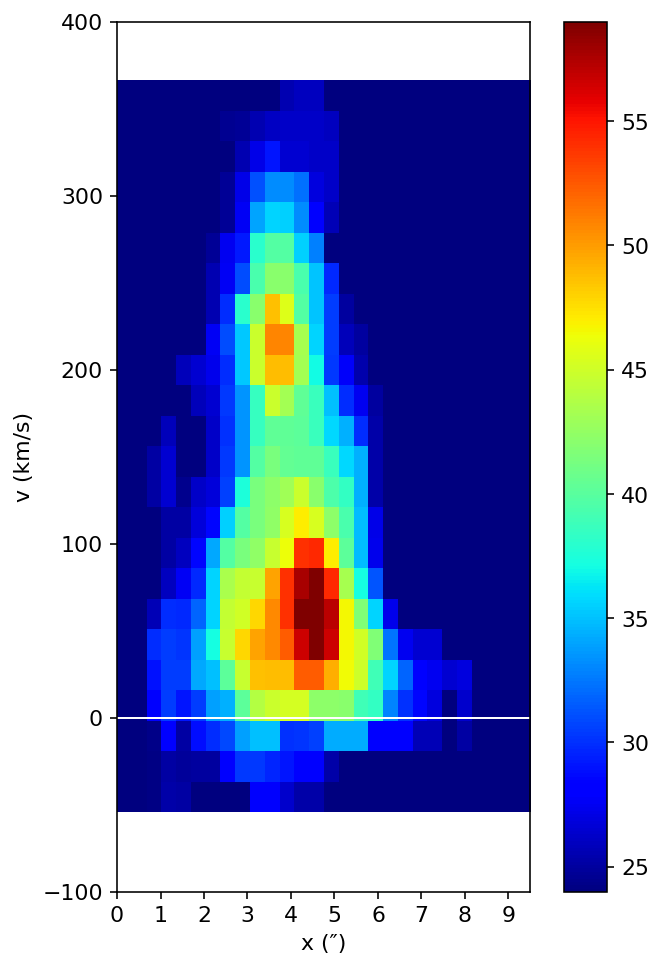

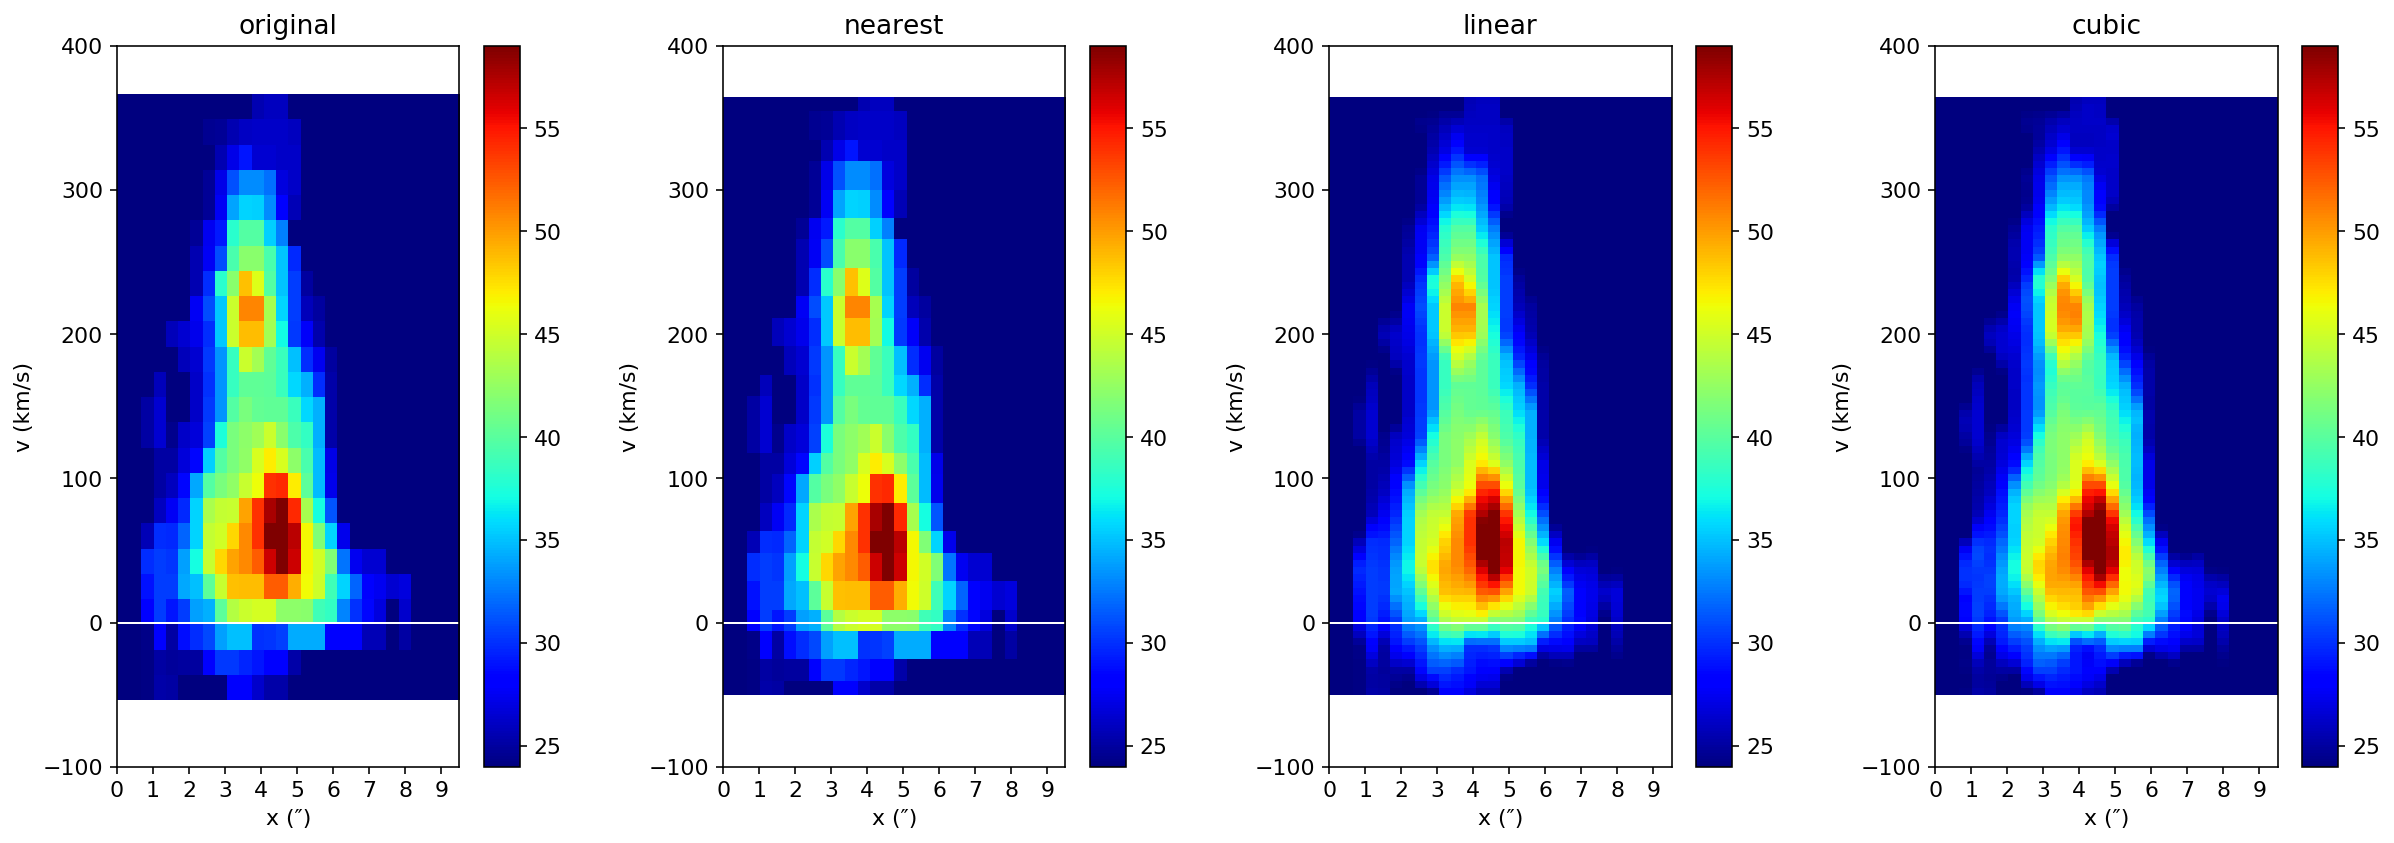

In [9]:
center = 4101.74
low = 4101.00
high = 4106.75
minpix = 24
maxpix = 59
tick = (-100, 500, 100)
color = "blue"

hdelta_vvals, hdelta = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_hdelta_vvals, new_hdelta = test_grid_methods(hdelta_vvals, hdelta, minpix, maxpix, tick)
plt.show()

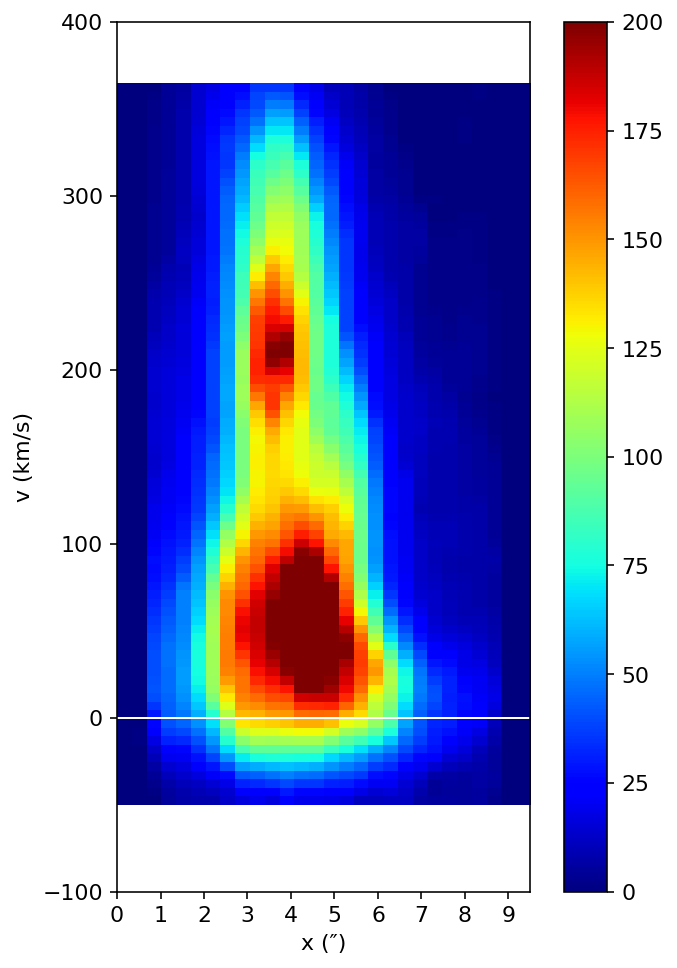

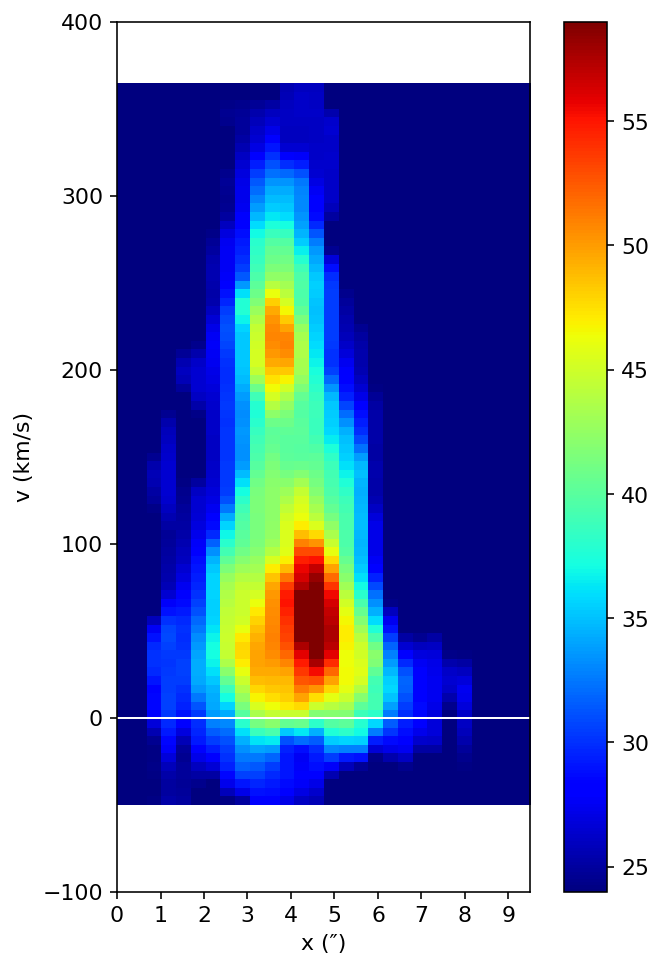

In [10]:
m_vvals, m_hbeta , m_hdelta = match_grids(new_hbeta_vvals, new_hbeta, new_hdelta_vvals, new_hdelta)

minpix = 0
maxpix = 200
tick = (-100, 500, 100)

plot_new_vx_slice(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 24
maxpix = 59
tick = (-100, 500, 100)

plot_new_vx_slice(m_hdelta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

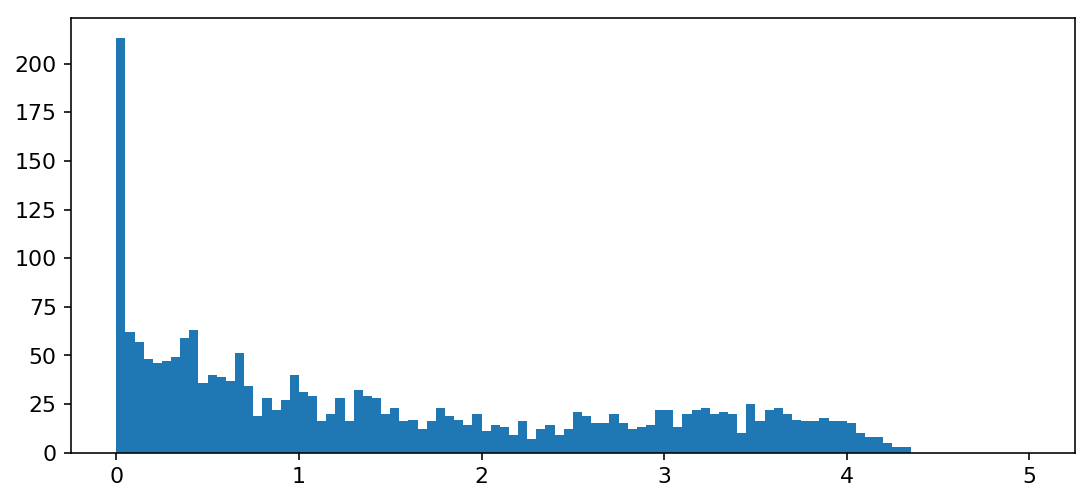

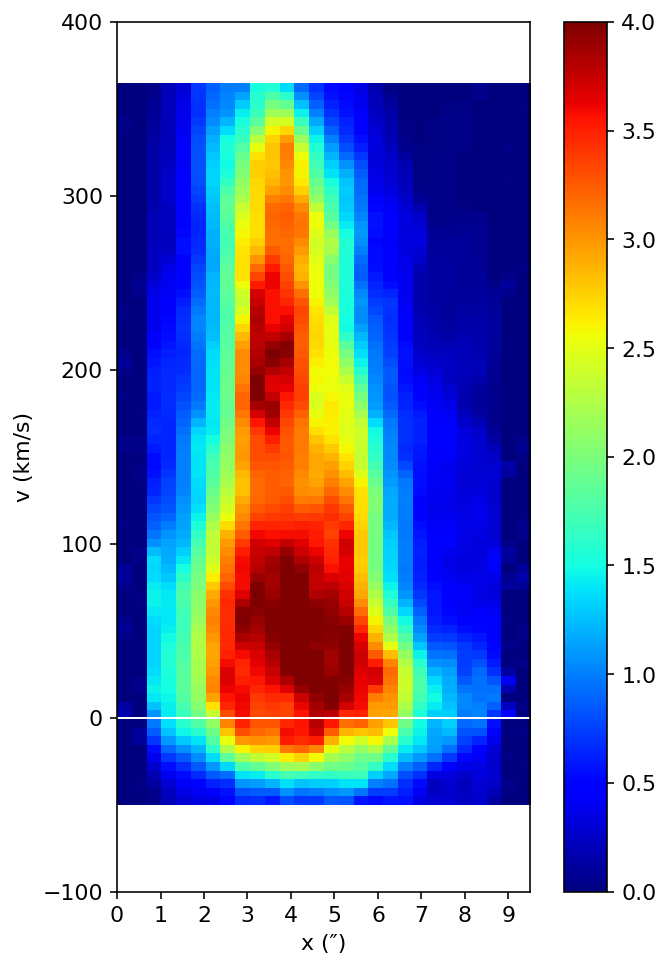

In [11]:
minpix = 0
maxpix = 4
tick = (-100, 500, 100)

hbeta_hdelta = m_hbeta / m_hdelta

plot_hist(hbeta_hdelta[hbeta_hdelta == hbeta_hdelta], [0, 5])
plt.show() 
        
plot_new_vx_slice(hbeta_hdelta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 0.5145025576543412, std = 1.2464437035922802


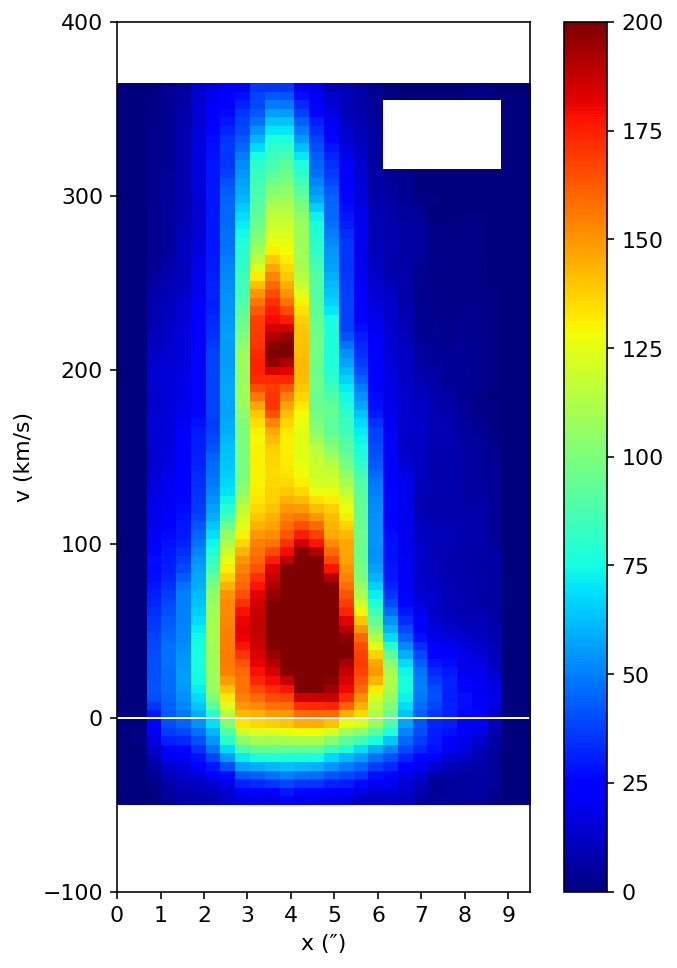

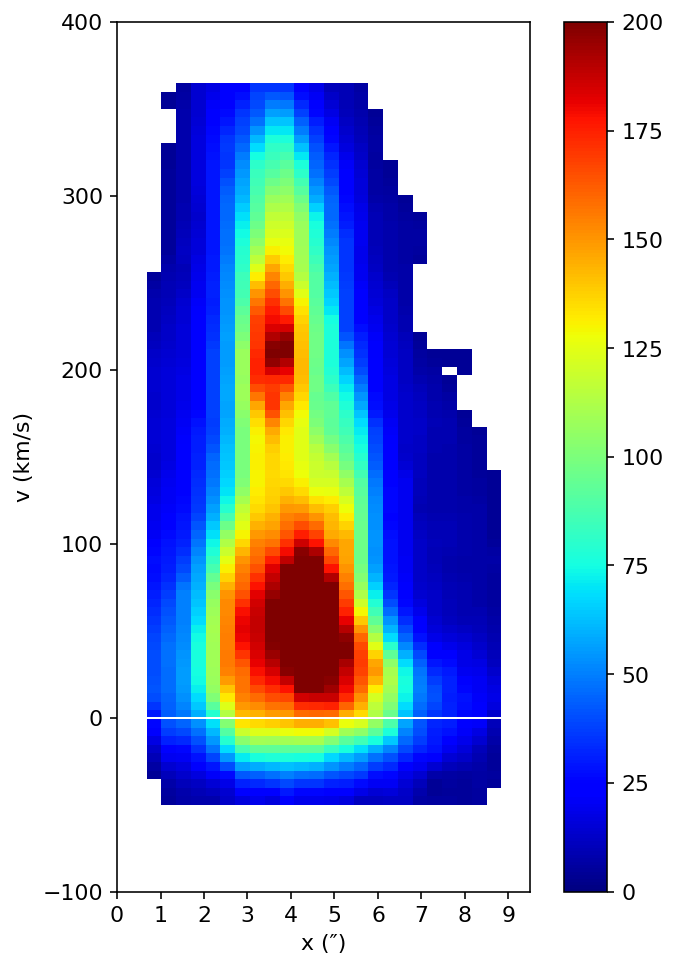

median = 17.289979507818593, std = 2.3846944534943


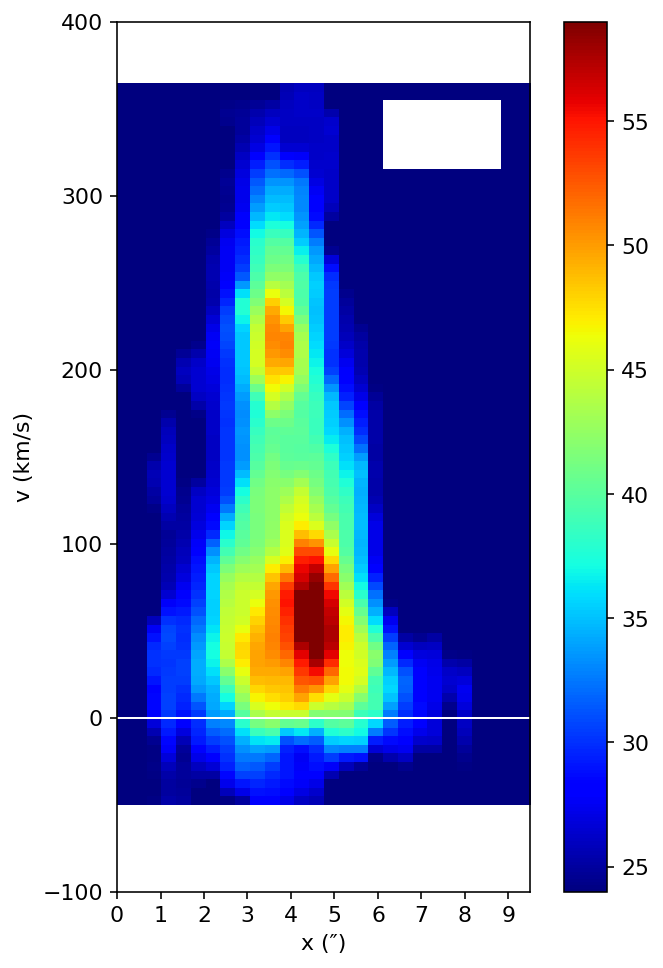

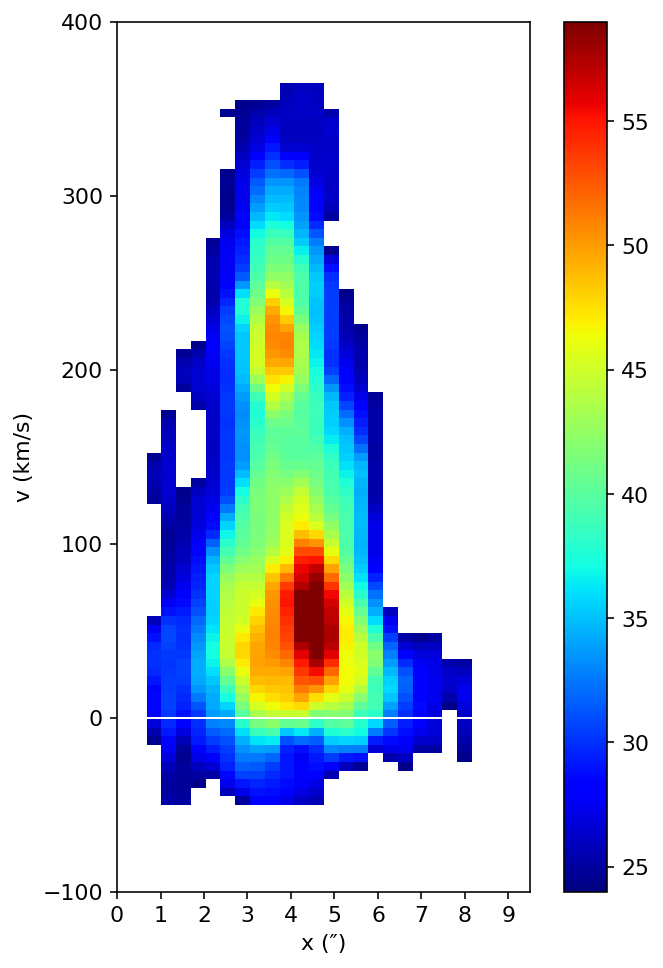

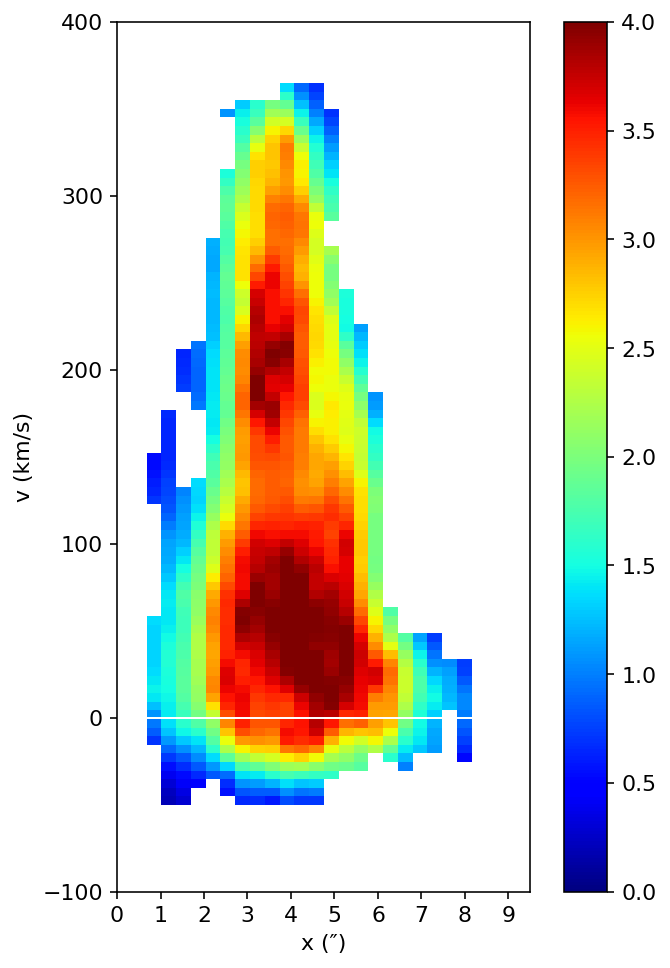

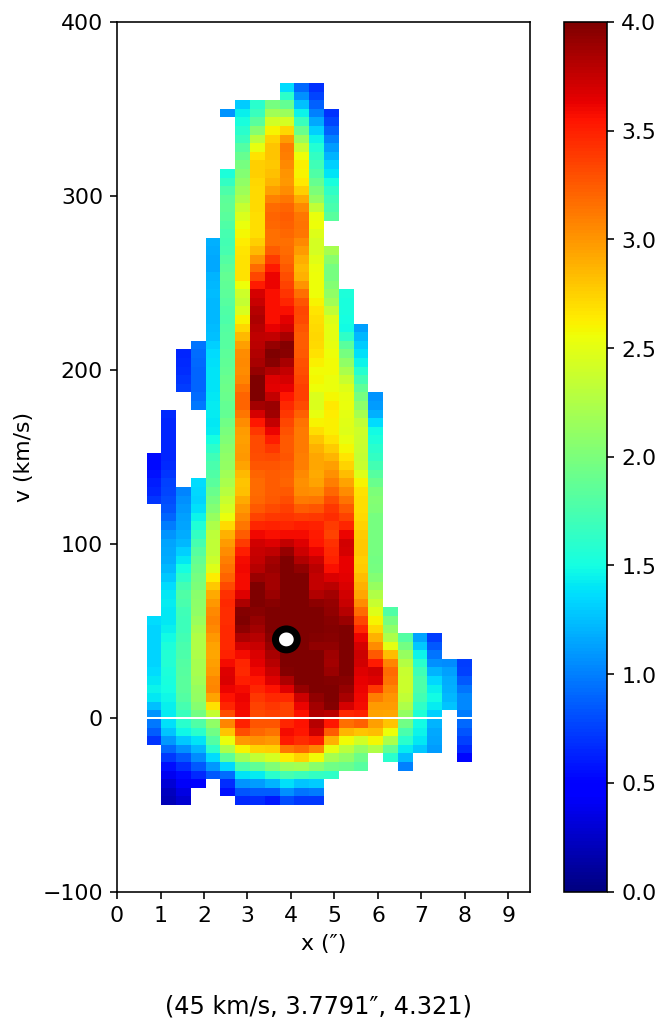

In [12]:
minpix = 0
maxpix = 200
tick = (-100, 500, 100)
m_hbetac = remove_noise(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 24
maxpix = 59
tick = (-100, 500, 100)
m_hdeltac = remove_noise(m_hdelta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)


hbeta_hdeltac = m_hbetac / m_hdeltac

minpix = 0
maxpix = 4
tick = (-100, 500, 100)
plot_new_vx_slice(hbeta_hdeltac, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, hbeta_hdeltac, minpix, maxpix, tick)

v_low = -84.26433053565081, v_high = 416.4868140408581, aspect = 0.03333333333333333


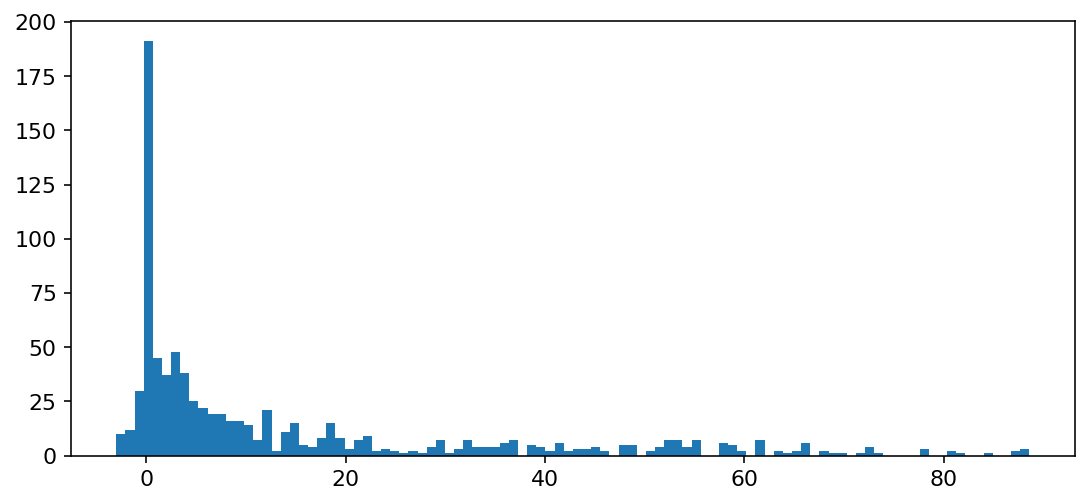

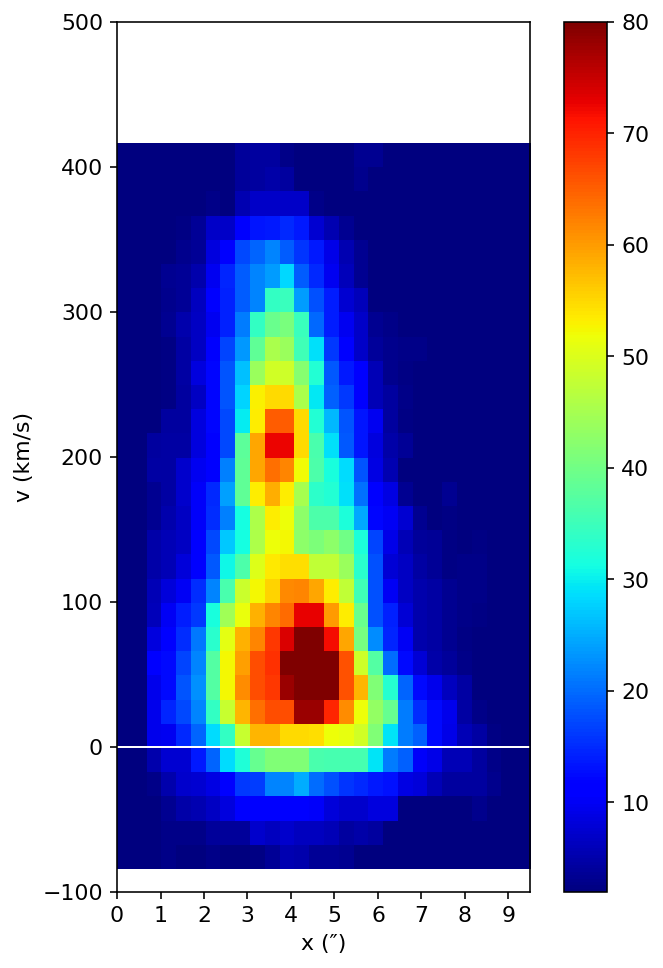

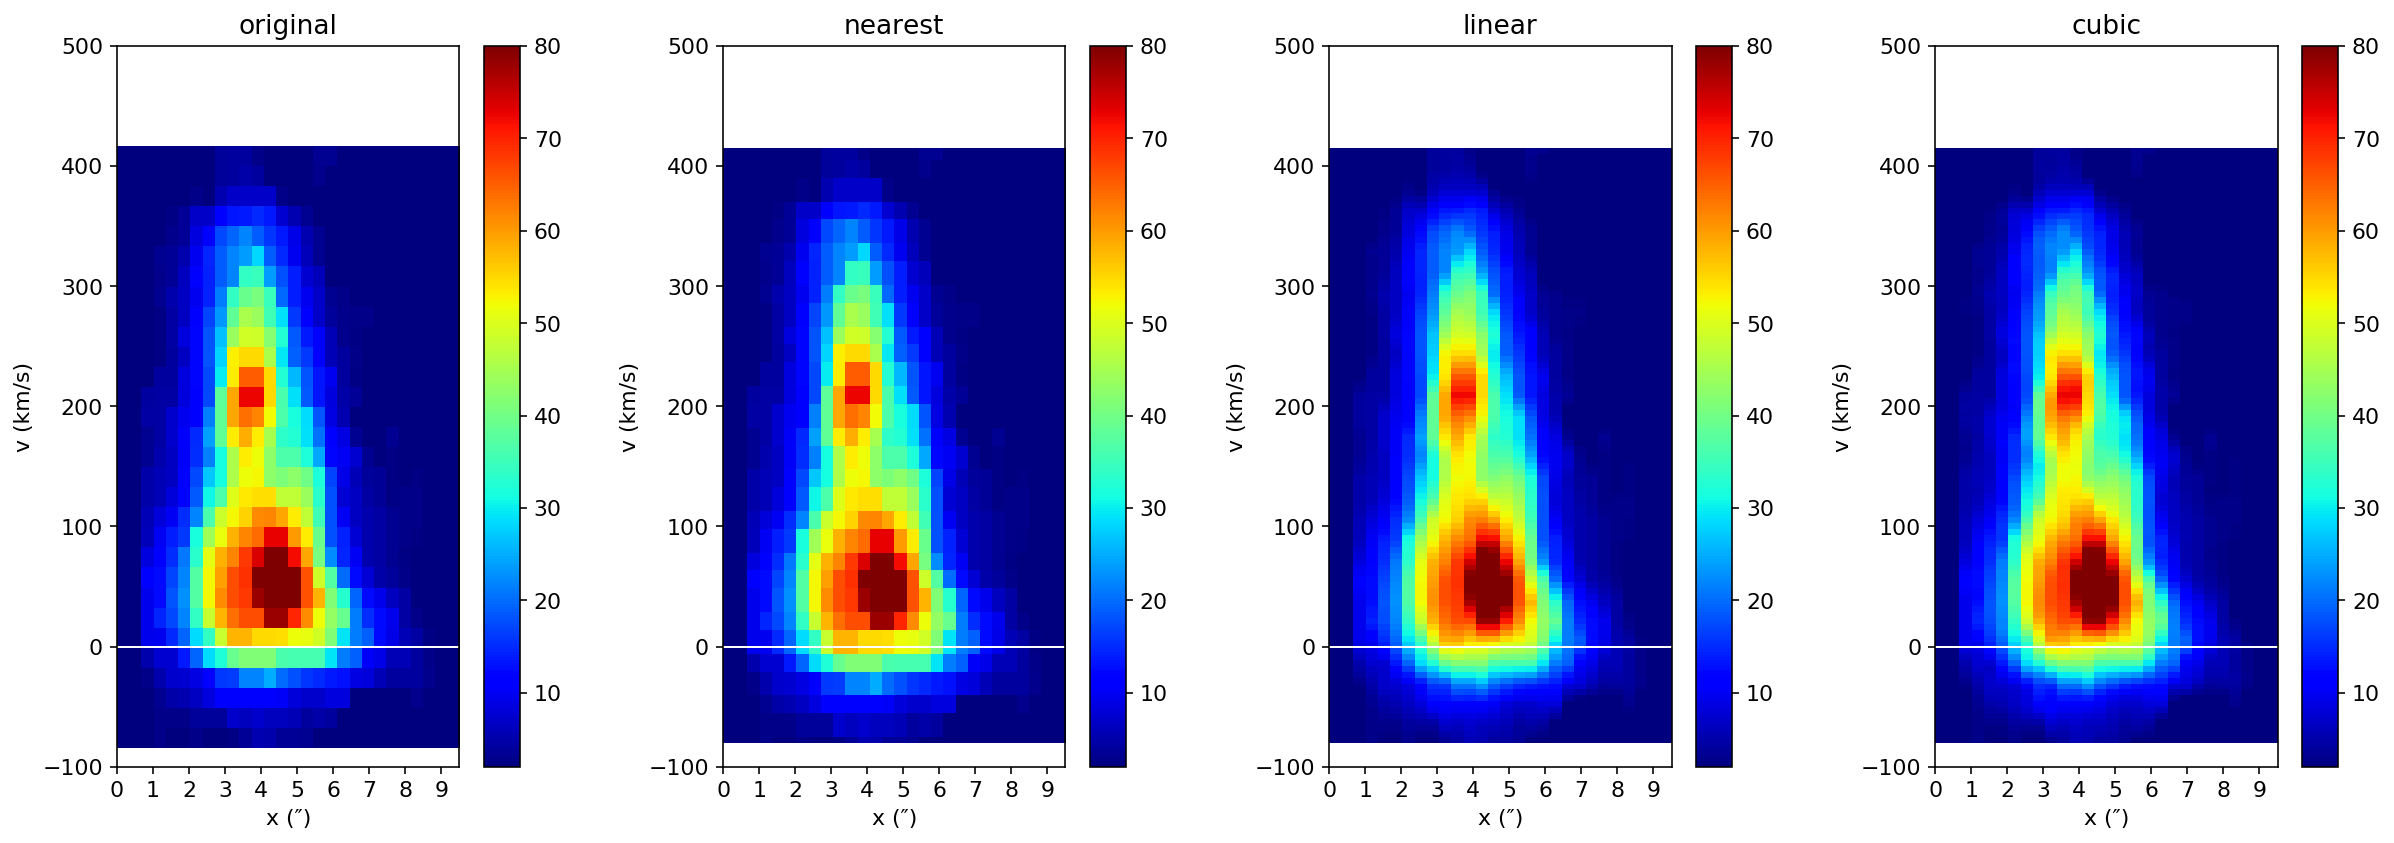

In [13]:
center = 4340.47
low = 4339.25
high = 4346.5
minpix = 2
maxpix = 80
tick = (-100, 600, 100)
color = "green"

hgamma_vvals, hgamma = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_hgamma_vvals, new_hgamma = test_grid_methods(hgamma_vvals, hgamma, minpix, maxpix, tick)
plt.show()


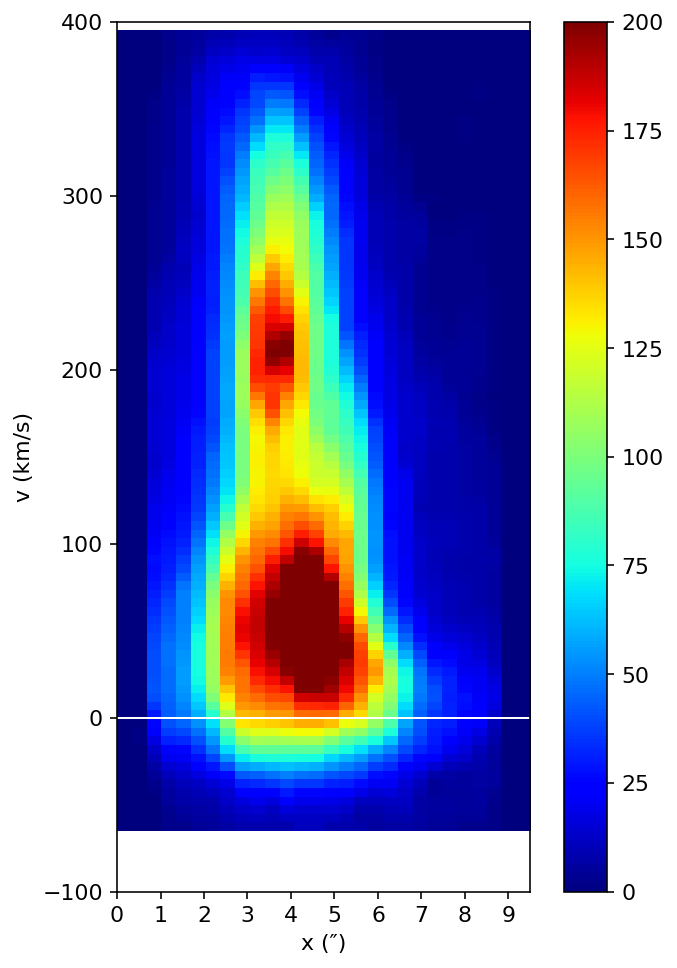

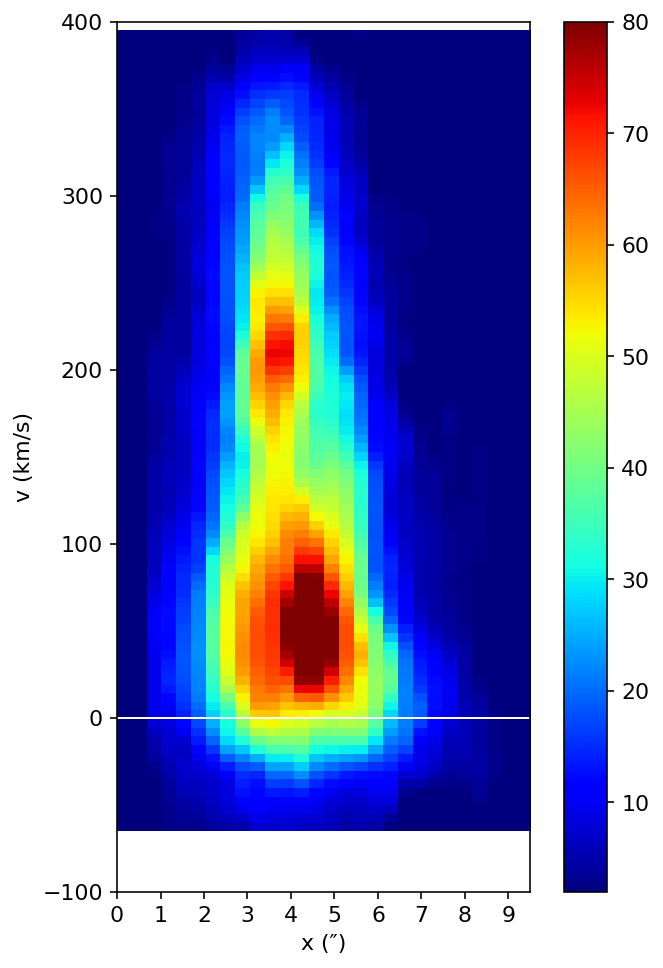

In [14]:
m_vvals, m_hbeta , m_hgamma = match_grids(new_hbeta_vvals, new_hbeta, new_hgamma_vvals, new_hgamma)

minpix = 0
maxpix = 200
tick = (-100, 500, 100)

plot_new_vx_slice(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 2
maxpix = 80
tick = (-100, 500, 100)

plot_new_vx_slice(m_hgamma, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 0.2006253646698963, std = 0.7603011677848553


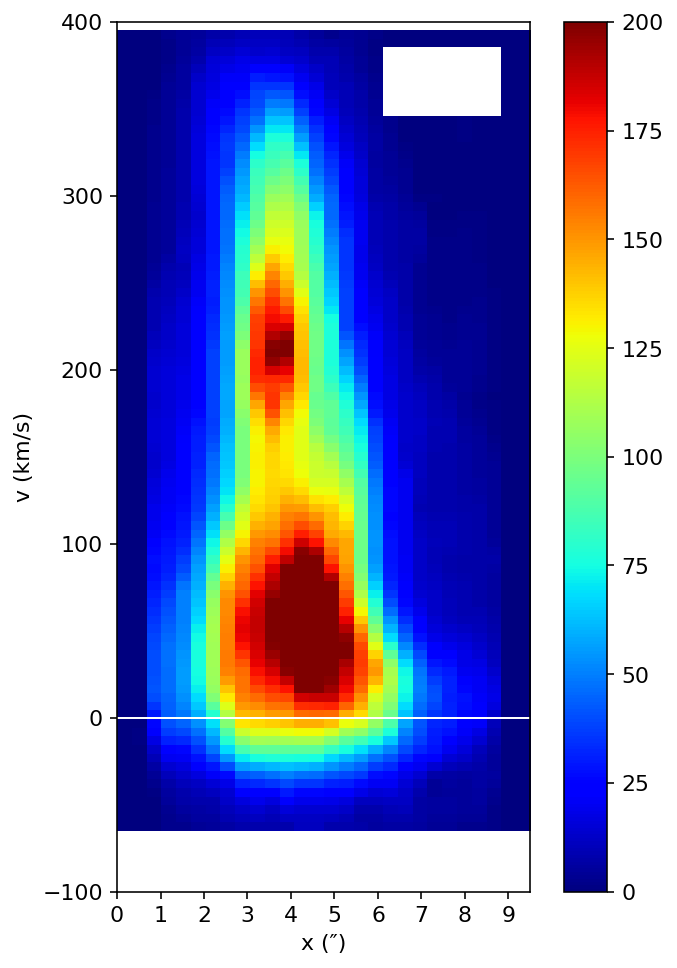

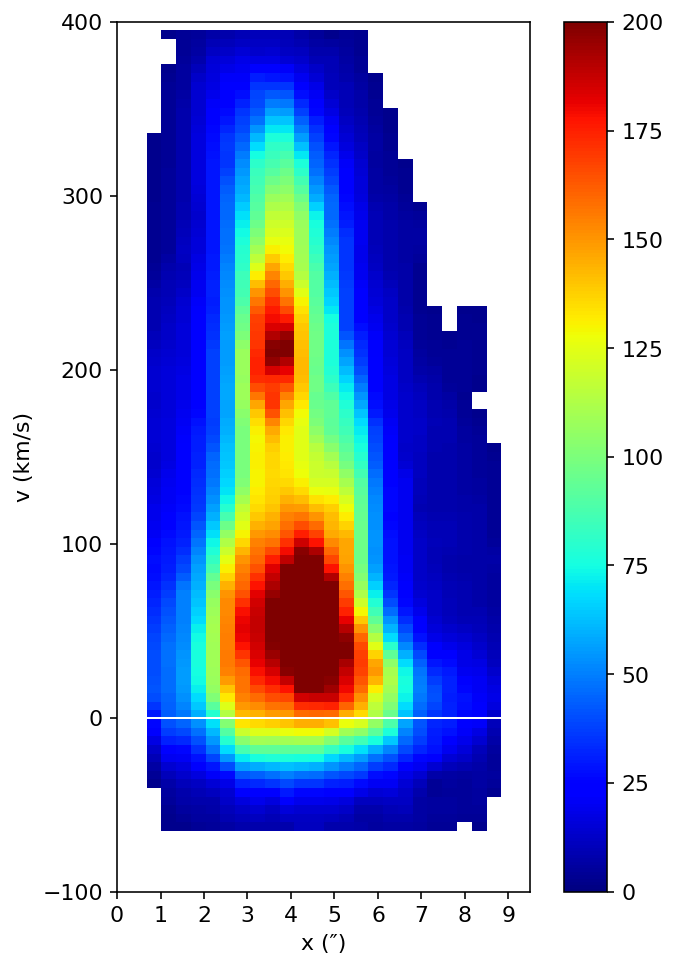

median = 0.025212931063350954, std = 1.037200928150256


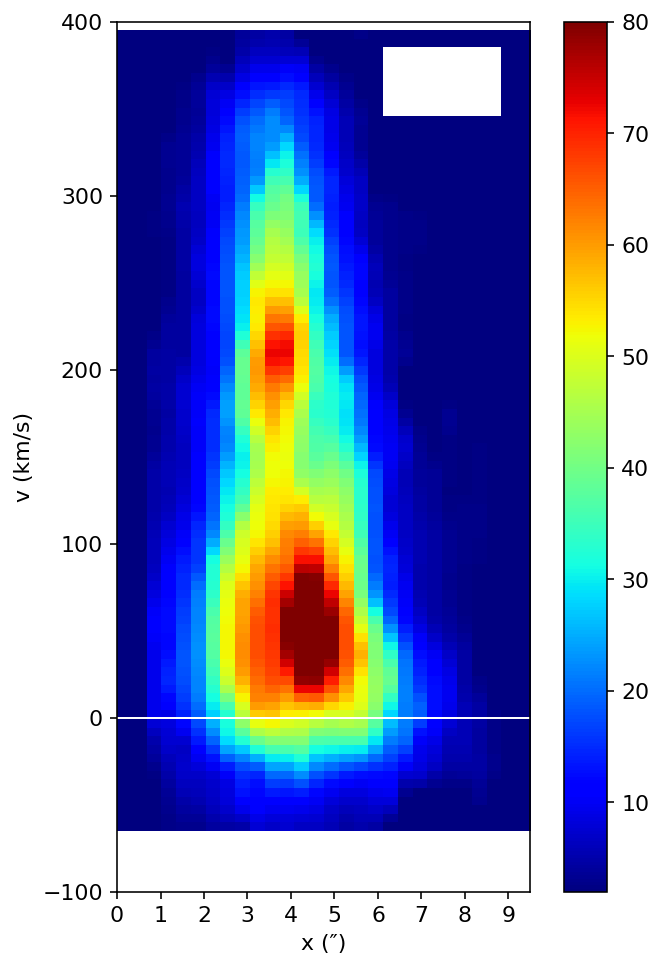

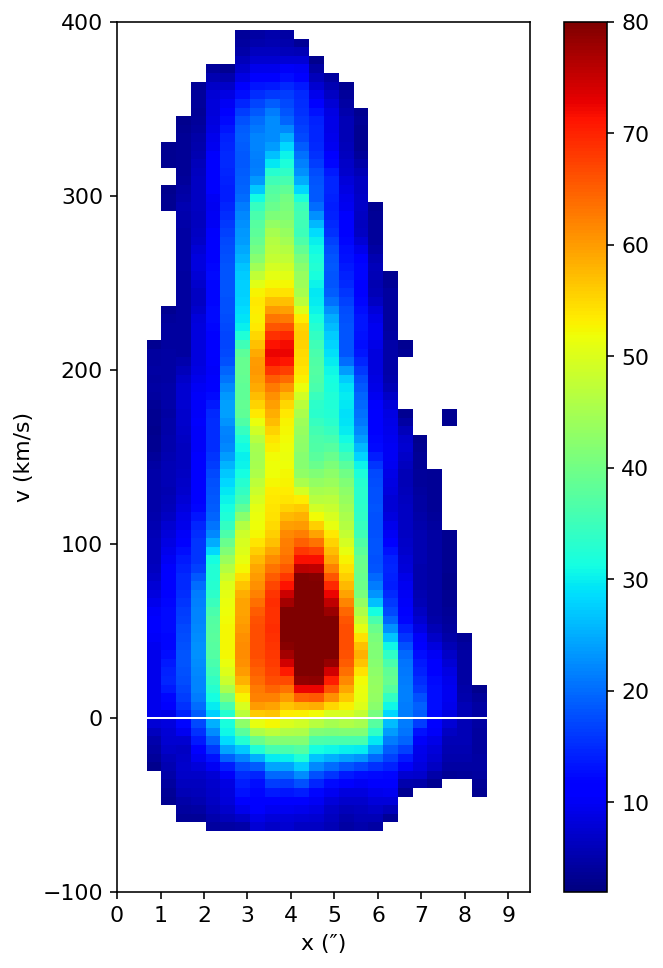

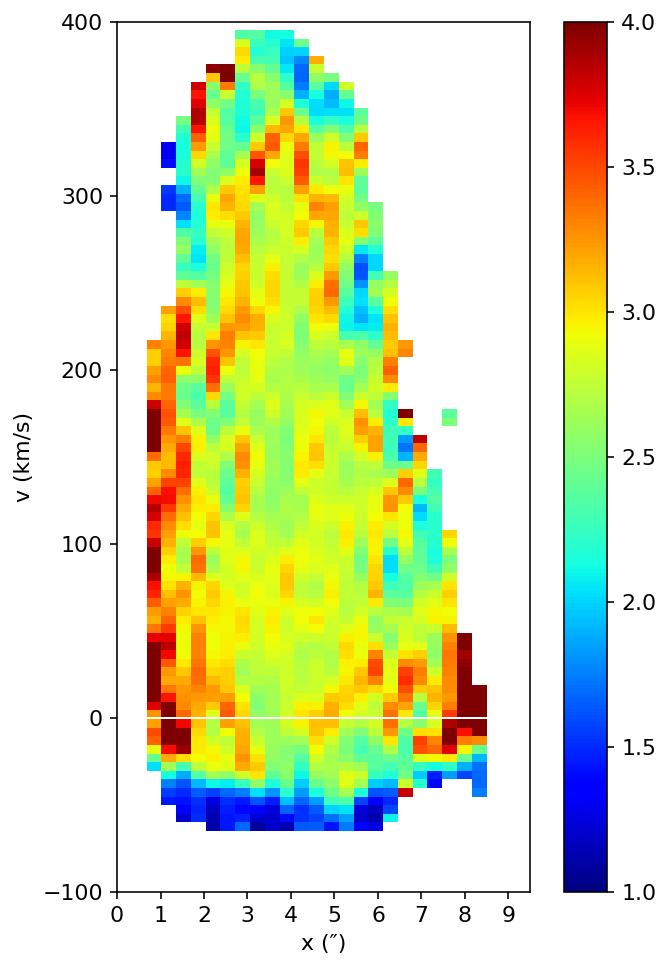

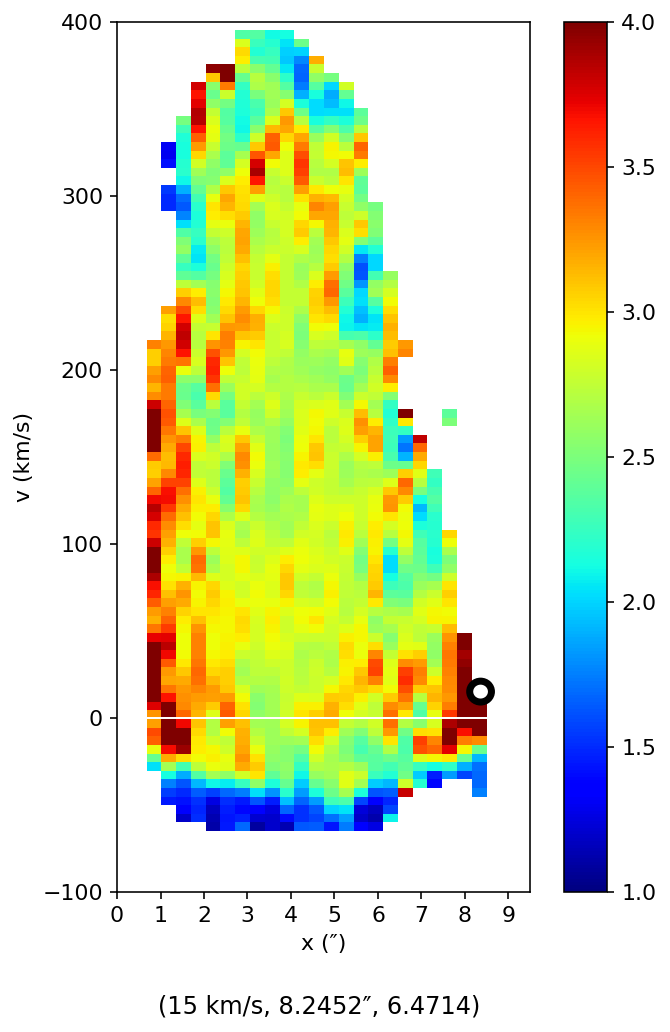

In [15]:
minpix = 0
maxpix = 200
tick = (-100, 500, 100)
m_hbetac = remove_noise(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 2
maxpix = 80
tick = (-100, 500, 100)
m_hgammac = remove_noise(m_hgamma, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)


hbeta_hgammac = m_hbetac / m_hgammac

minpix = 1
maxpix = 4
tick = (-100, 500, 100)
plot_new_vx_slice(hbeta_hgammac, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, hbeta_hgammac, minpix, maxpix, tick)

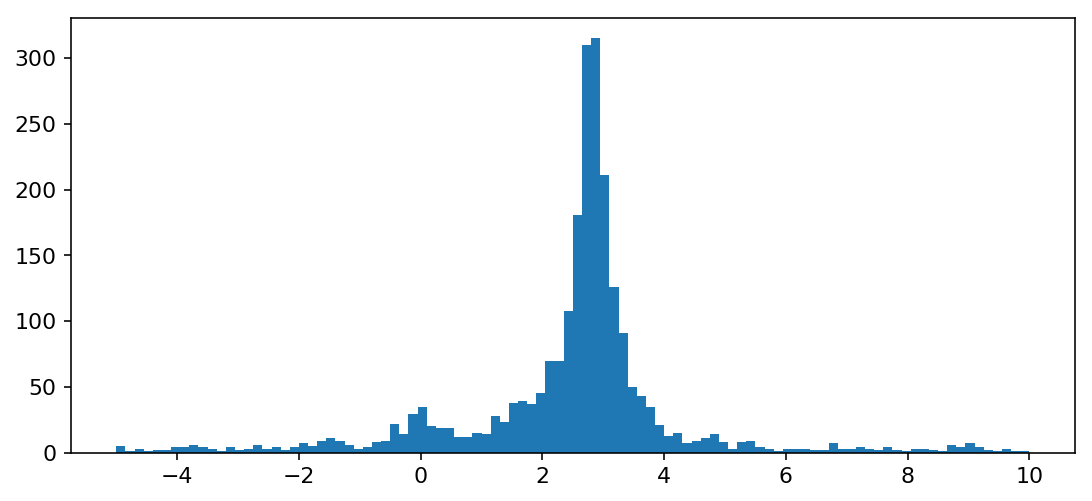

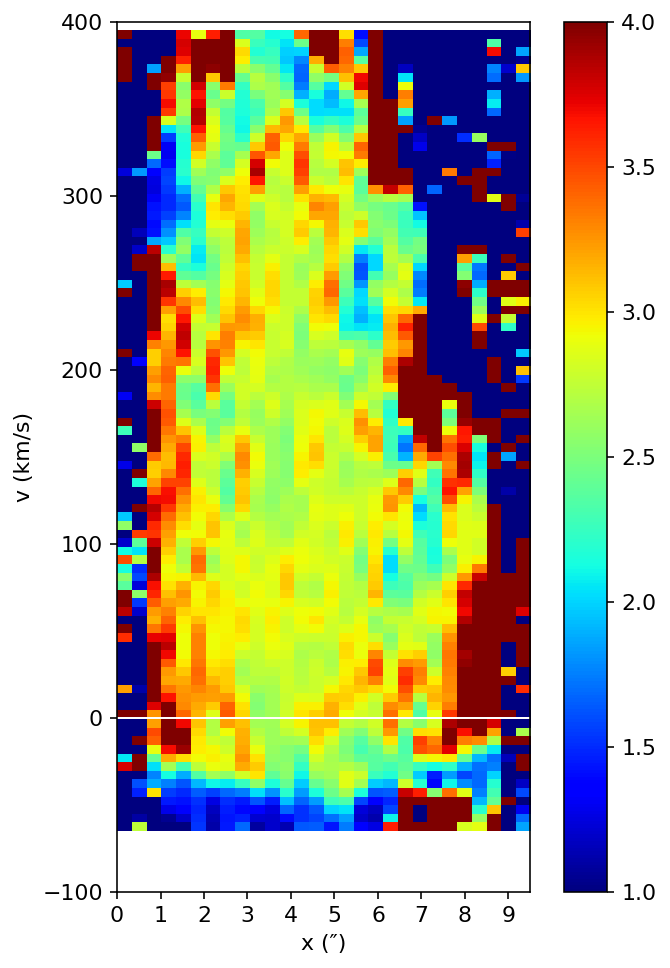

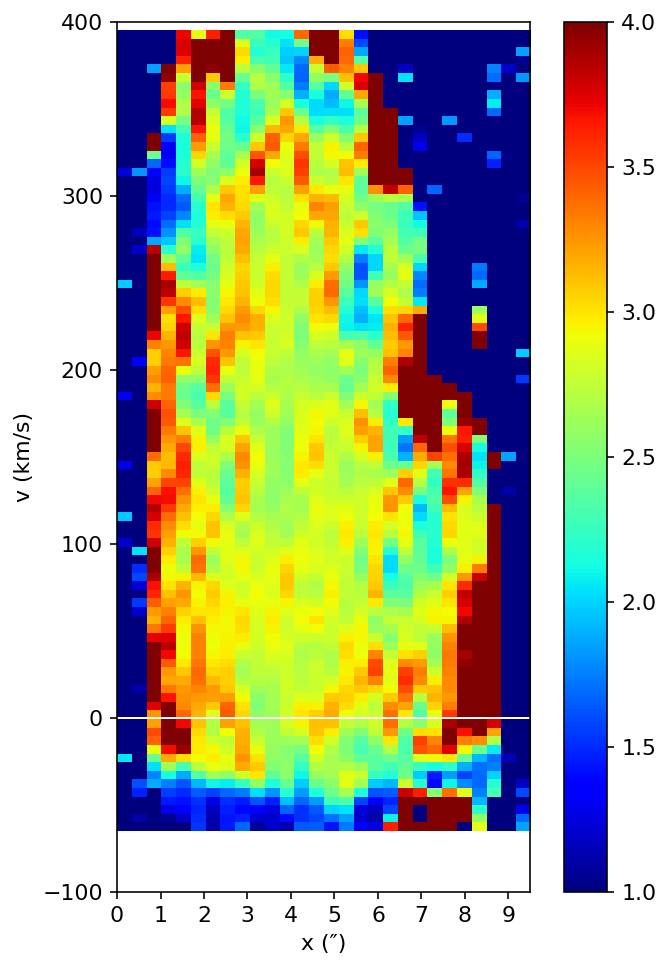

In [16]:
minpix = 1
maxpix = 4
tick = (-100, 500, 100)

hbeta_hgamma = m_hbeta / m_hgamma

plot_hist(hbeta_hgamma[hbeta_hgamma == hbeta_hgamma], [-5, 10])
plt.show() 

plot_new_vx_slice(hbeta_hgamma, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

for i in range(len(hbeta_hgamma)):
    for j in range(len(hbeta_hgamma[0])):
        if m_hbetac[i][j] != m_hbetac[i][j]:
            if hbeta_hgamma[i][j] > 2.1:
                hbeta_hgamma[i][j] = 0

plot_new_vx_slice(hbeta_hgamma, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)

v_low = -64.36681375721058, v_high = 619.5305824129963, aspect = 0.025


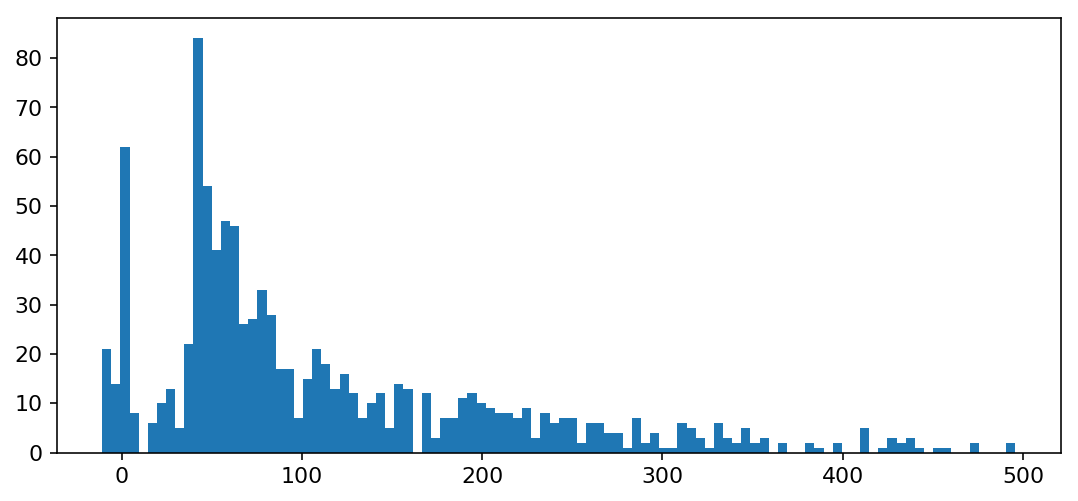

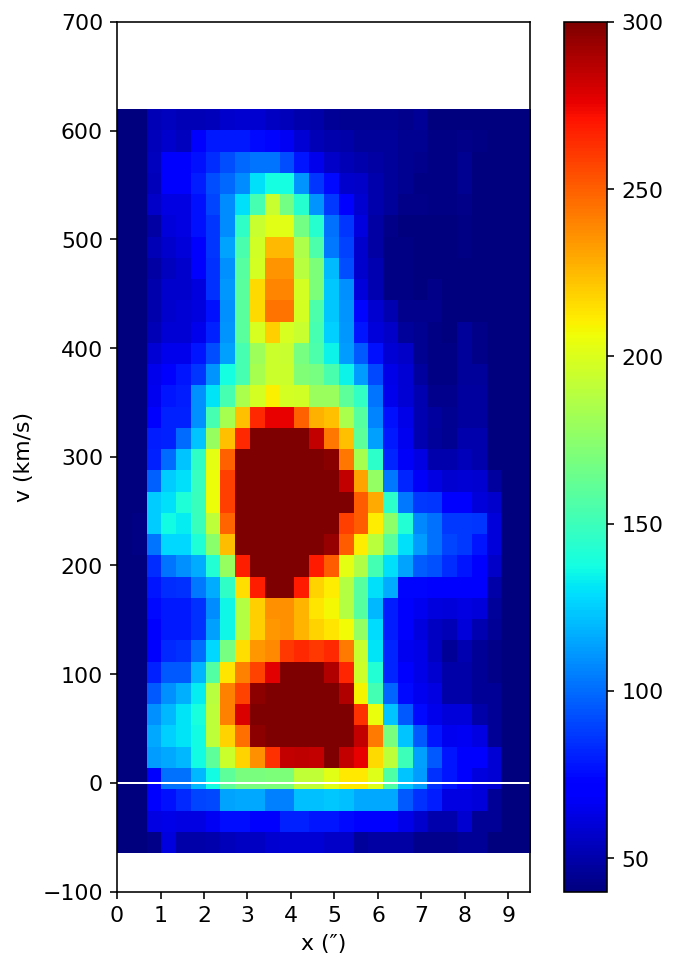

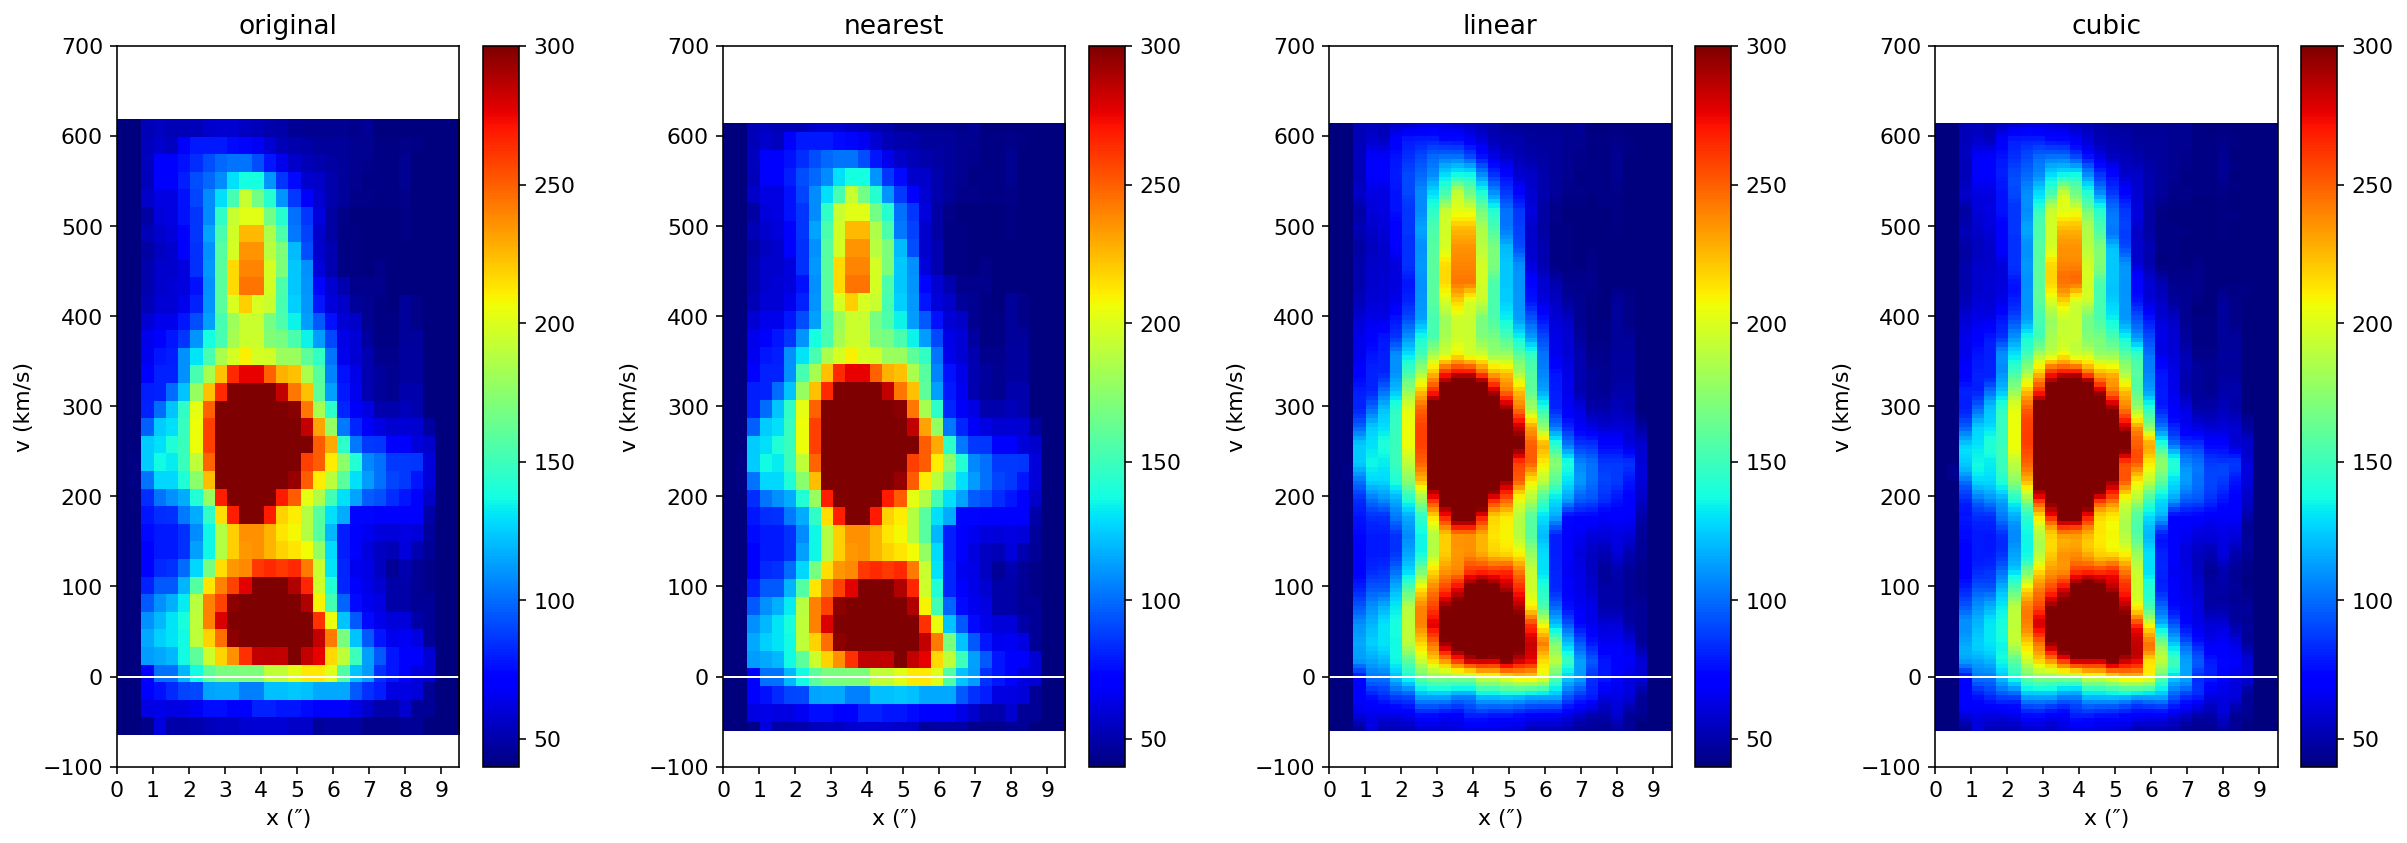

In [17]:
center = 3726.05
low = 3725.25
high = 3733.75
minpix = 40
maxpix = 300
tick = (-100, 800, 100)
color = "blue"

oii_vvals, oii = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_oii_vvals, new_oii = test_grid_methods(oii_vvals, oii, minpix, maxpix, tick)
plt.show()

v_low = -50.43878880247478, v_high = 377.8150783881872, aspect = 0.04


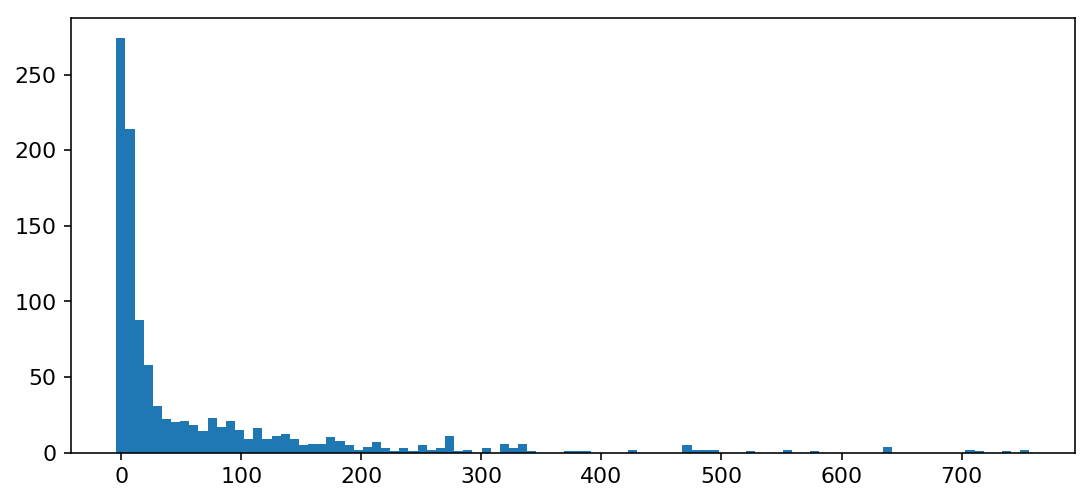

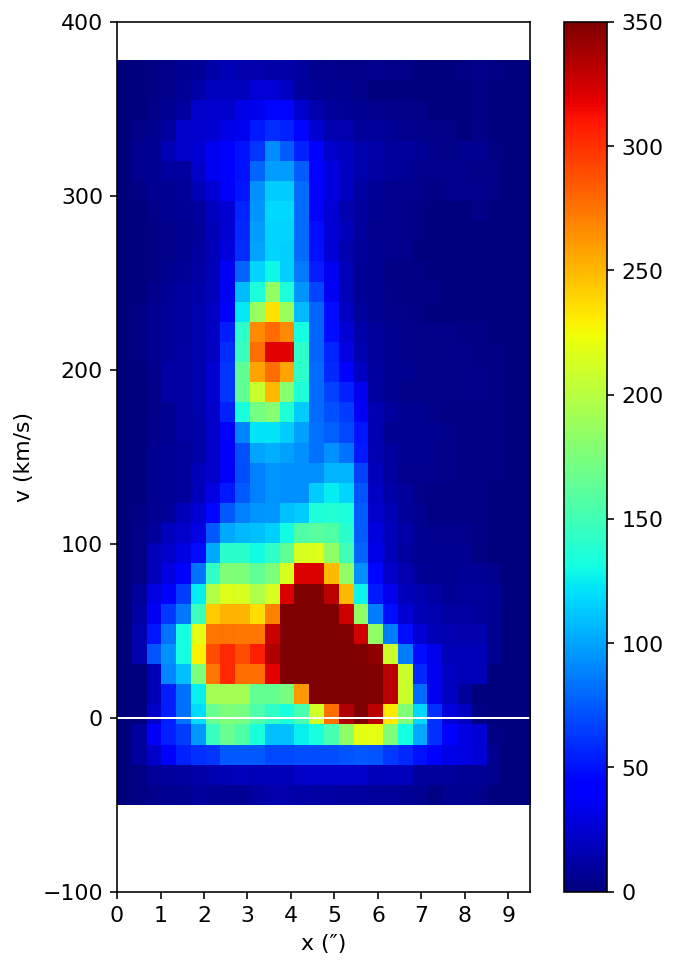

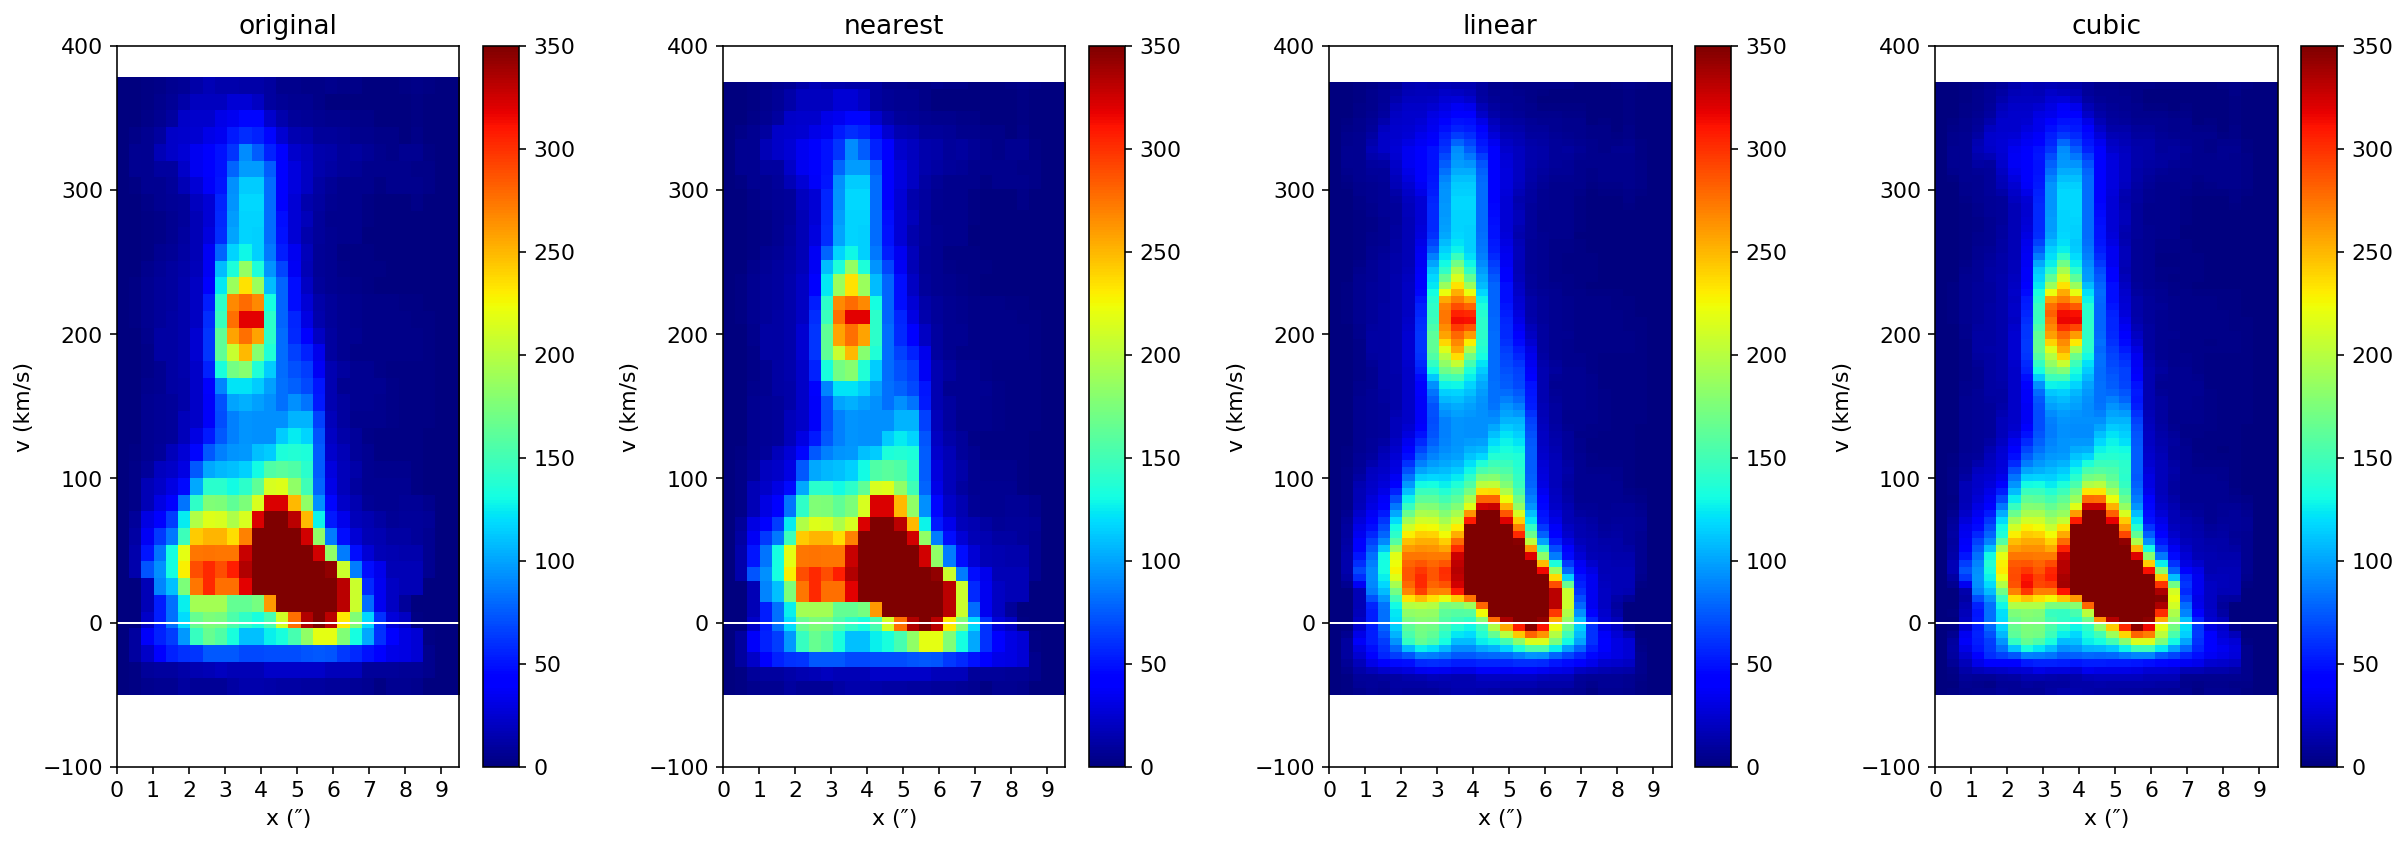

In [18]:
center = 6300.31
low =  6299.25
high = 6308.25
minpix = 0
maxpix = 350
tick = (-100, 500, 100)
color = "red"

oi_vvals, oi = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_oi_vvals, new_oi = test_grid_methods(oi_vvals, oi, minpix, maxpix, tick)
plt.show()

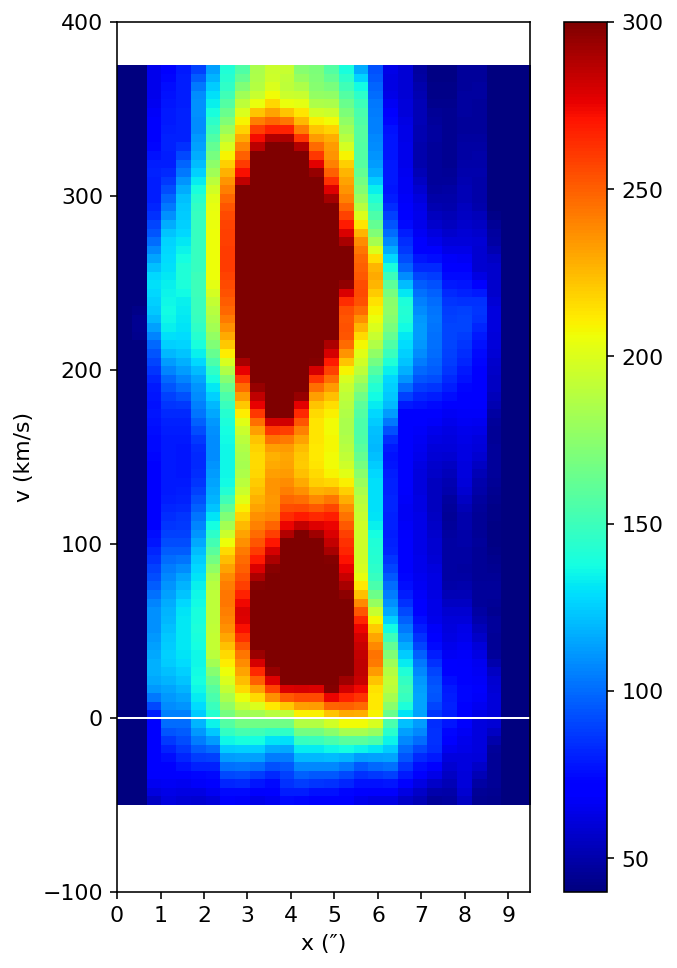

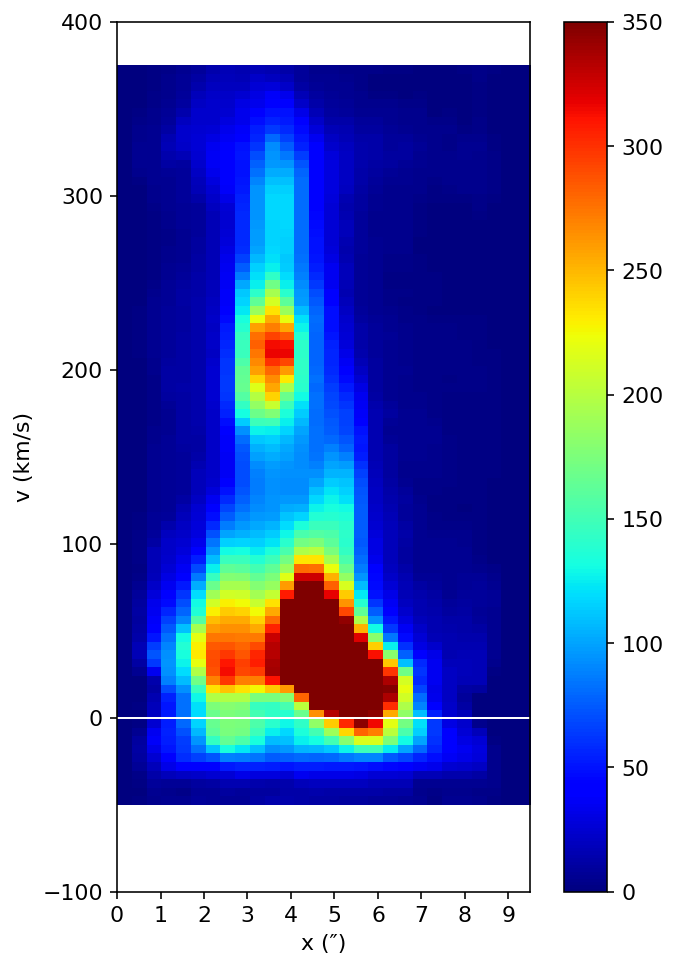

In [19]:
m_vvals, m_oii , m_oi = match_grids(new_oii_vvals, new_oii, new_oi_vvals, new_oi)

minpix = 40
maxpix = 300
tick = (-100, 500, 100)

plot_new_vx_slice(m_oii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 0
maxpix = 350
tick = (-100, 500, 100)

plot_new_vx_slice(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

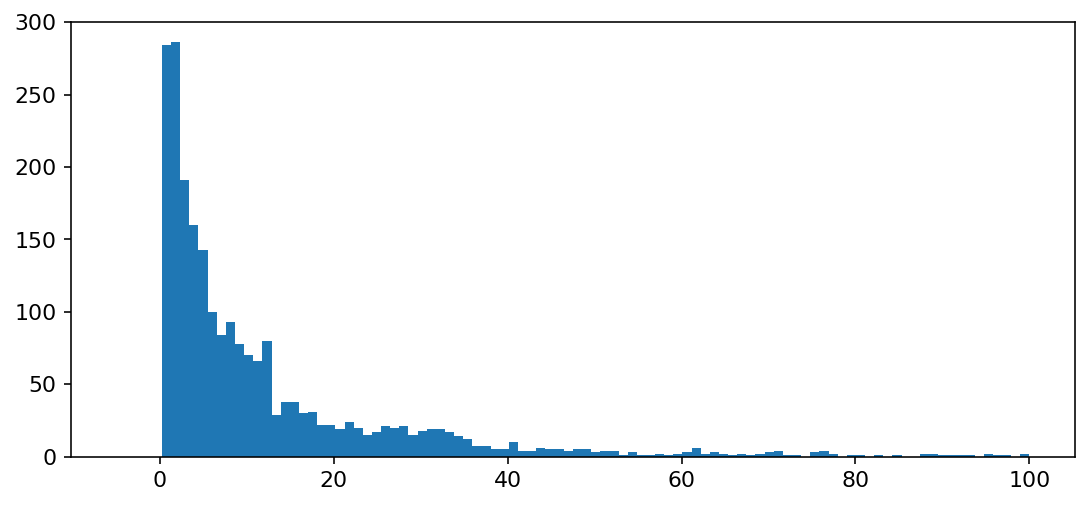

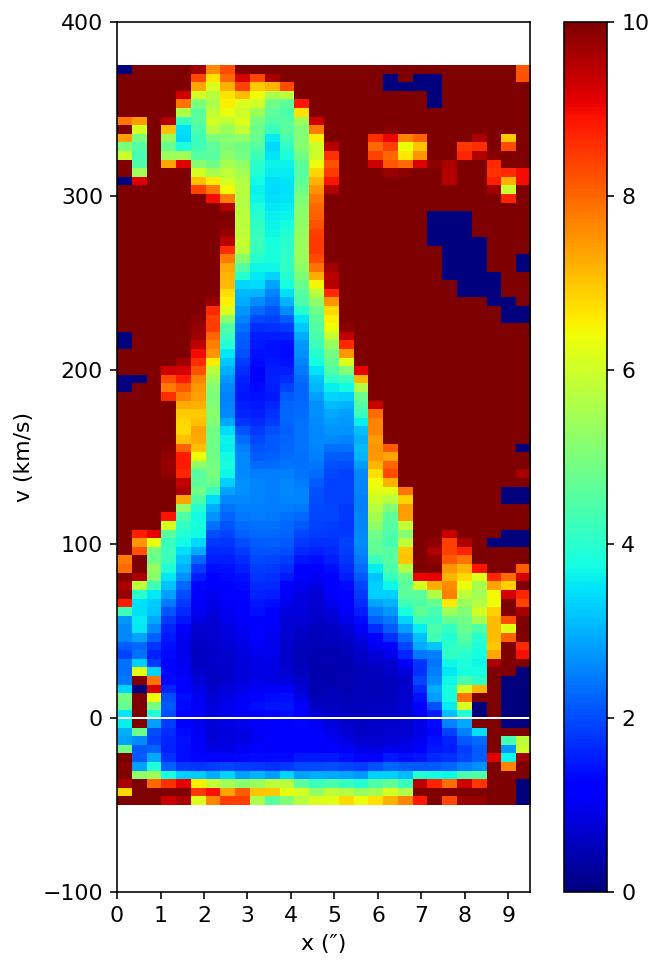

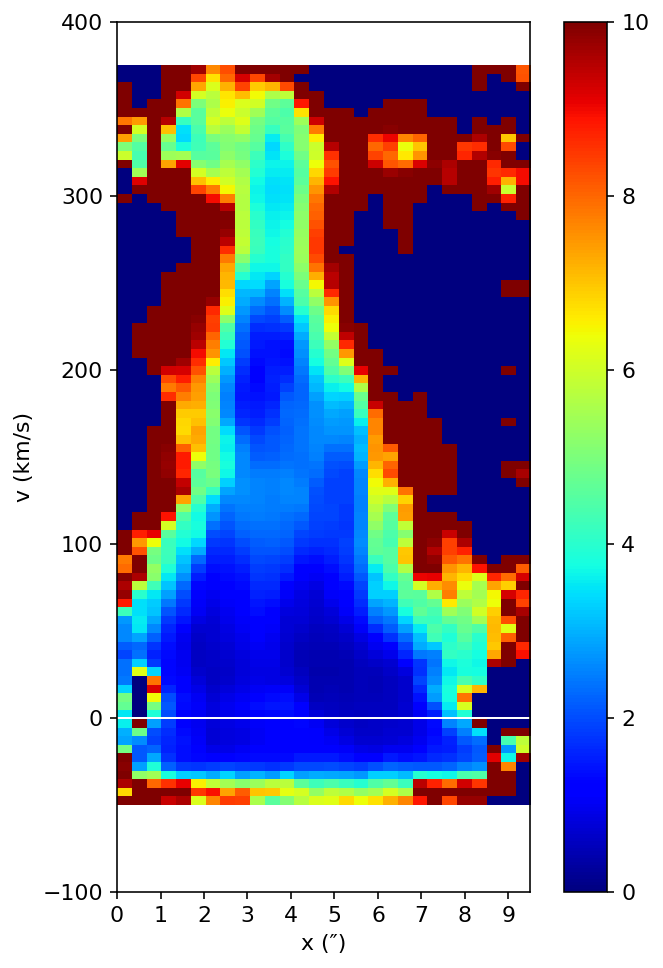

In [20]:
minpix = 0
maxpix = 10
tick = (-100, 500, 100)

oii_oi = m_oii / m_oi

plot_hist(oii_oi[oii_oi == oii_oi], [-5, 100])
plt.show() 
            
plot_new_vx_slice(oii_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

for i in range(len(oii_oi)):
    for j in range(len(oii_oi[0])):
        if oii_oi[i][j] > 20:
            oii_oi[i][j] = 0

plot_new_vx_slice(oii_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()
        

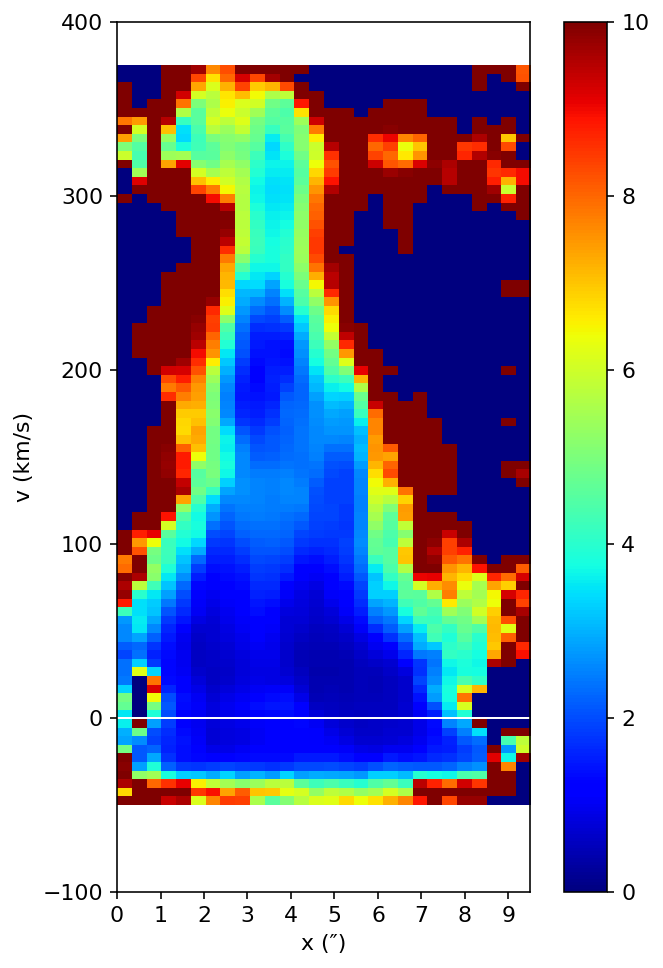

In [21]:
for i in range(len(oii_oi)):
    for j in range(len(oii_oi[0])):
        if oii_oi[i][j] > 20:
            oii_oi[i][j] = 0

oii_oi_med = ndimage.median_filter(oii_oi, 1)

plot_new_vx_slice(oii_oi_med, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)

median = 45.83685198640192, std = 7.881195608169963


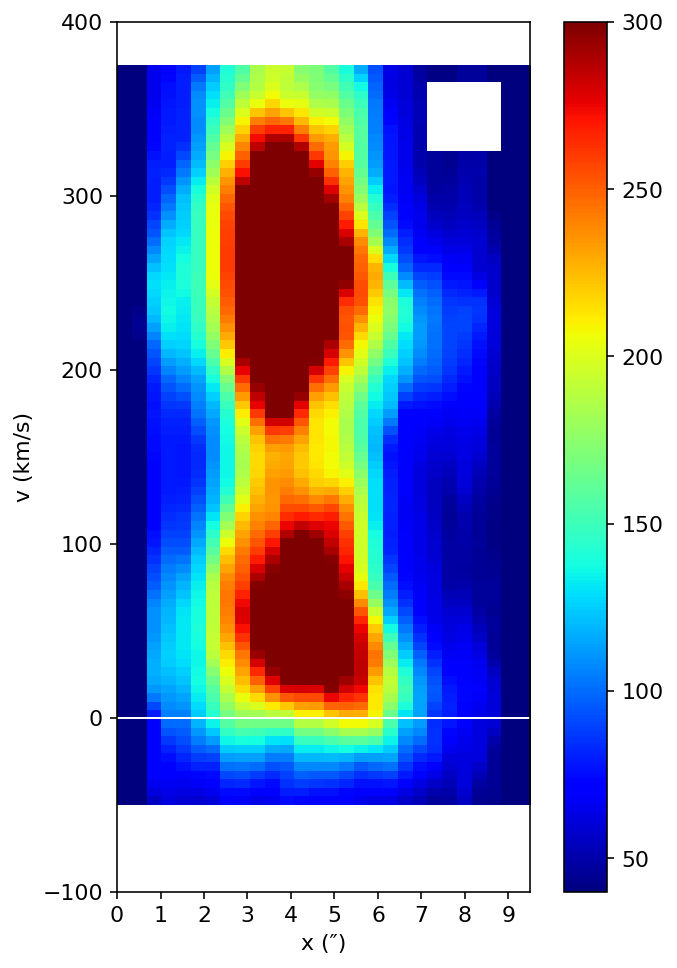

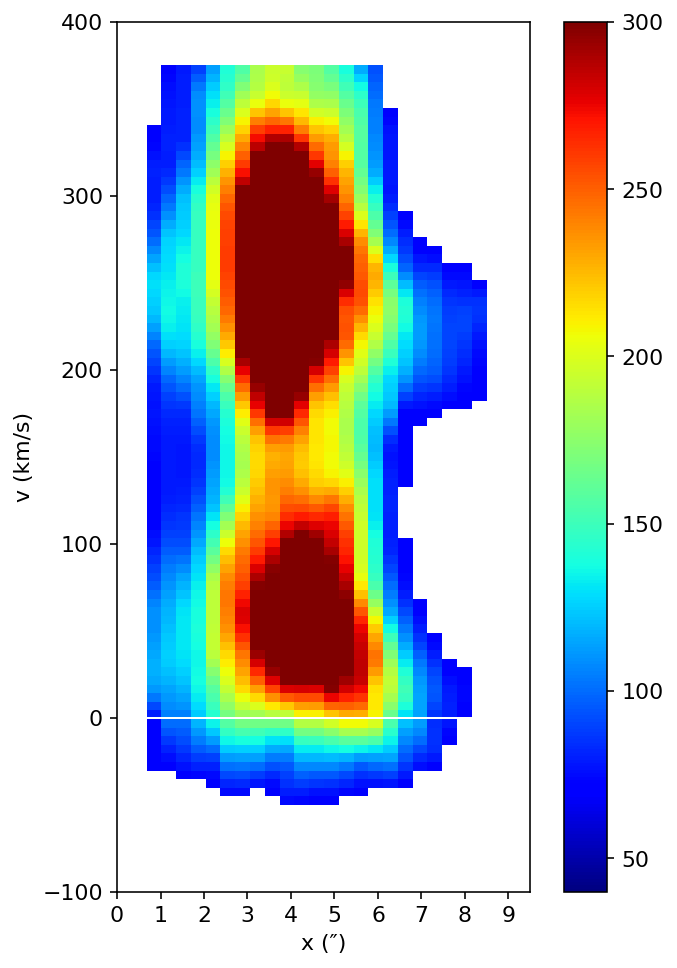

median = 3.572364347664486, std = 2.633504466580577


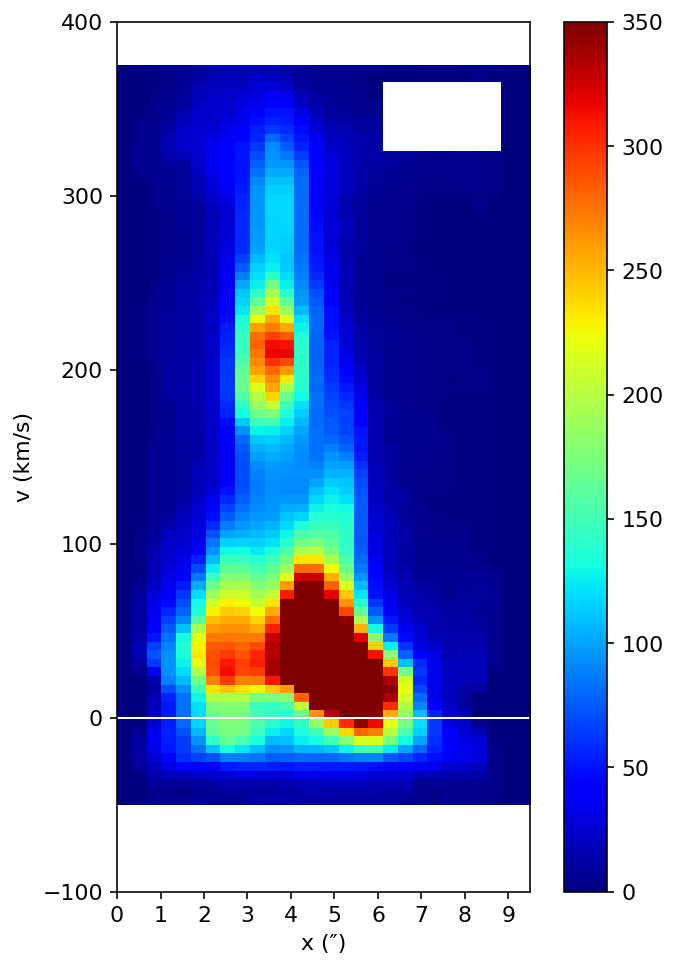

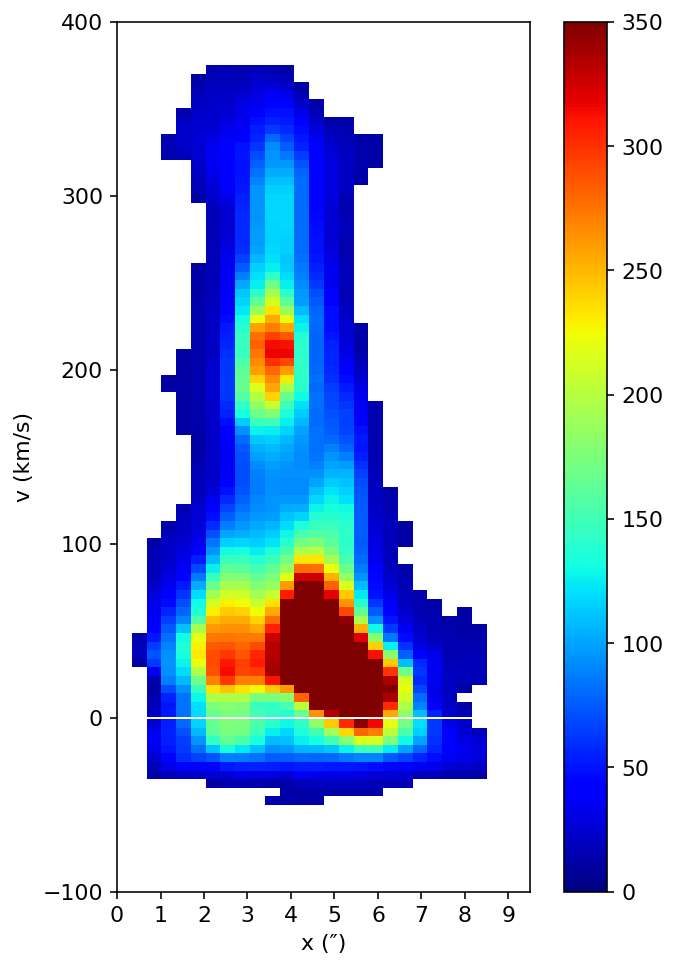

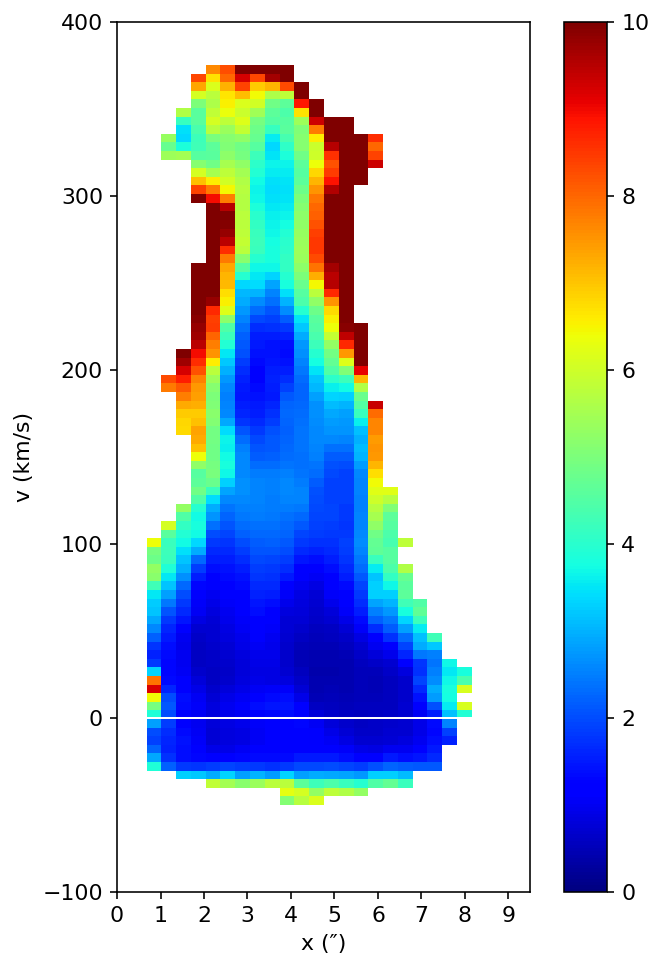

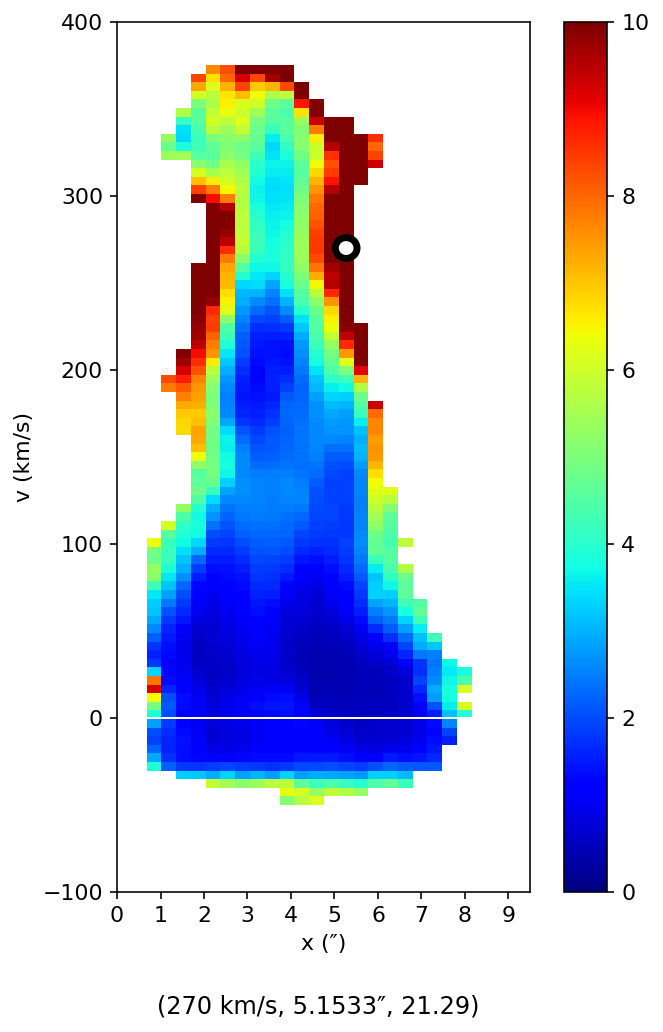

In [22]:
minpix = 40
maxpix = 300
tick = (-100, 500, 100)
m_oiic = remove_noise(m_oii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3, (8,5))

minpix = 0
maxpix = 350
tick = (-100, 500, 100)
m_oic = remove_noise(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

oii_oic = m_oiic / m_oic

minpix = 0
maxpix = 10
tick = (-100, 500, 100)
plot_new_vx_slice(oii_oic, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, oii_oic, minpix, maxpix, tick)

v_low = -40.50497827349943, v_high = 352.4537661708554, aspect = 0.04


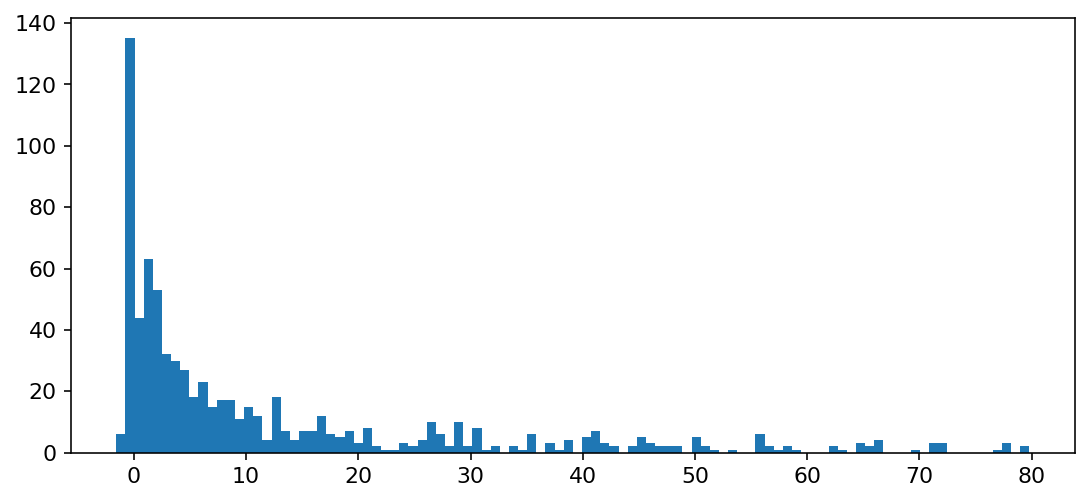

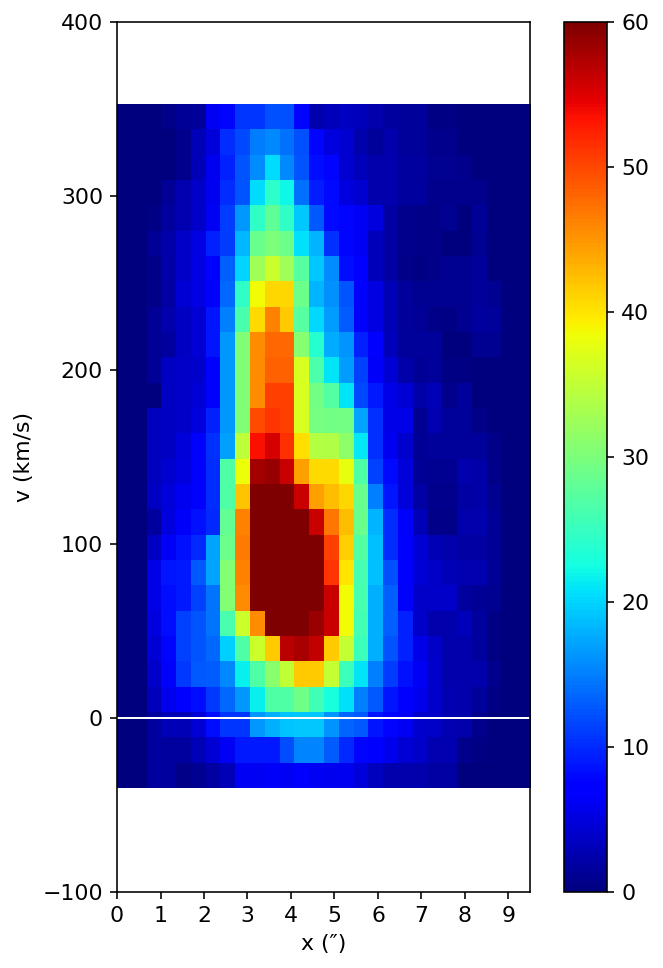

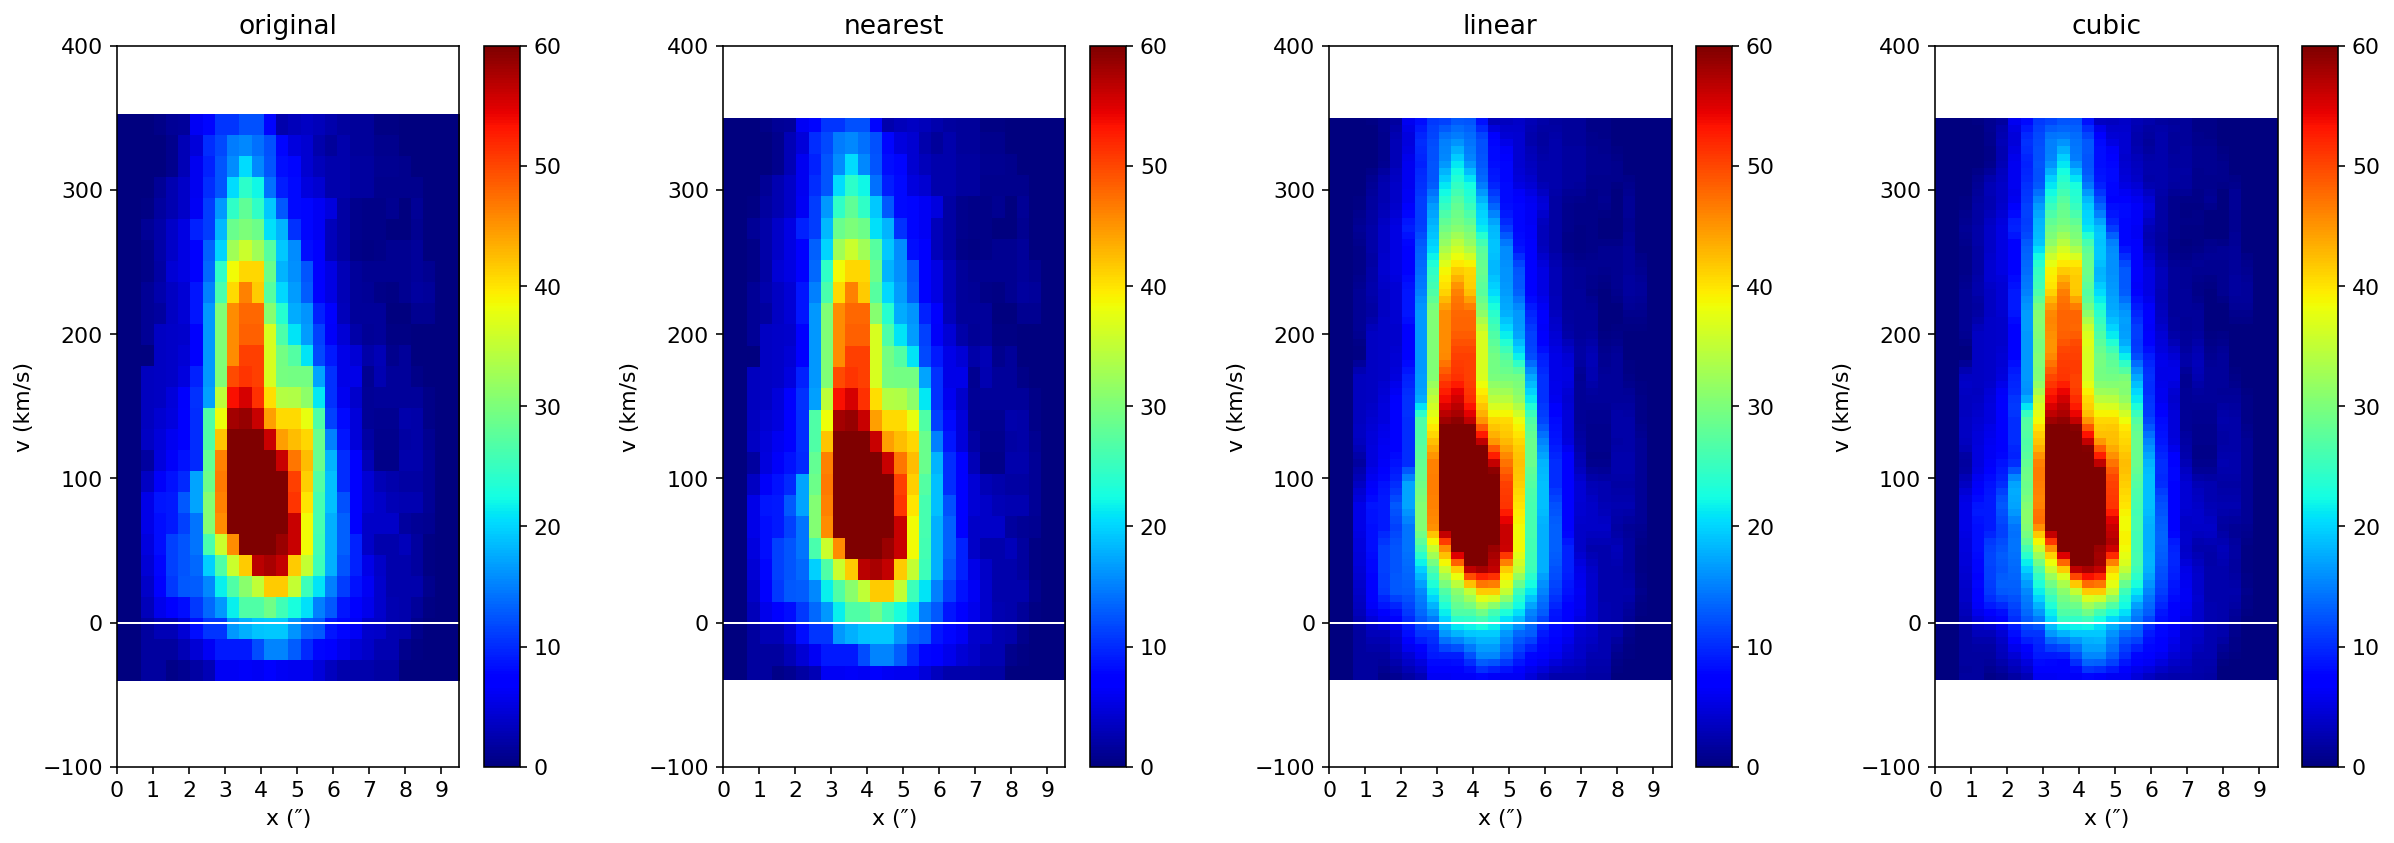

In [23]:
center = 4958.92
low =  4958.25 
high = 4964.75
minpix = 0
maxpix = 60
tick = (-100, 500, 100)
color = "green"

s4959_vvals, s4959 = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_s4959_vvals, new_s4959 = test_grid_methods(s4959_vvals, s4959, minpix, maxpix, tick)
plt.show()

v_low = -65.86410693352288, v_high = 383.20934943125735, aspect = 0.04


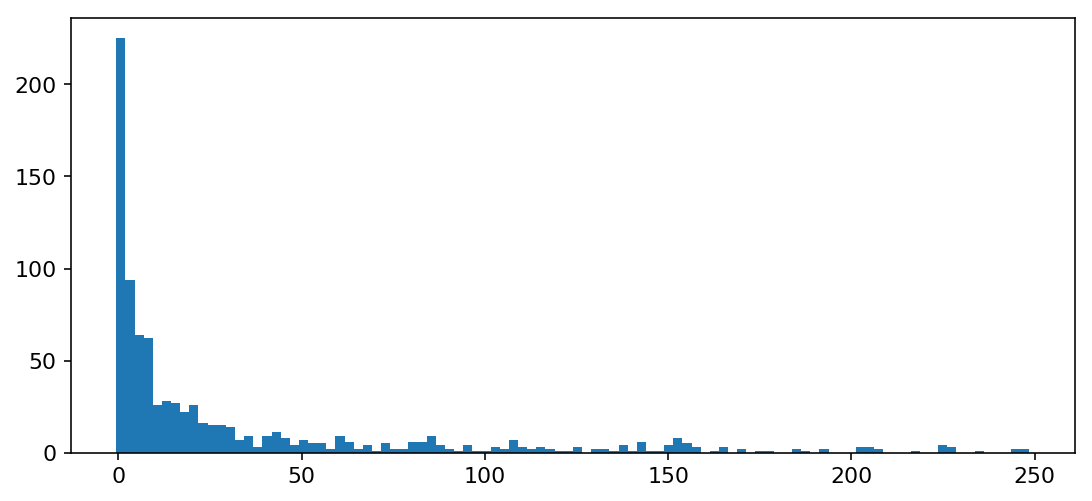

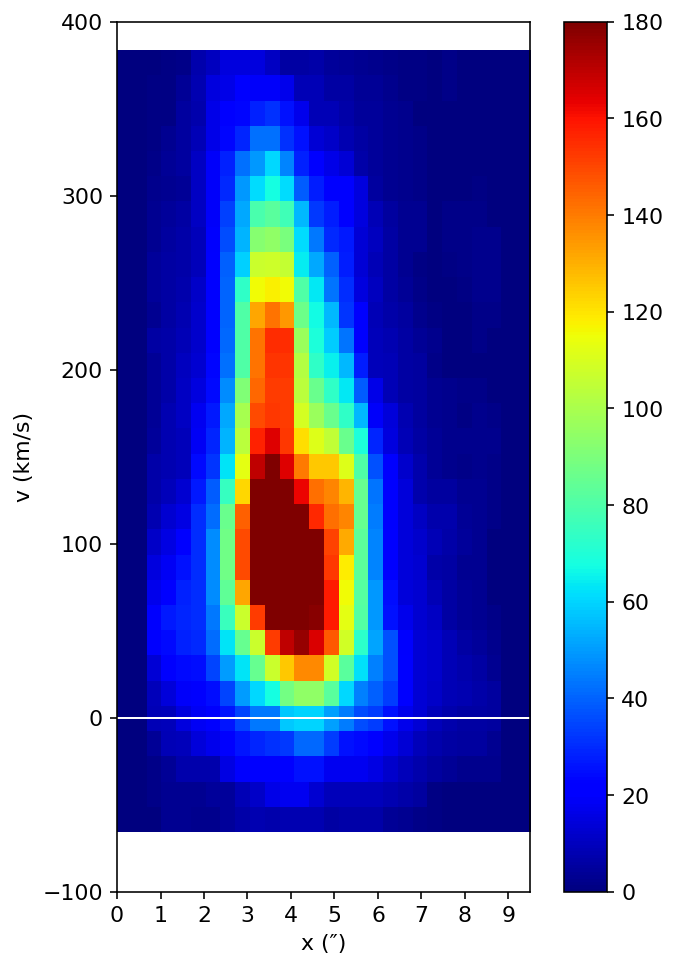

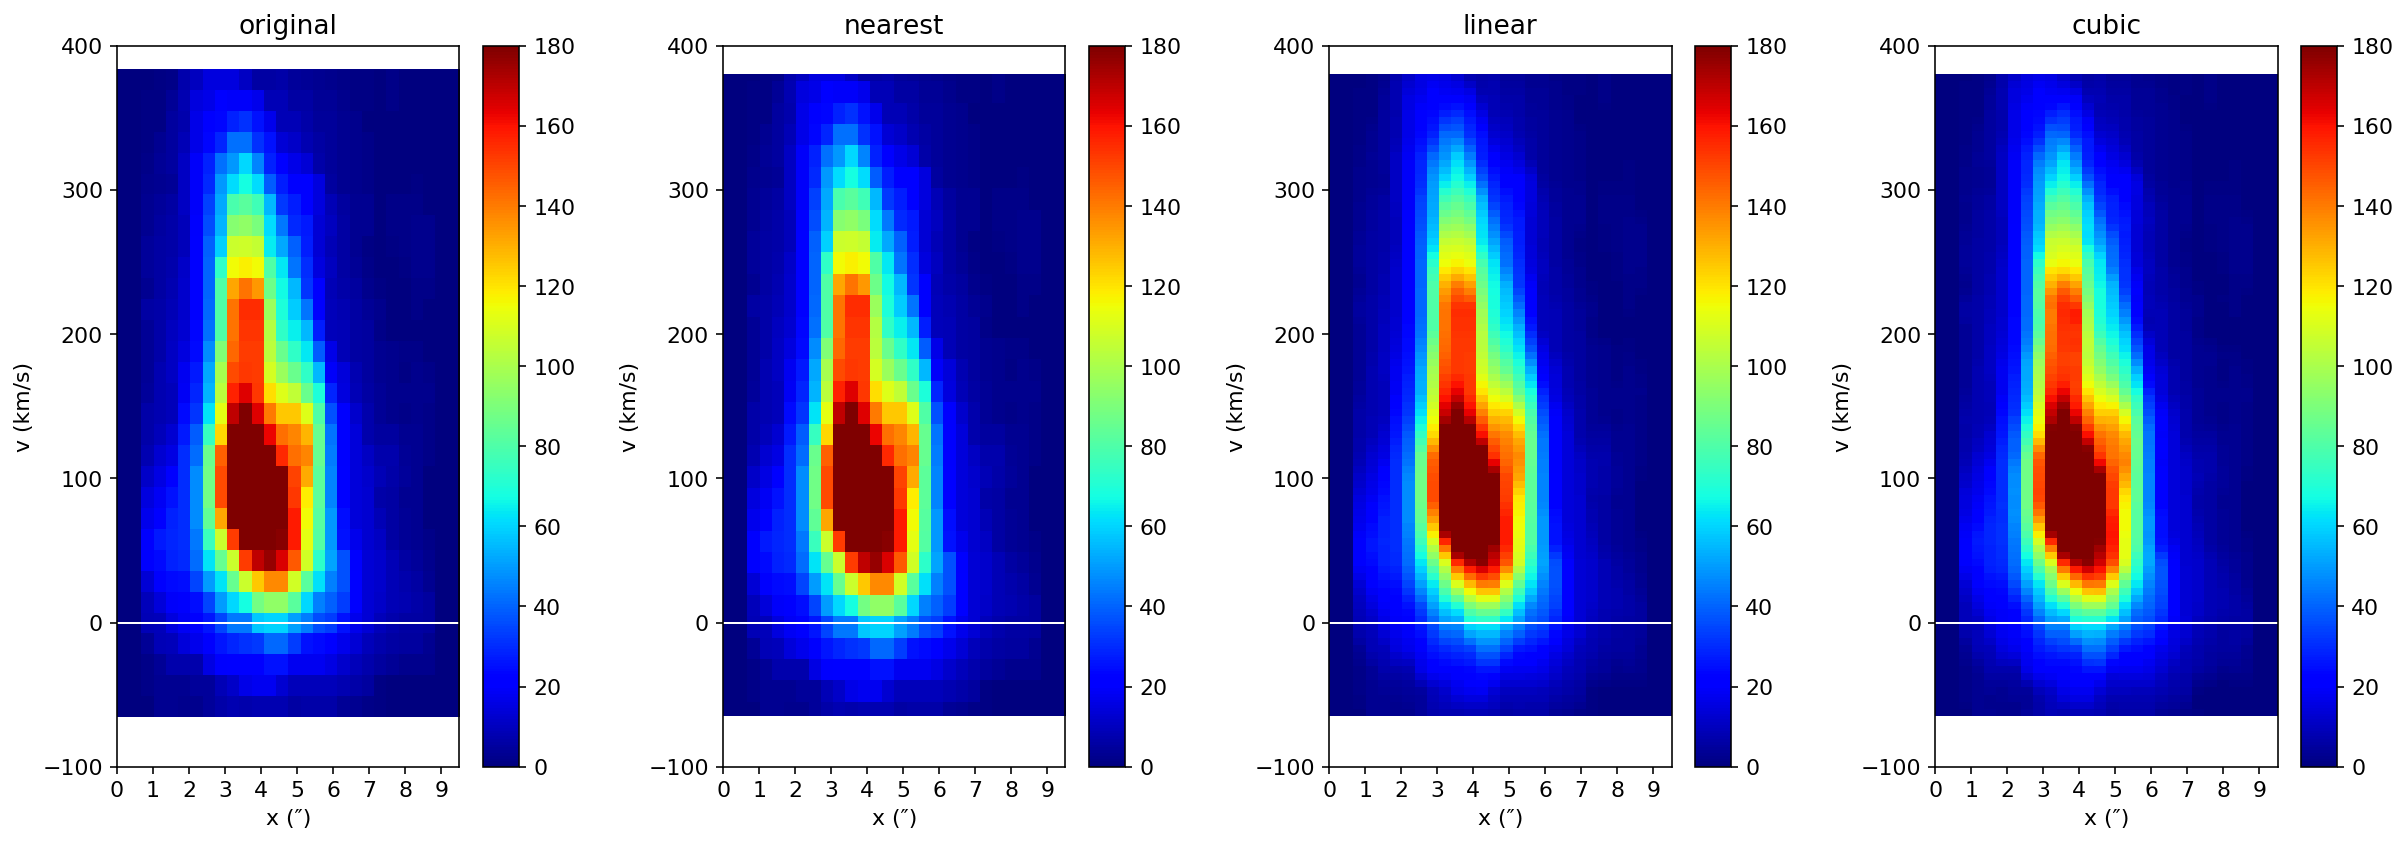

In [24]:
center = 5006.85
low =  5005.75
high = 5013.25
minpix = 0
maxpix = 180
tick = (-100, 500, 100)
color = "green"

s5007_vvals, s5007 = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_s5007_vvals, new_s5007 = test_grid_methods(s5007_vvals, s5007, minpix, maxpix, tick)
plt.show()

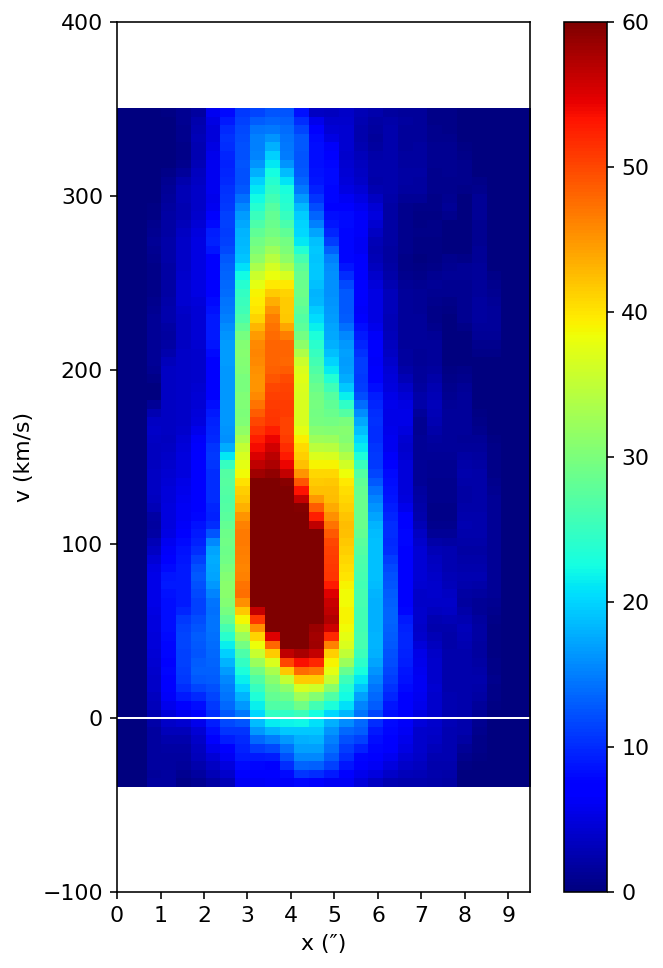

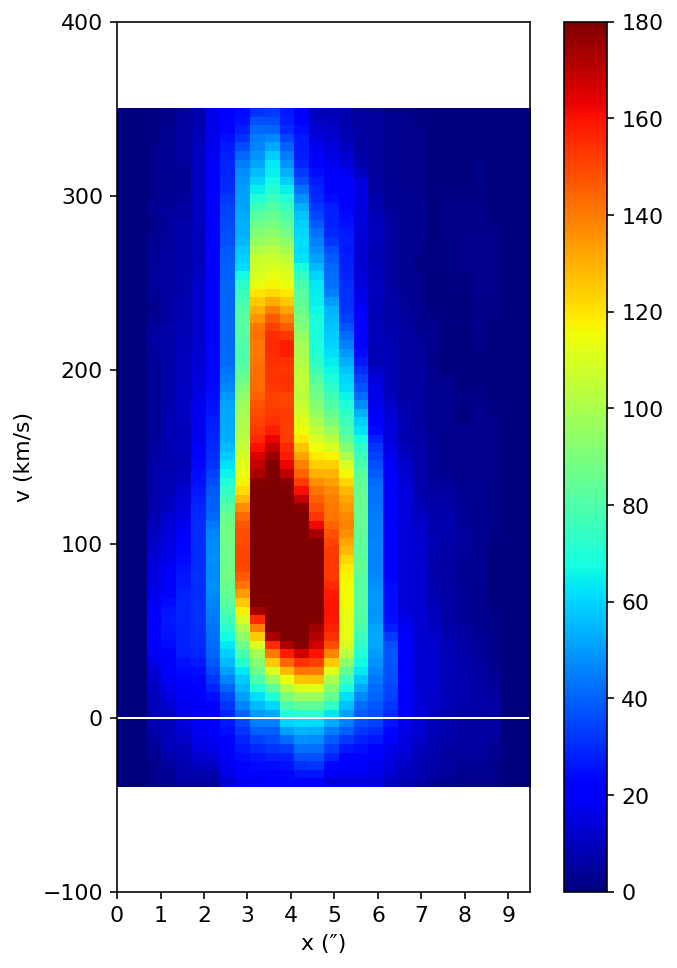

In [25]:
m_vvals, m_s4959 , m_s5007 = match_grids(new_s4959_vvals, new_s4959, new_s5007_vvals, new_s5007)

minpix = 0
maxpix = 60
tick = (-100, 500, 100)

plot_new_vx_slice(m_s4959, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 0
maxpix = 180
tick = (-100, 500, 100)

plot_new_vx_slice(m_s5007, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

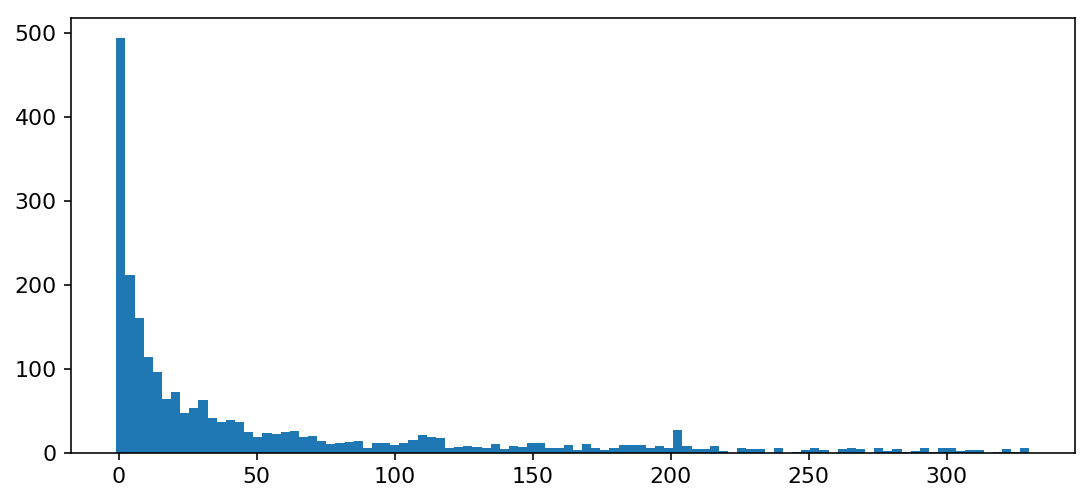

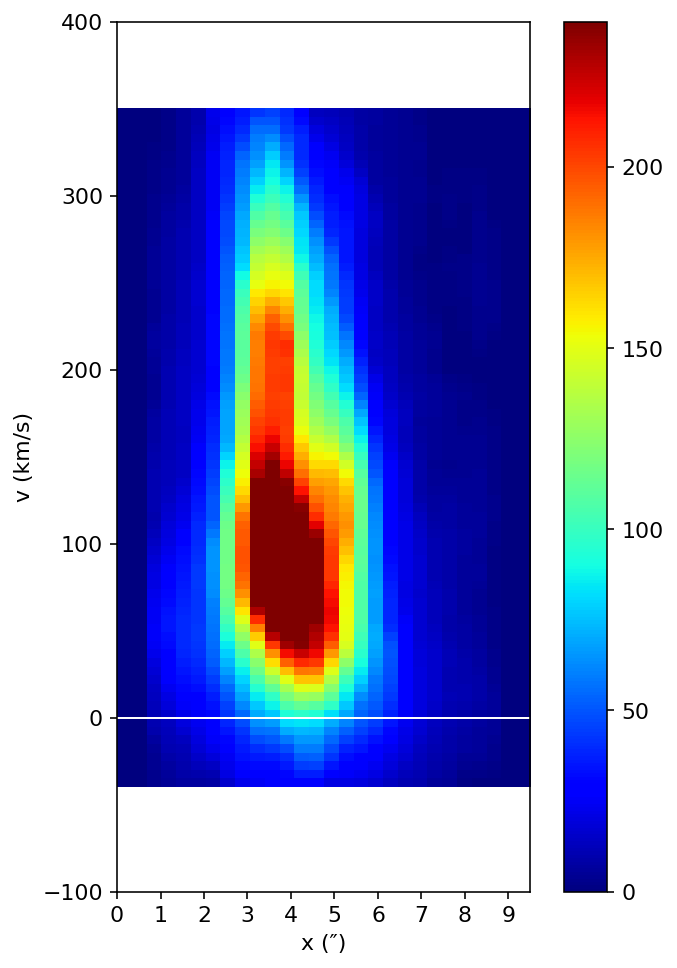

In [26]:
minpix = 0
maxpix = 240
tick = (-100, 500, 100)

oiii = m_s4959 + m_s5007
oiii_vvals = m_vvals

plot_hist(oiii[oiii == oiii])
plt.show() 

plot_new_vx_slice(oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

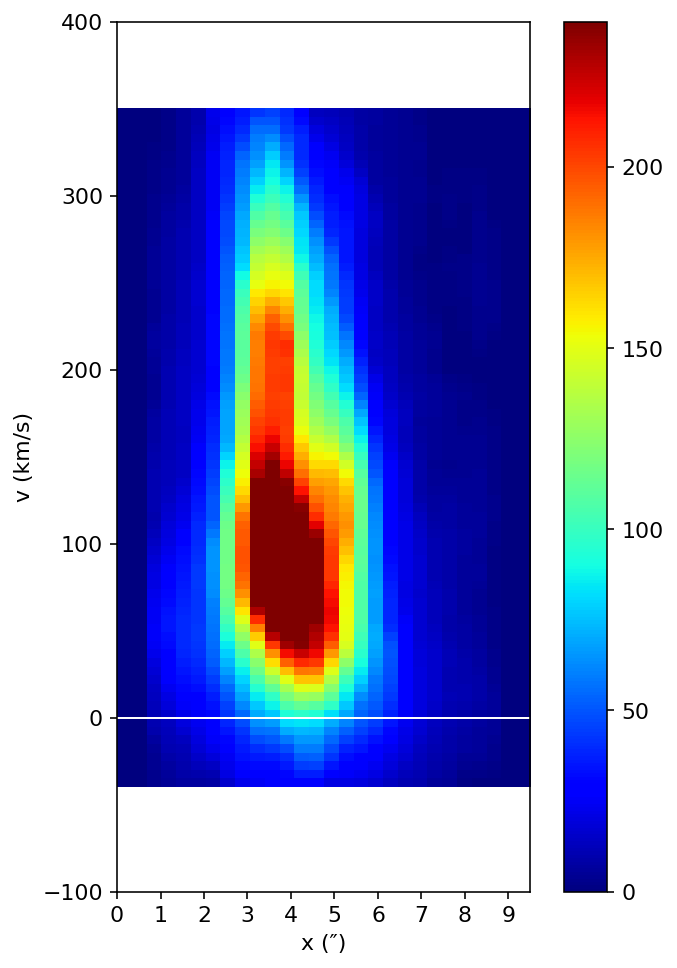

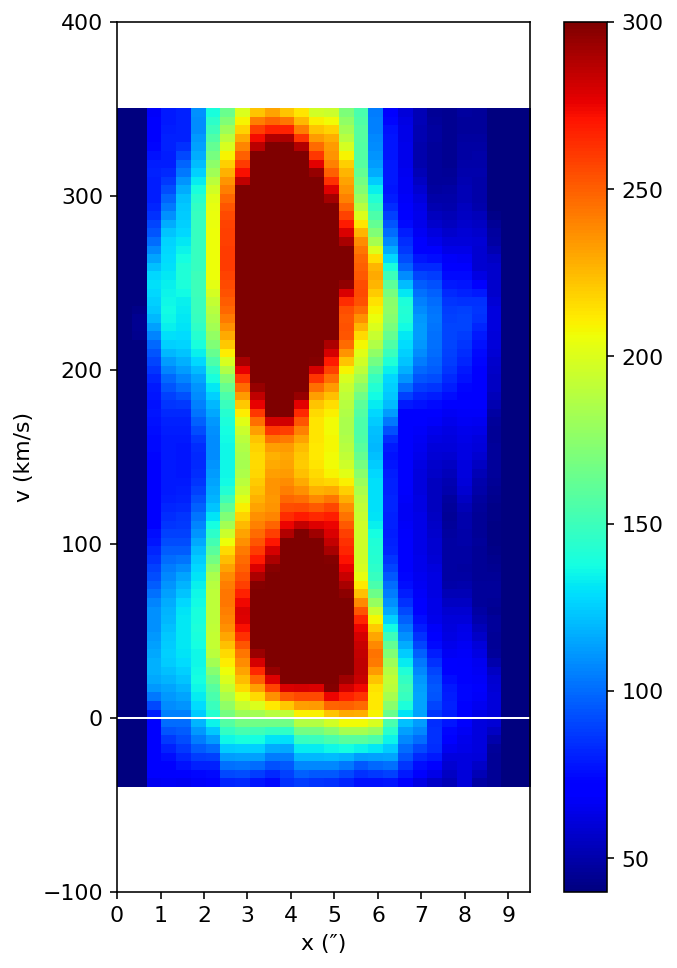

In [27]:
m_vvals, m_oiii , m_oii = match_grids(m_vvals, oiii, new_oii_vvals, new_oii)

minpix = 0
maxpix = 240
tick = (-100, 500, 100)

plot_new_vx_slice(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 40
maxpix = 300
tick = (-100, 500, 100)

plot_new_vx_slice(m_oii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

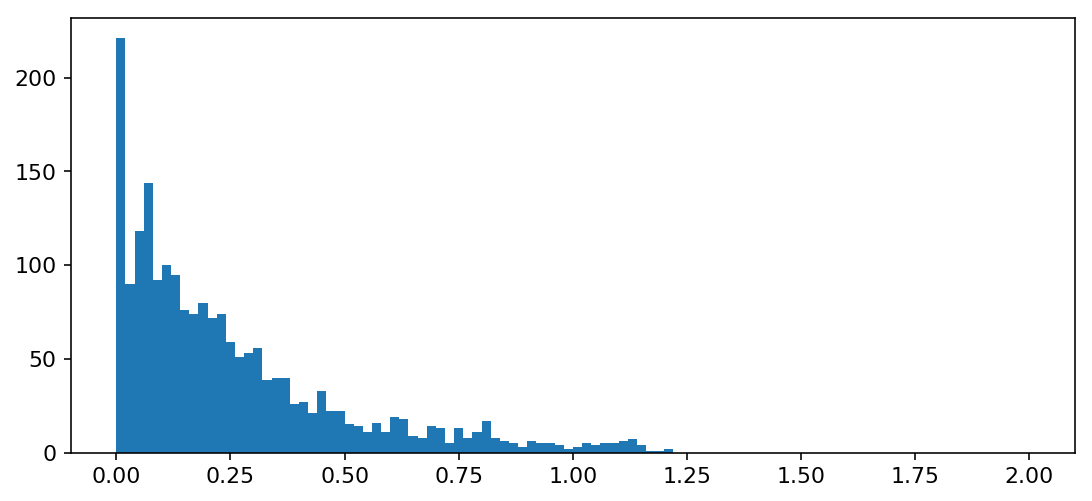

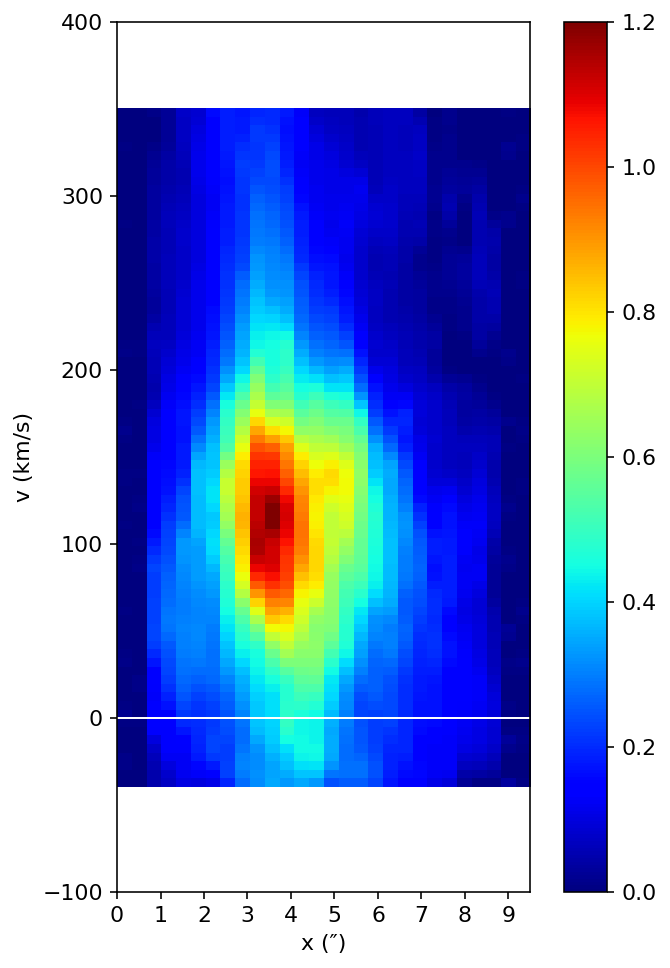

In [28]:
minpix = 0
maxpix = 1.2
tick = (-100, 500, 100)

oiii_oii = m_oiii / m_oii

plot_hist(oiii_oii[oiii_oii == oiii_oii], [0, 2])
plt.show() 

plot_new_vx_slice(oiii_oii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.6943999523248383, std = 2.0519495433430954


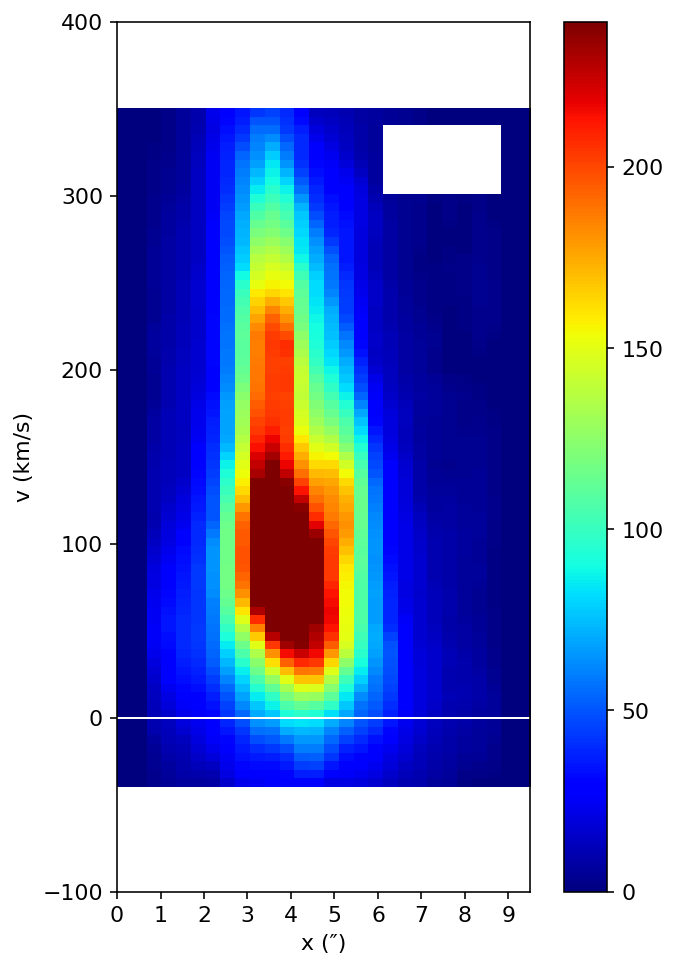

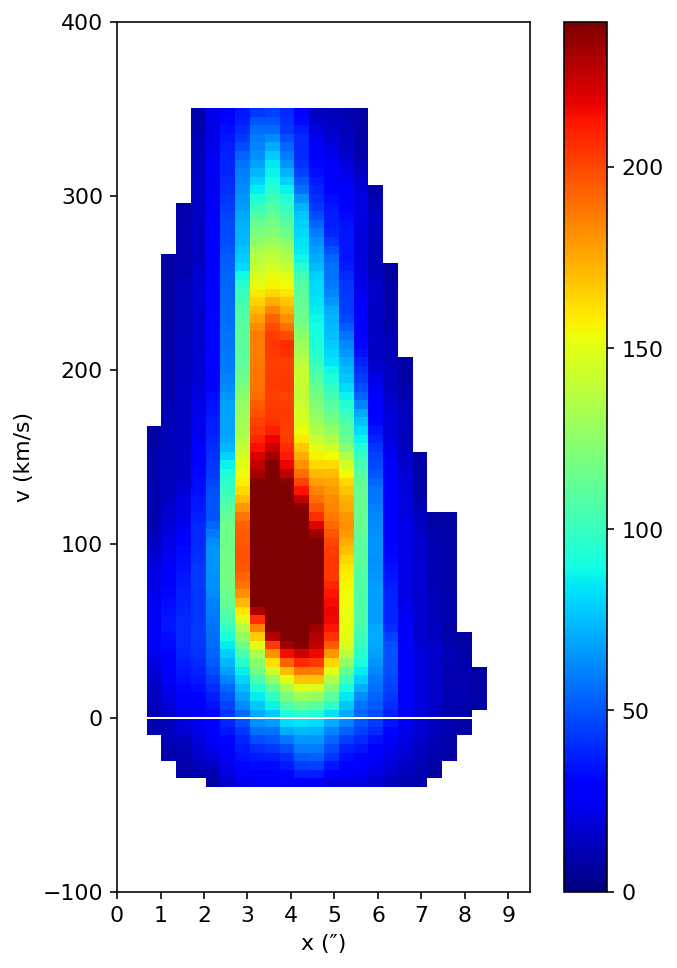

median = 47.0275985360264, std = 7.743933740057989


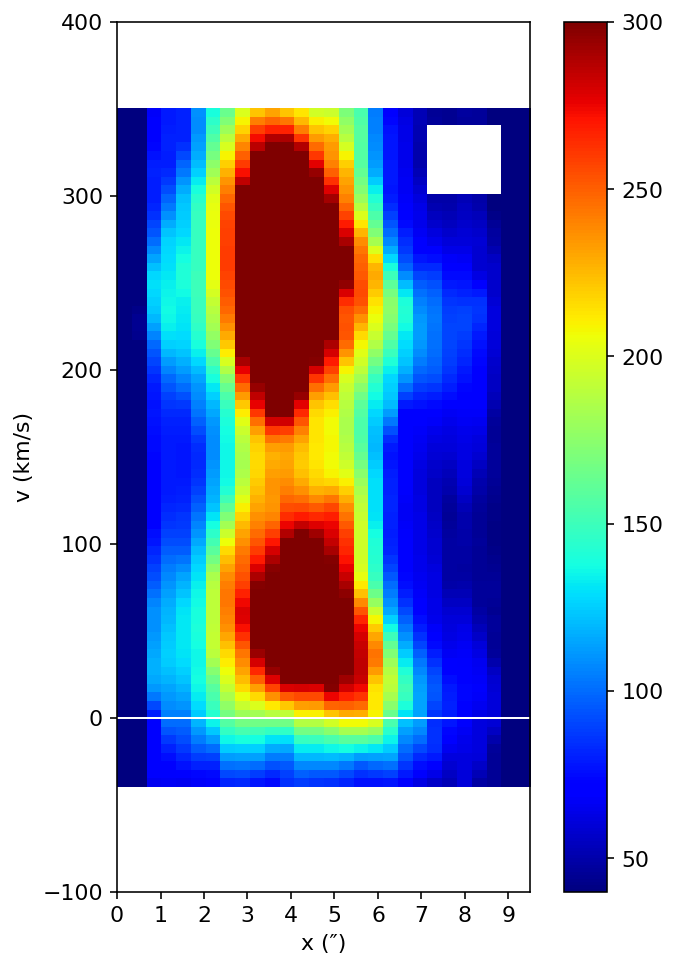

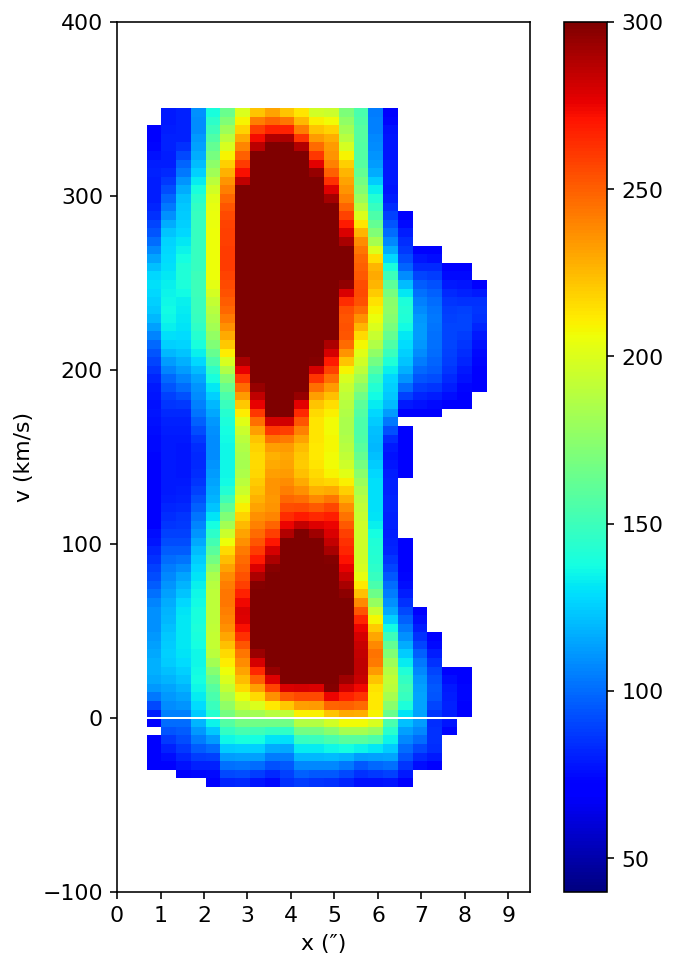

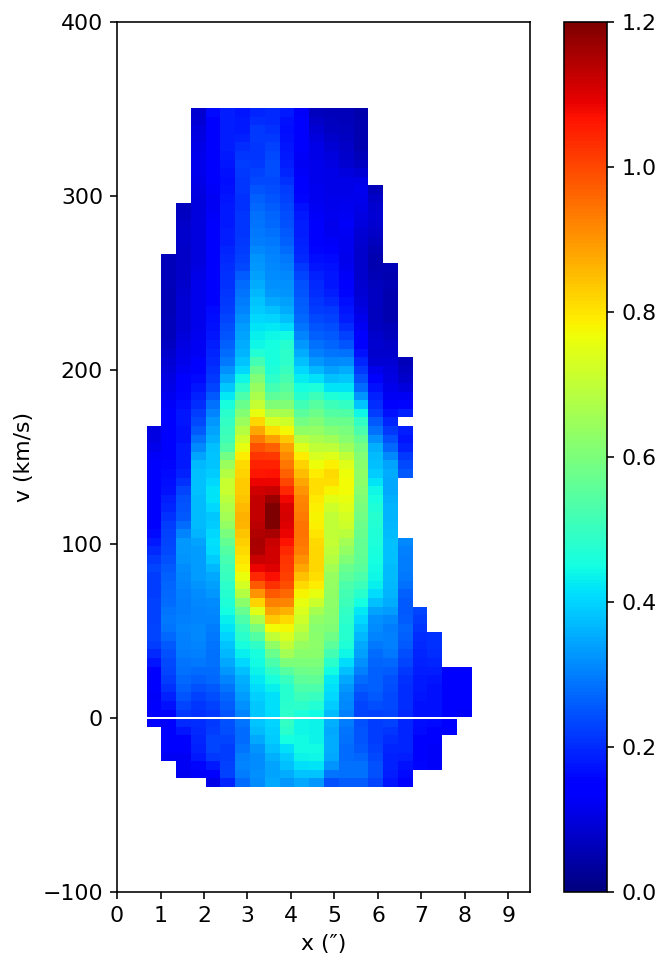

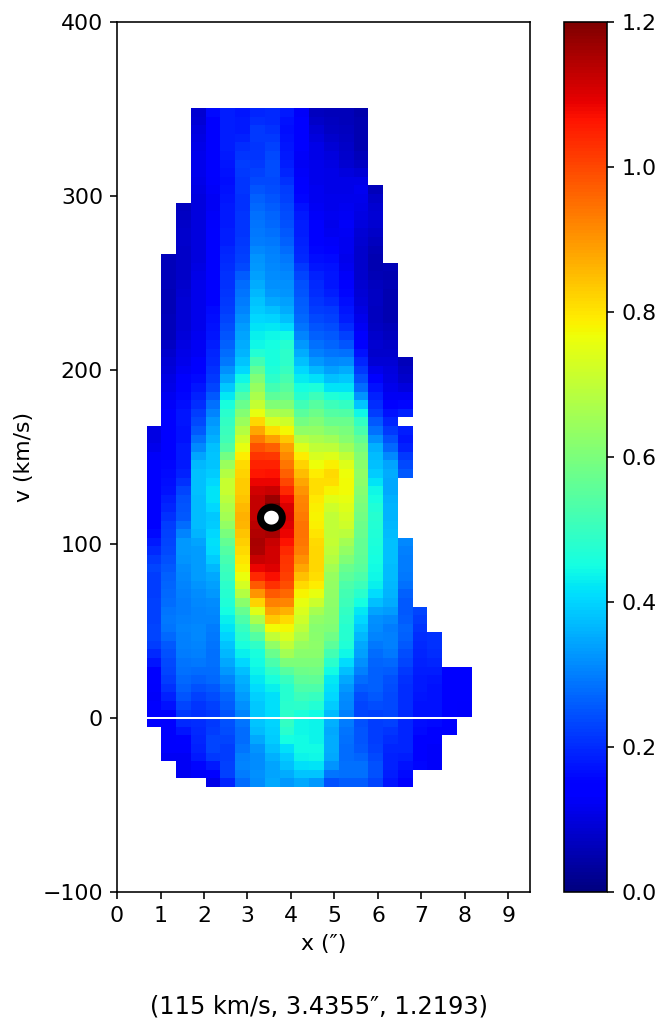

In [29]:
minpix = 0
maxpix = 240
tick = (-100, 500, 100)
m_oiiic = remove_noise(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 40
maxpix = 300
tick = (-100, 500, 100)
m_oiic = remove_noise(m_oii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3, (8,5))


oiii_oiic = m_oiiic / m_oiic

minpix = 0
maxpix = 1.2
tick = (-100, 500, 100)
plot_new_vx_slice(oiii_oiic, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, oiii_oiic, minpix, maxpix, tick)

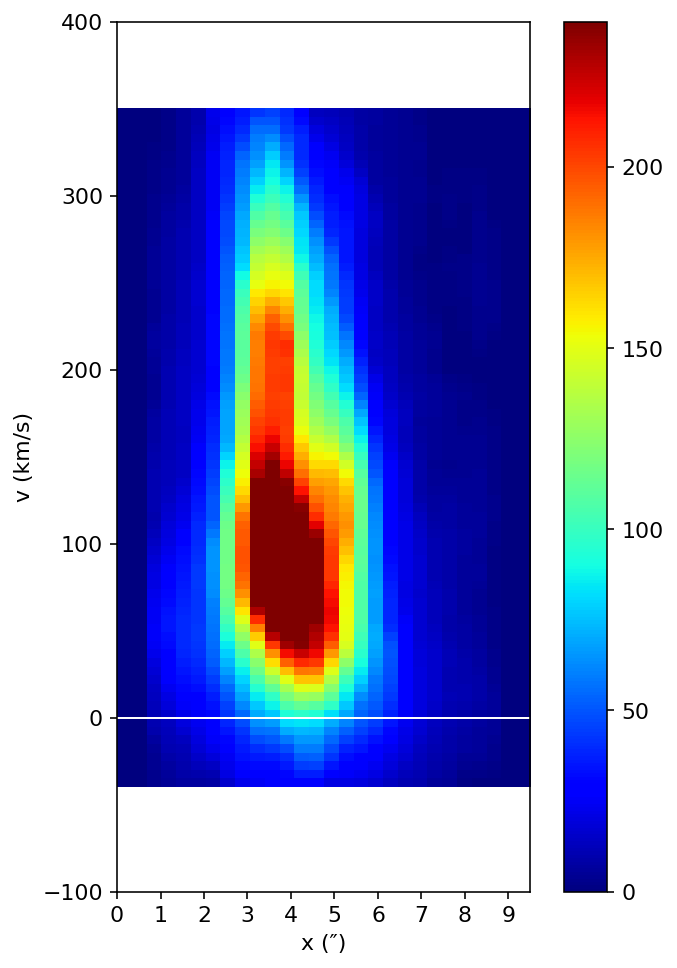

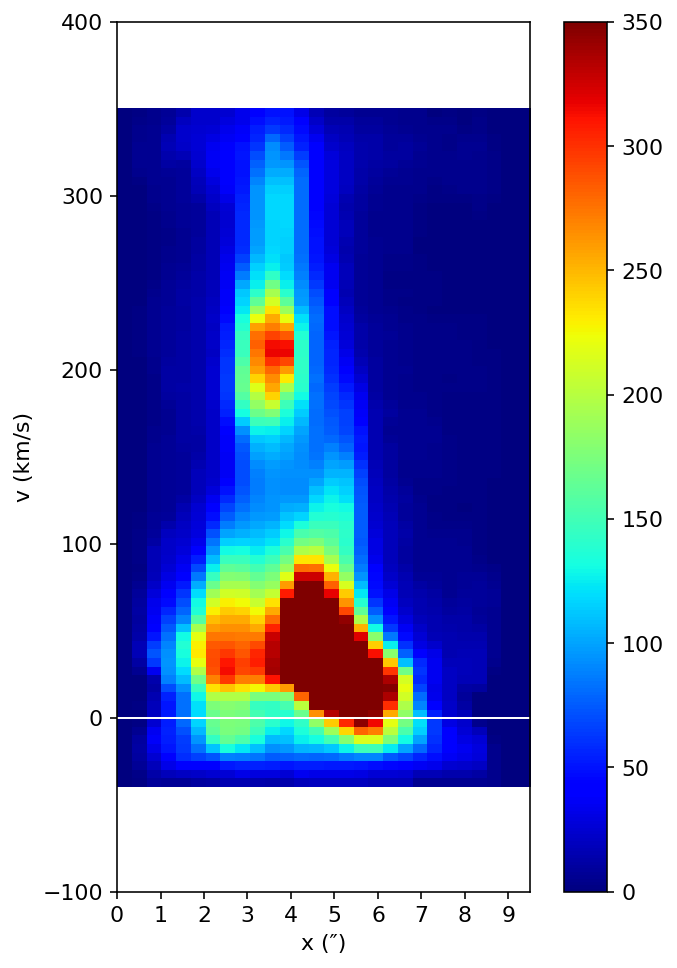

In [30]:
m_vvals, m_oiii , m_oi = match_grids(oiii_vvals, oiii, new_oi_vvals, new_oi)

minpix = 0
maxpix = 240
tick = (-100, 500, 100)

plot_new_vx_slice(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 0
maxpix = 350
tick = (-100, 500, 100)

plot_new_vx_slice(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

In [31]:
oiii_oiic

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

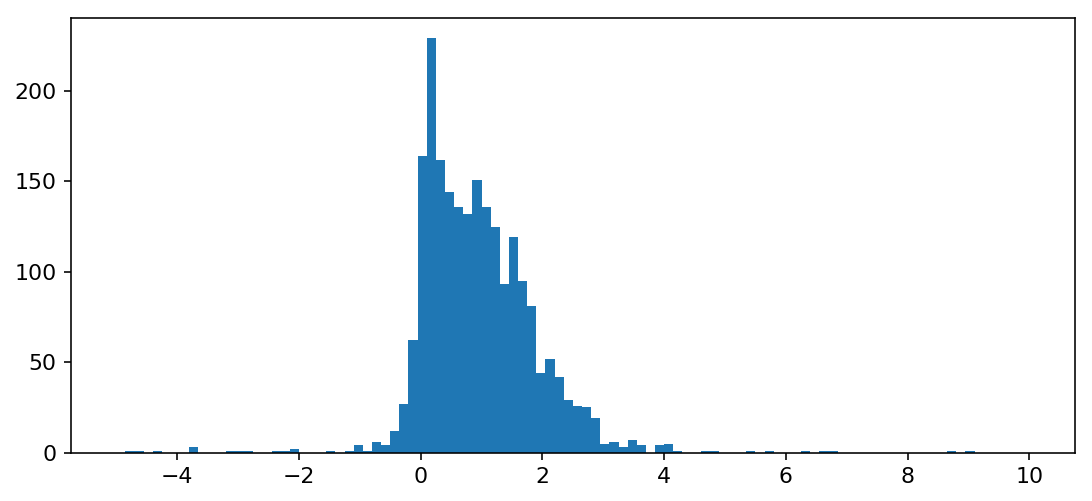

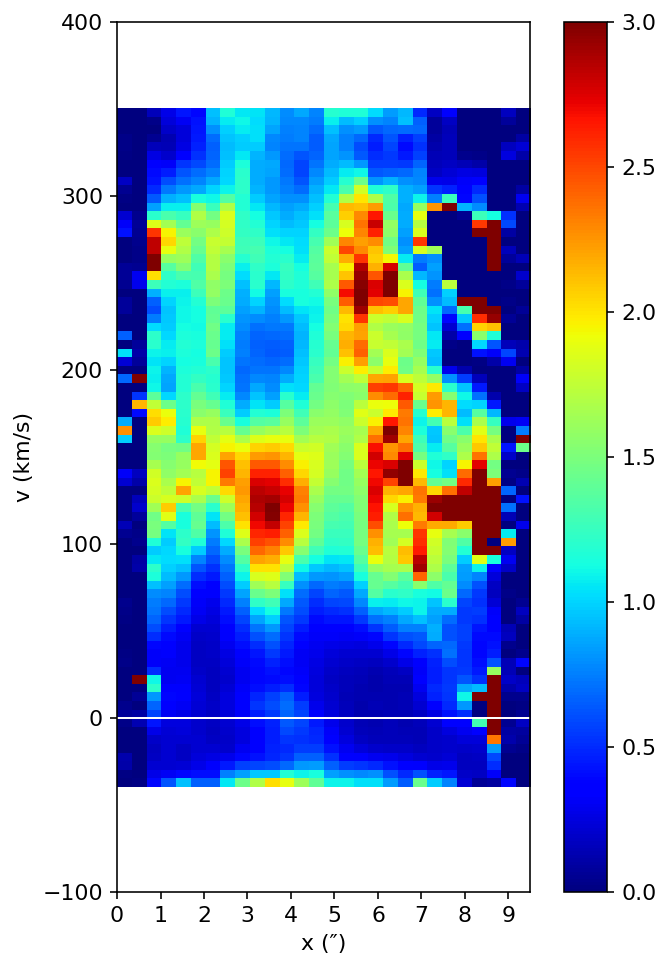

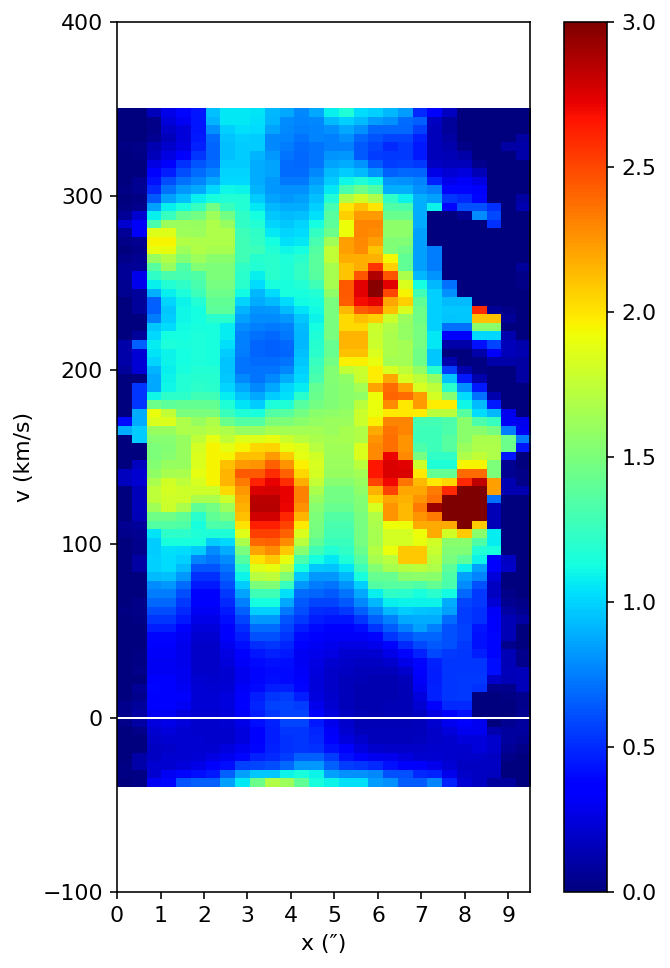

In [32]:
minpix = 0
maxpix = 3
tick = (-100, 500, 100)

oiii_oi = m_oiii / m_oi

plot_hist(oiii_oi[oiii_oi == oiii_oi], [-5, 10])
plt.show() 

plot_new_vx_slice(oiii_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

for i in range(len(oiii_oi)):
    for j in range(len(oiii_oi[0])):
        if oiii_oi[i][j] > 5:
            oiii_oi[i][j] = 0

oiii_oi_med = ndimage.median_filter(oiii_oi, 3)
plot_new_vx_slice(oiii_oi_med, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.6943999523248383, std = 2.0519495433430954


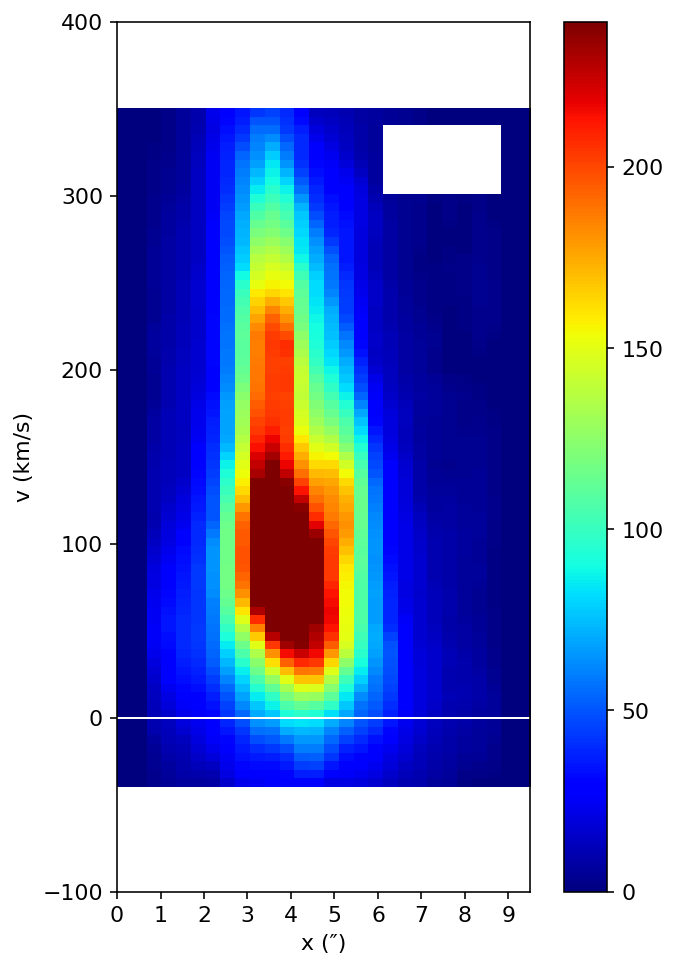

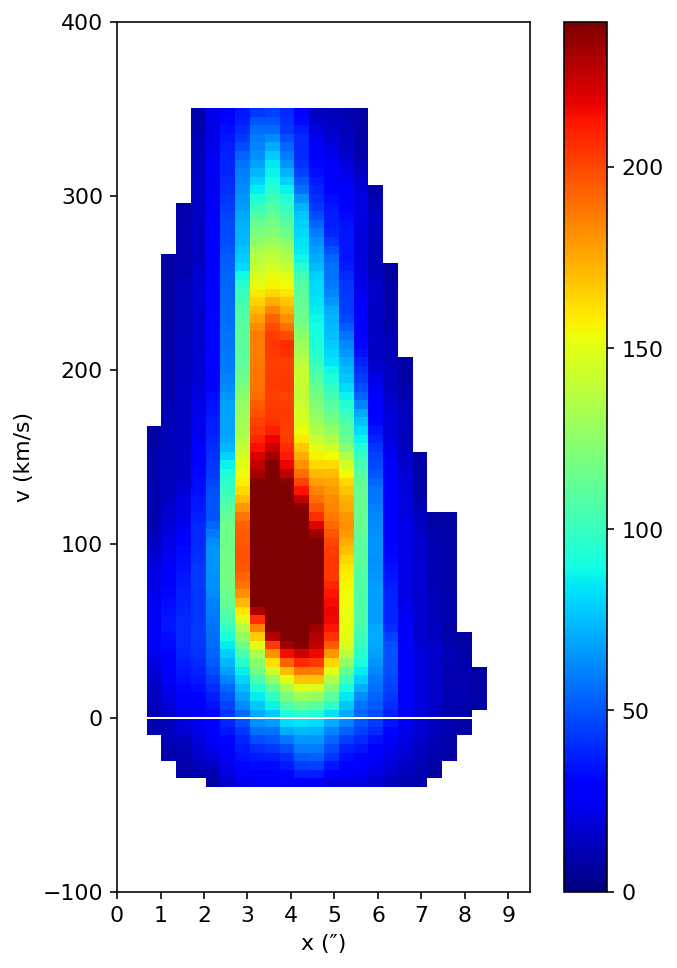

median = 4.702345644744135, std = 2.0164223541536264


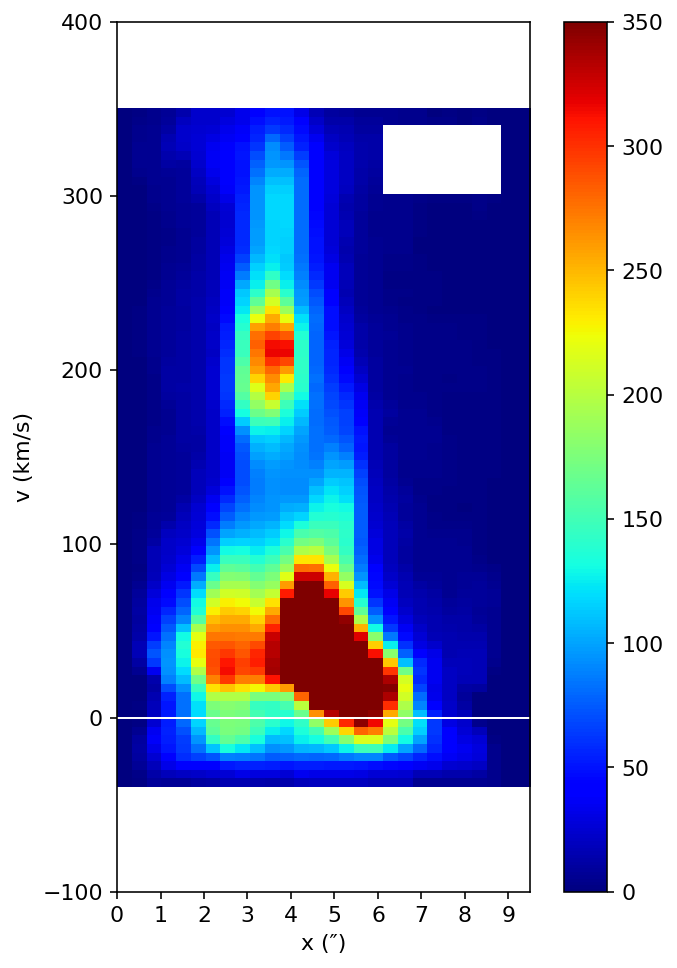

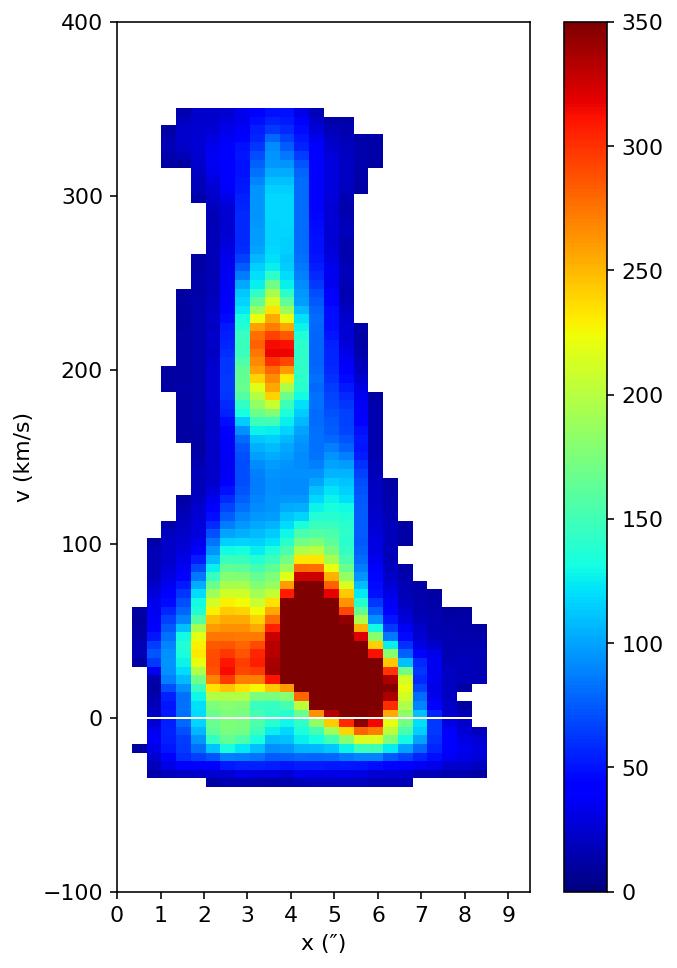

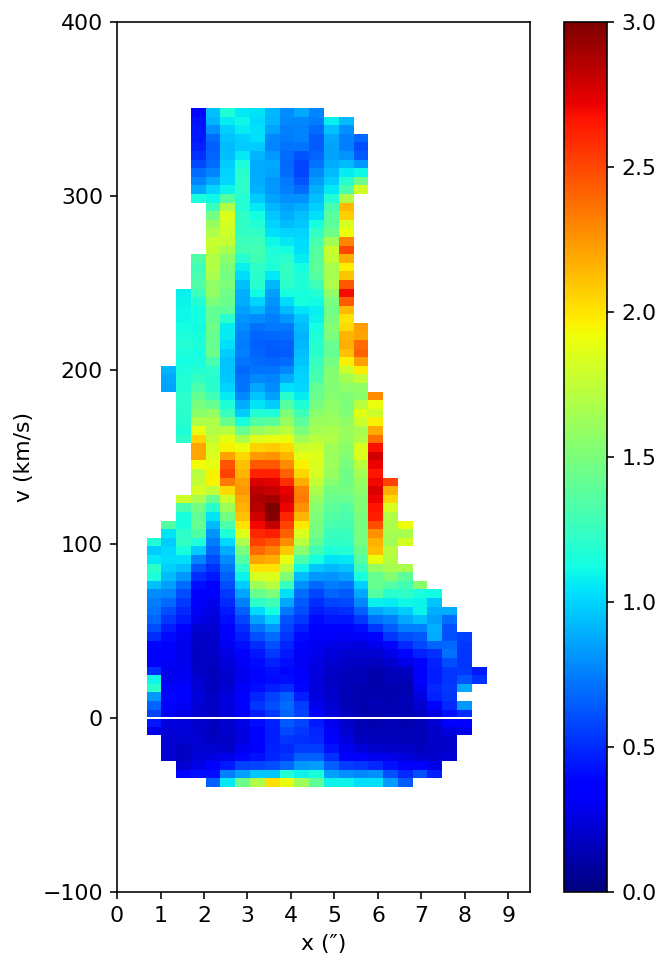

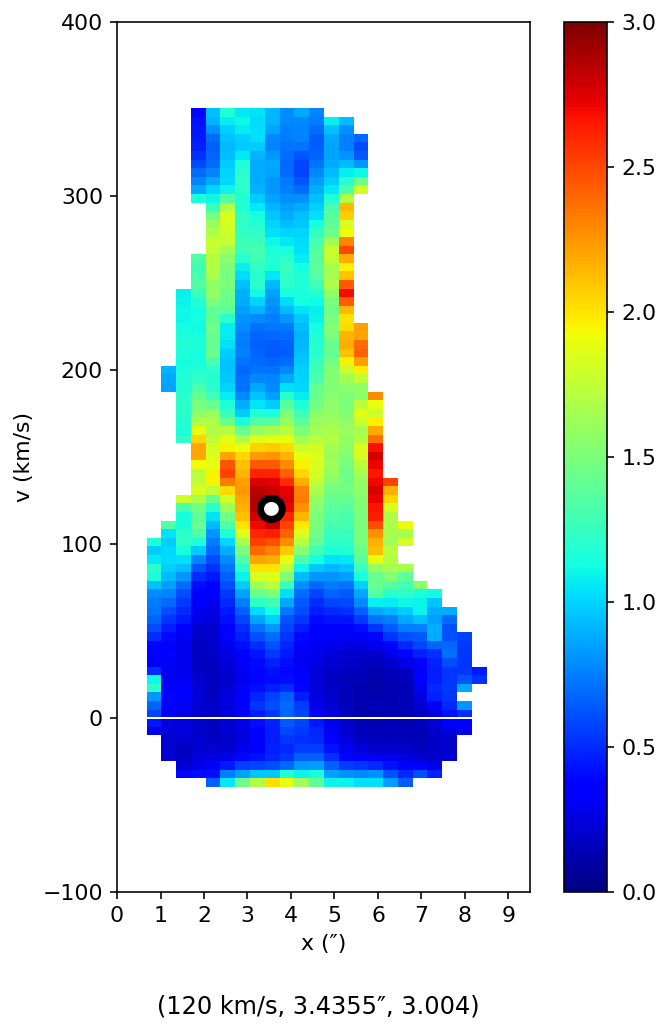

In [33]:
minpix = 0
maxpix = 240
tick = (-100, 500, 100)
m_oiiic = remove_noise(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 0
maxpix = 350
tick = (-100, 500, 100)
m_oic = remove_noise(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

oiii_oic = m_oiiic / m_oic

minpix = 0
maxpix = 3
tick = (-100, 500, 100)
plot_new_vx_slice(oiii_oic, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, oiii_oic, minpix, maxpix, tick)

v_low = -323.6201047348193, v_high = 380.64870068596036, aspect = 0.025


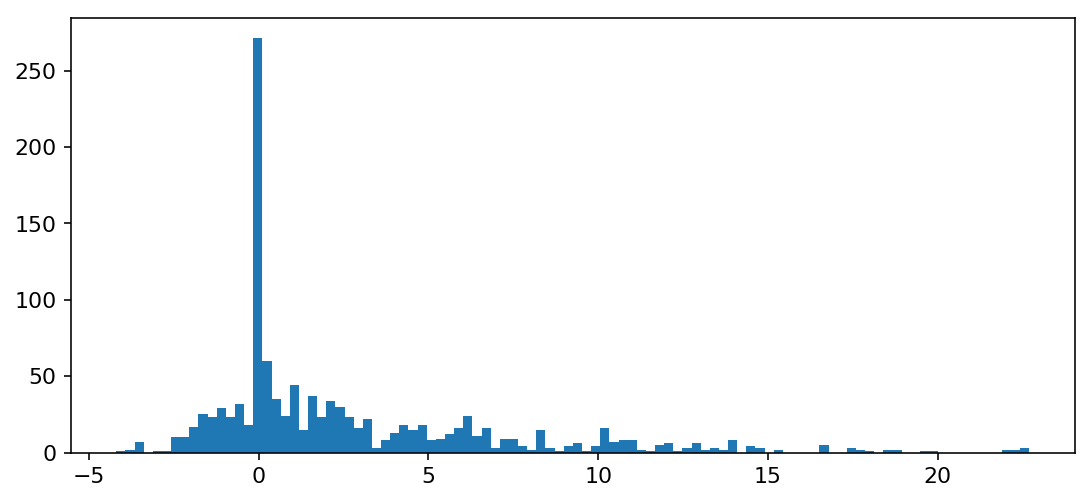

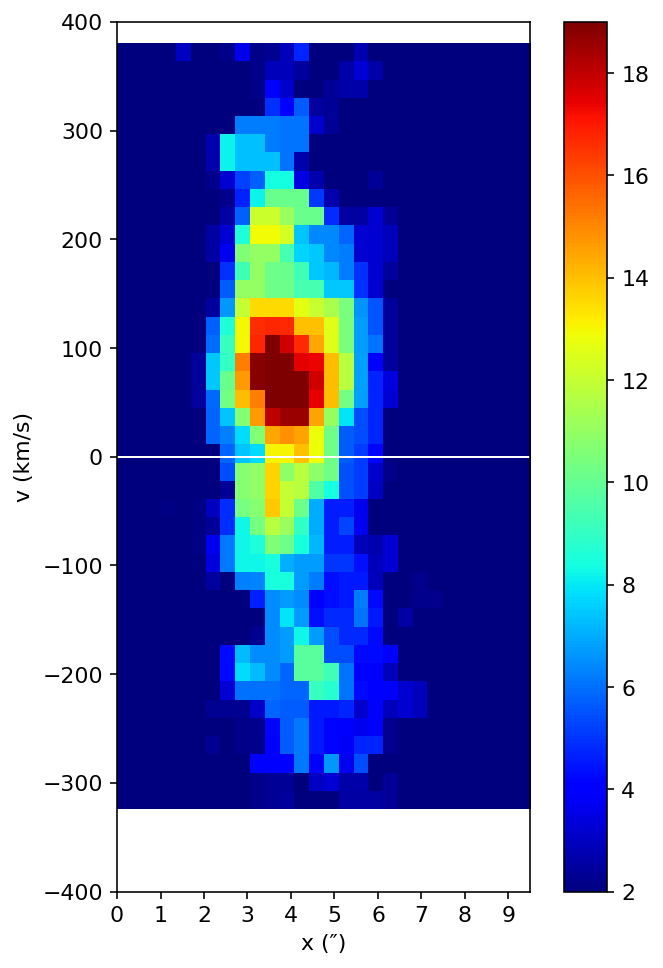

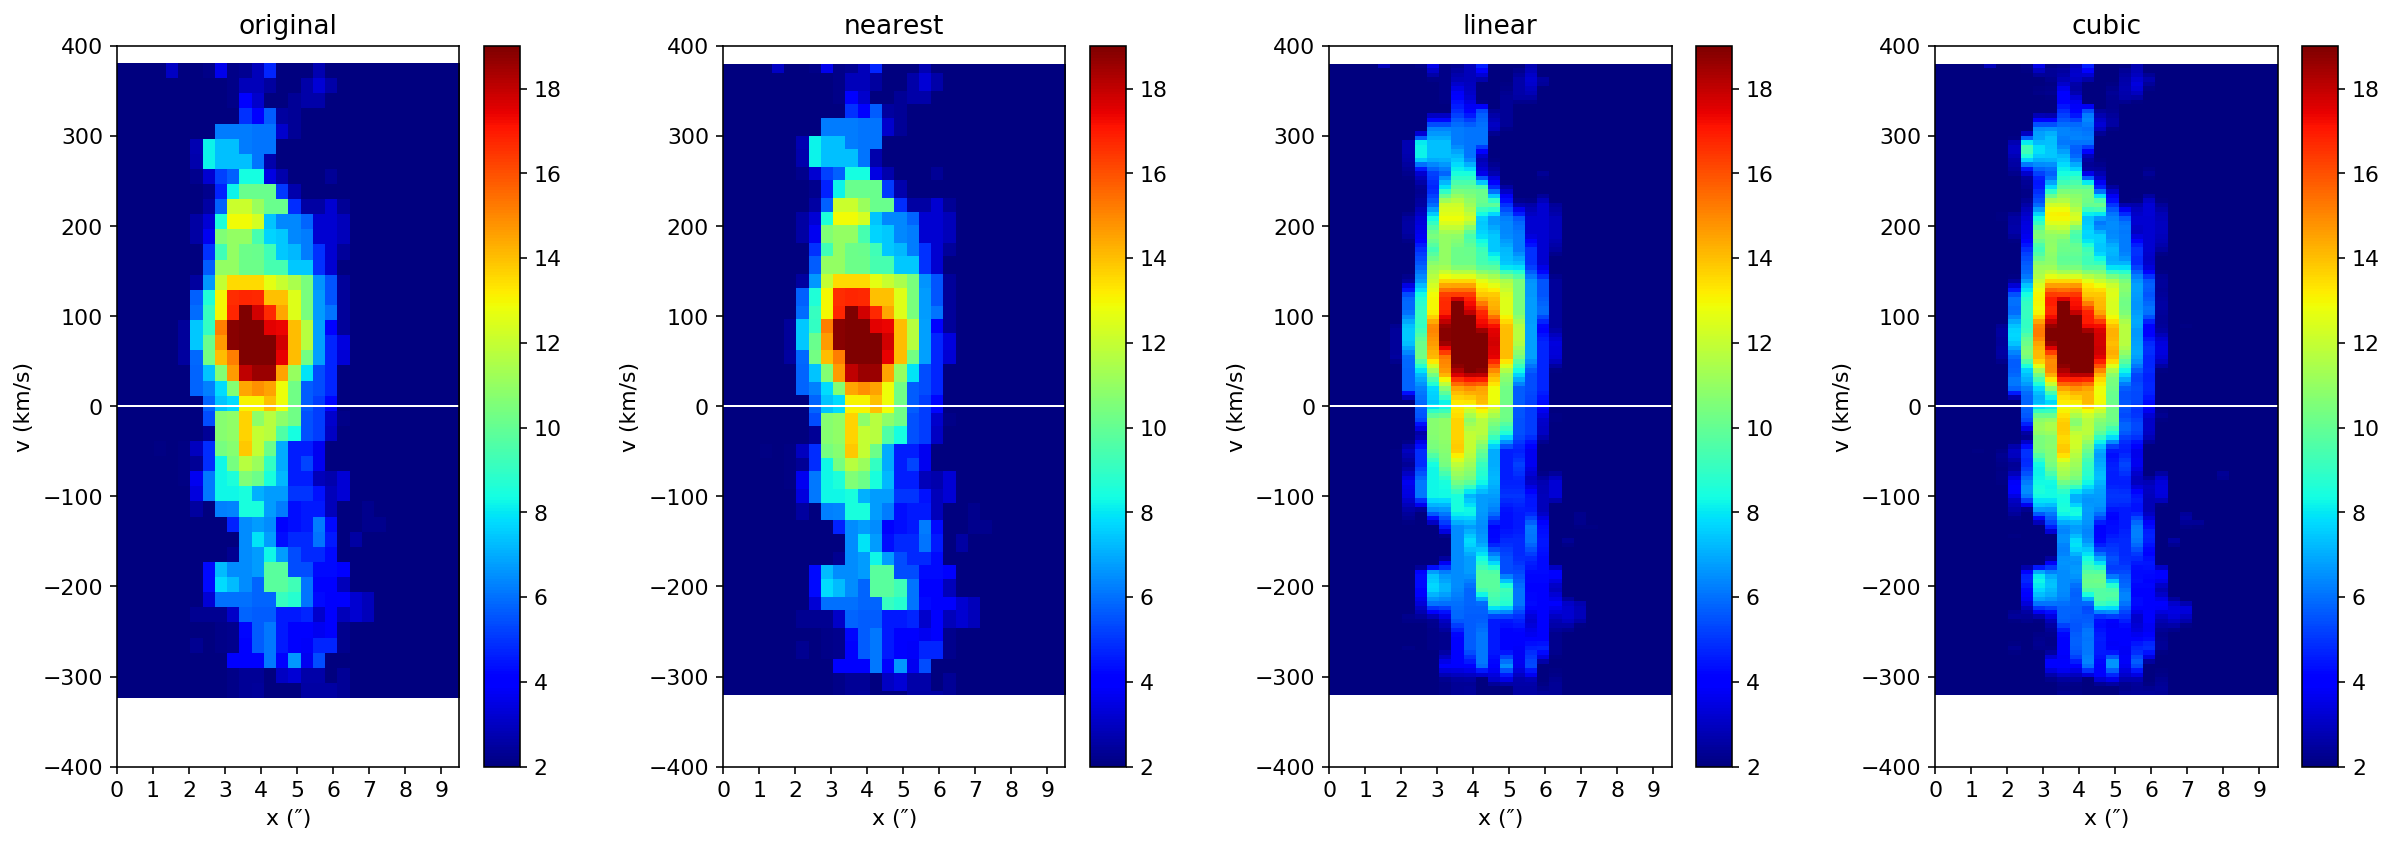

In [34]:
center = 4363.21
low = 4358.50 
high = 4368.75

minpix = 2
maxpix = 19
tick = (-400, 500, 100)
color = "green"

oiii2_vvals, oiii2 = plot_vx_slice(center, low, high, minpix, maxpix, tick, color)
plt.show()

new_oiii2_vvals, new_oiii2 = test_grid_methods(oiii2_vvals, oiii2, minpix, maxpix, tick)
plt.show()

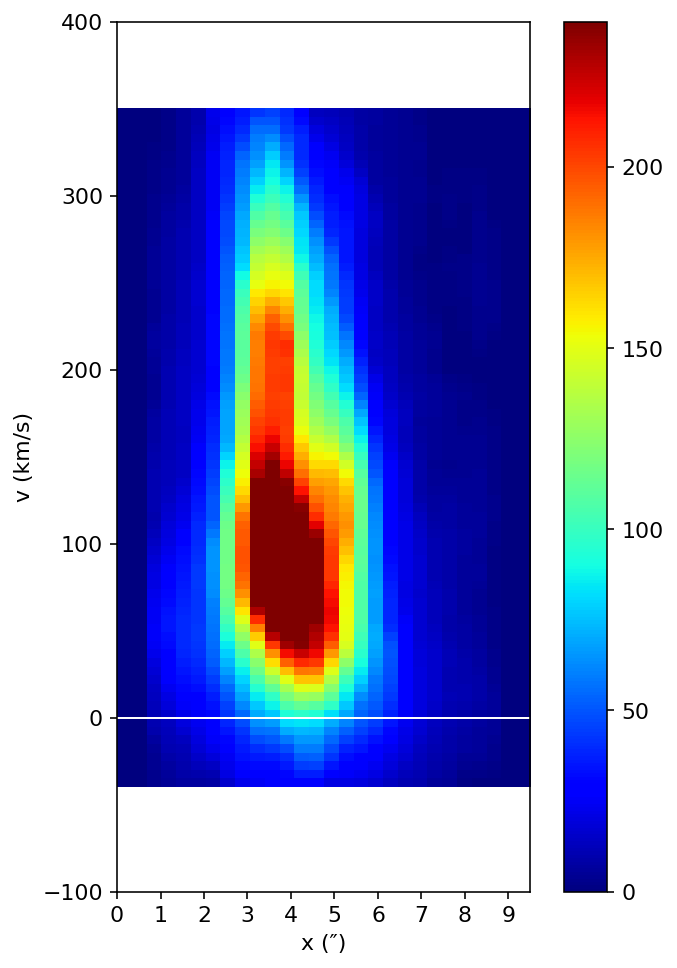

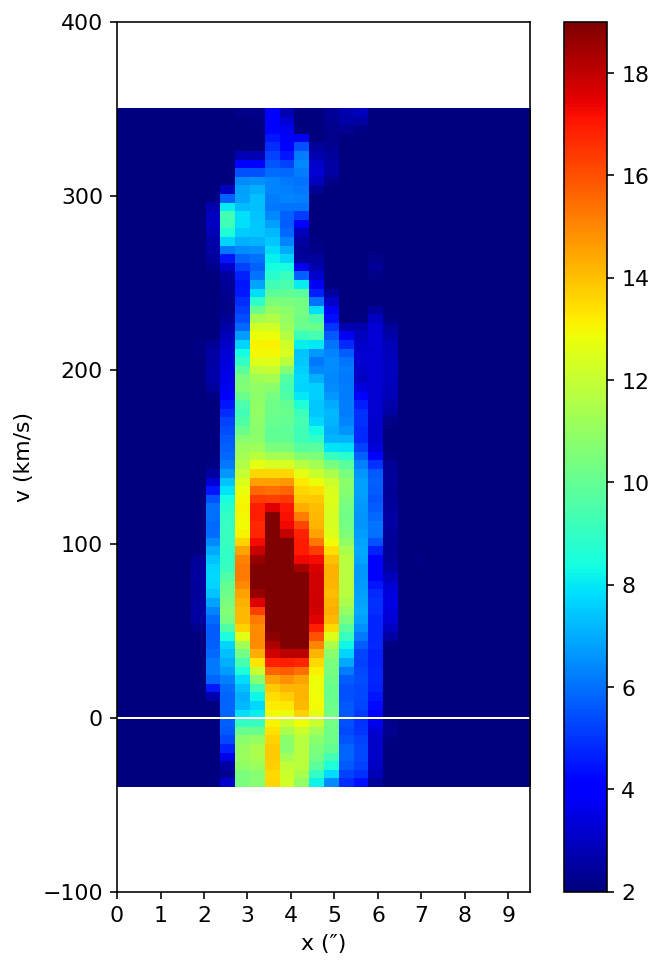

In [35]:
m_vvals, m_oiii , m_oiii2 = match_grids(oiii_vvals, oiii, new_oiii2_vvals, new_oiii2)

minpix = 0
maxpix = 240
tick = (-100, 500, 100)

plot_new_vx_slice(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 2
maxpix = 19
tick = (-100, 500, 100)

plot_new_vx_slice(m_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.6943999523248383, std = 2.0519495433430954


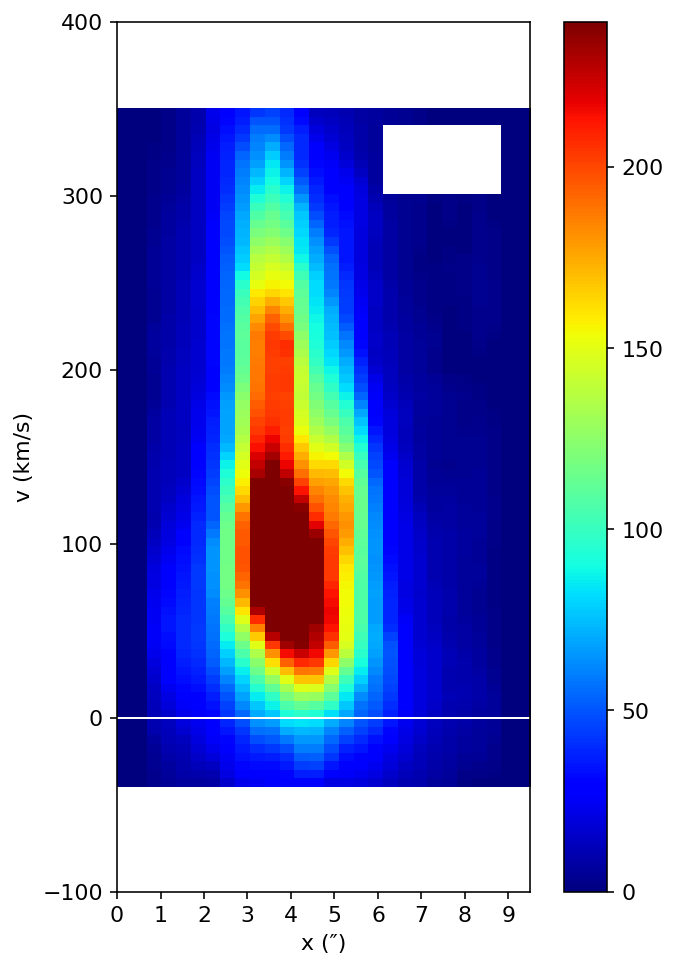

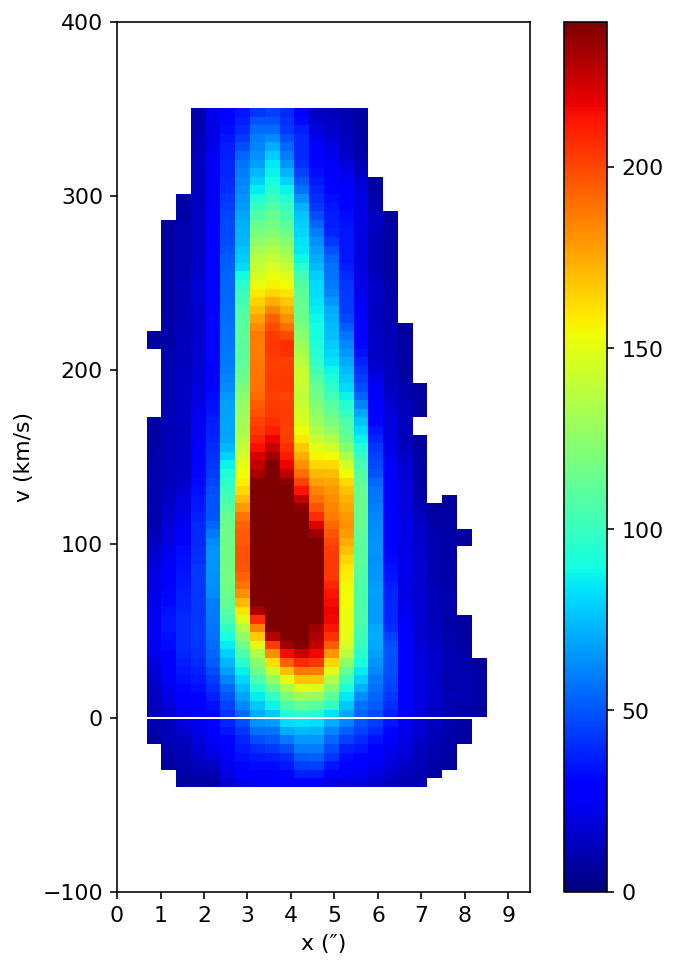

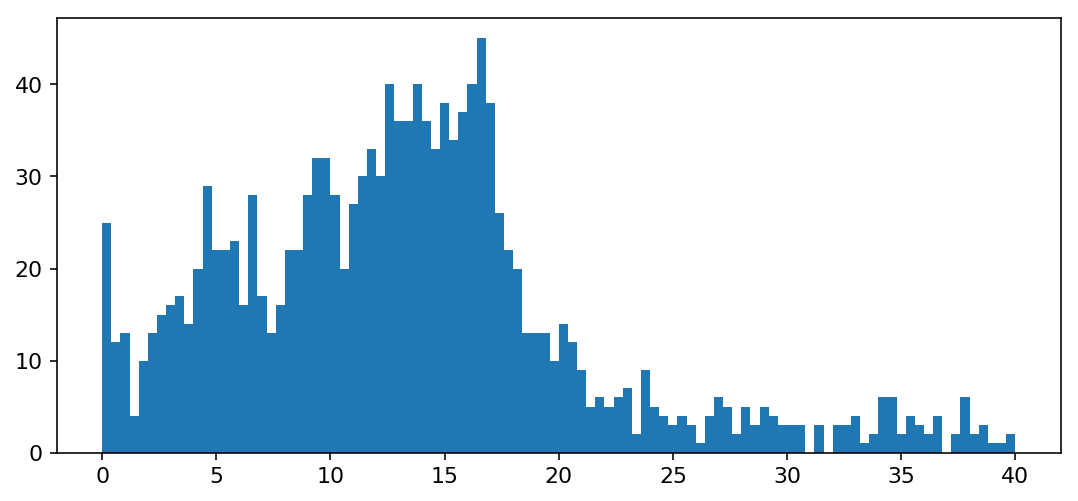

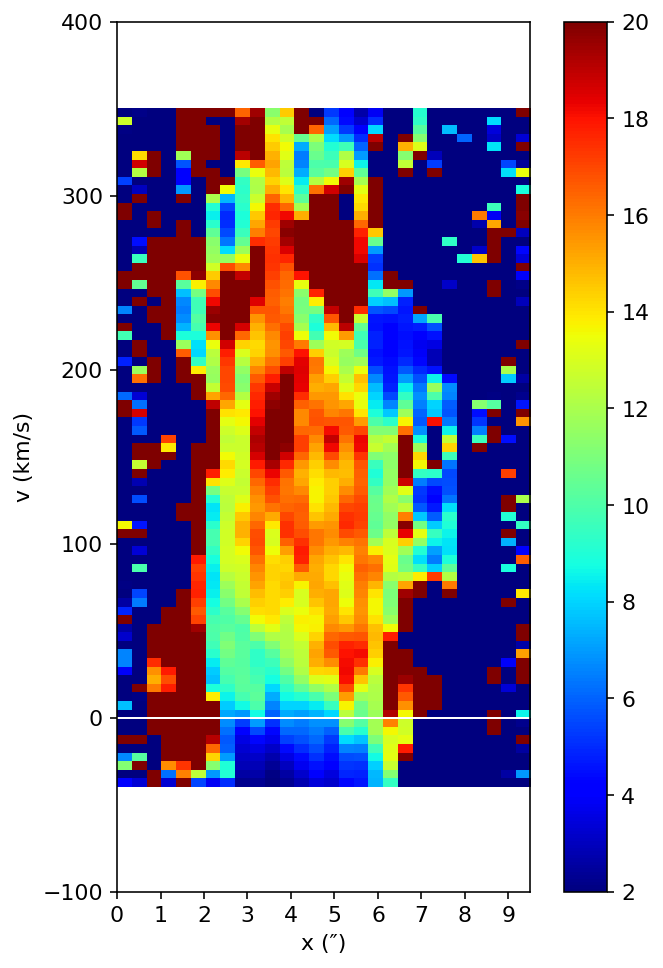

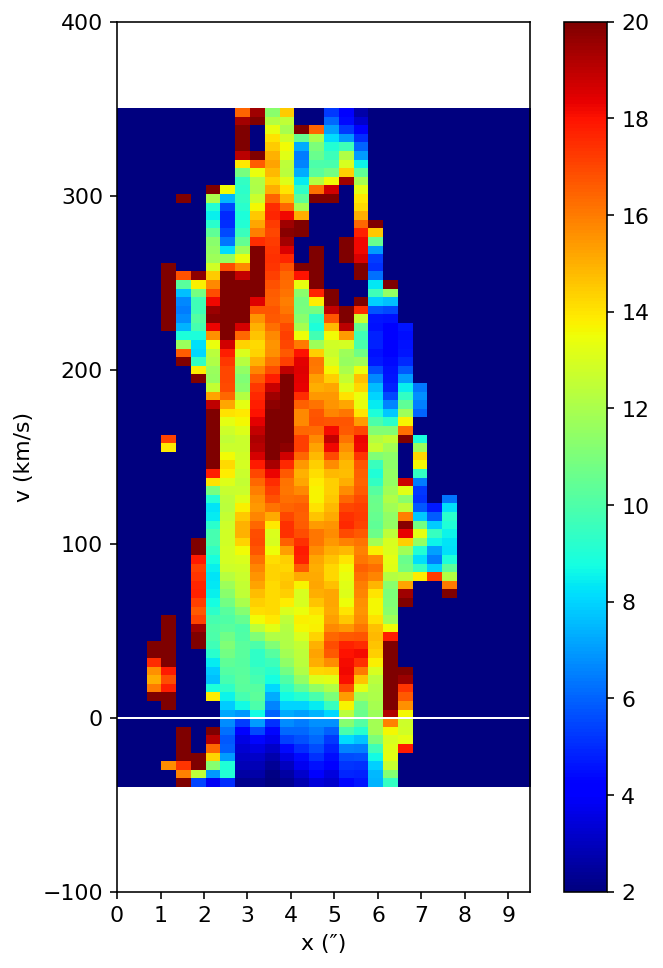

In [36]:
minpix = 0
maxpix = 240
tick = (-100, 500, 100)
m_oiiic = remove_noise(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 2.5)

minpix = 2
maxpix = 20
tick = (-100, 500, 100)

oiii_oiii2 = m_oiii / m_oiii2

plot_hist(oiii_oiii2[oiii_oiii2 == oiii_oiii2], [0, 40])
plt.show() 

plot_new_vx_slice(oiii_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

for i in range(len(oiii_oiii2)):
    for j in range(len(oiii_oiii2[0])):
        if oiii_oiii2[i][j] > 30 or m_oiiic[i][j] != m_oiiic[i][j]:
            oiii_oiii2[i][j] = 0
            
        
plot_new_vx_slice(oiii_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.6943999523248383, std = 2.0519495433430954


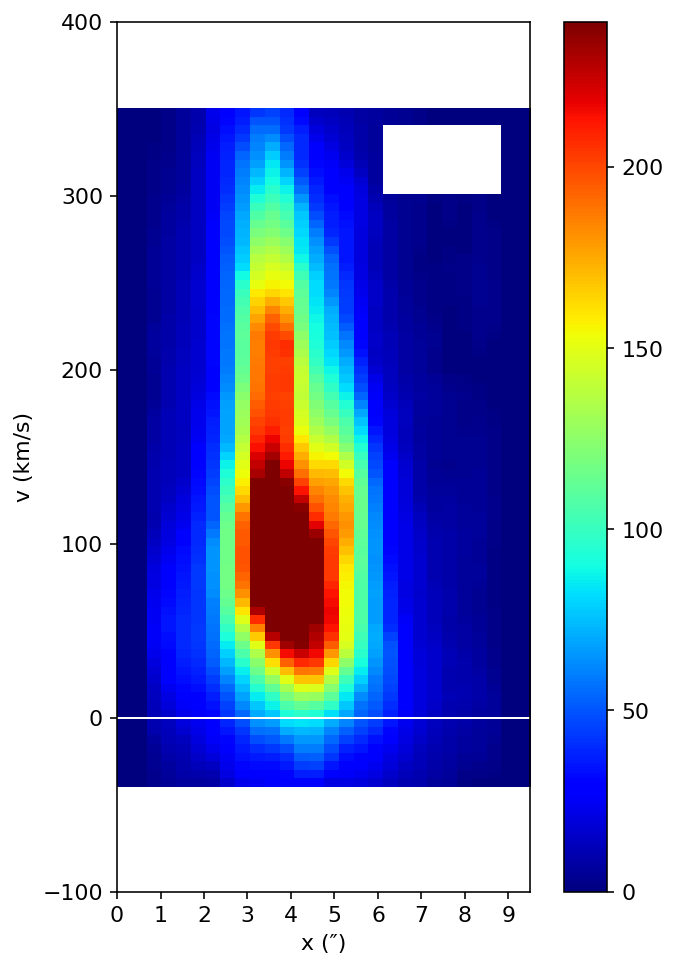

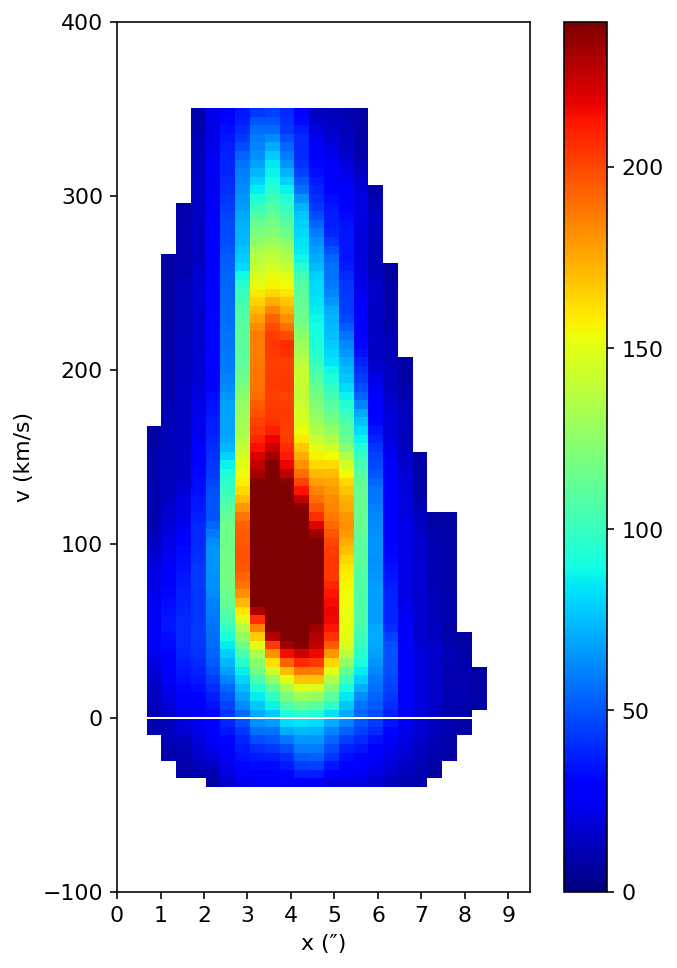

median = 0.254172642667072, std = 0.5427366519183815


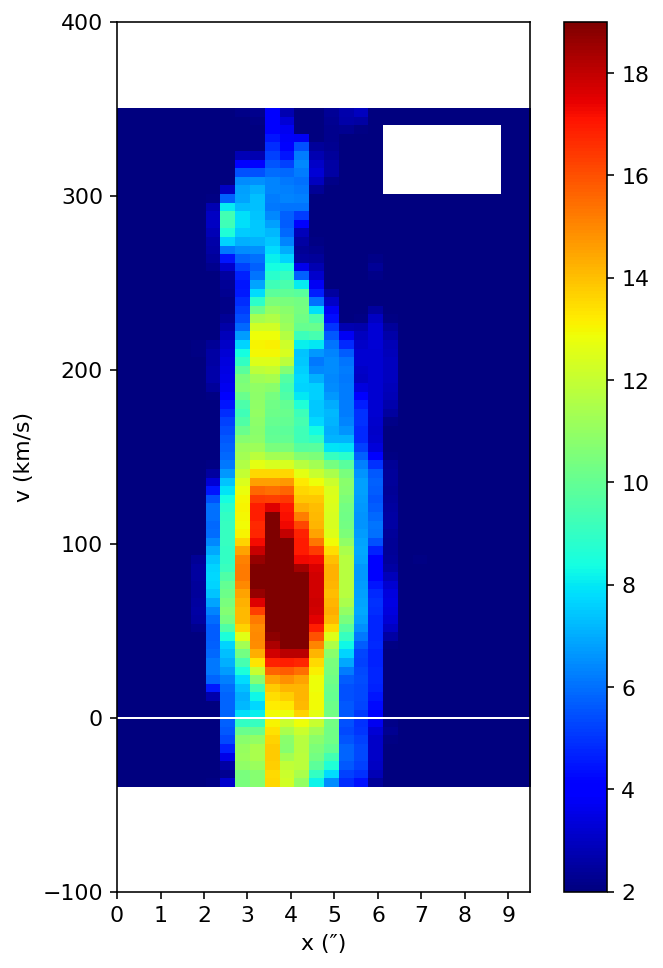

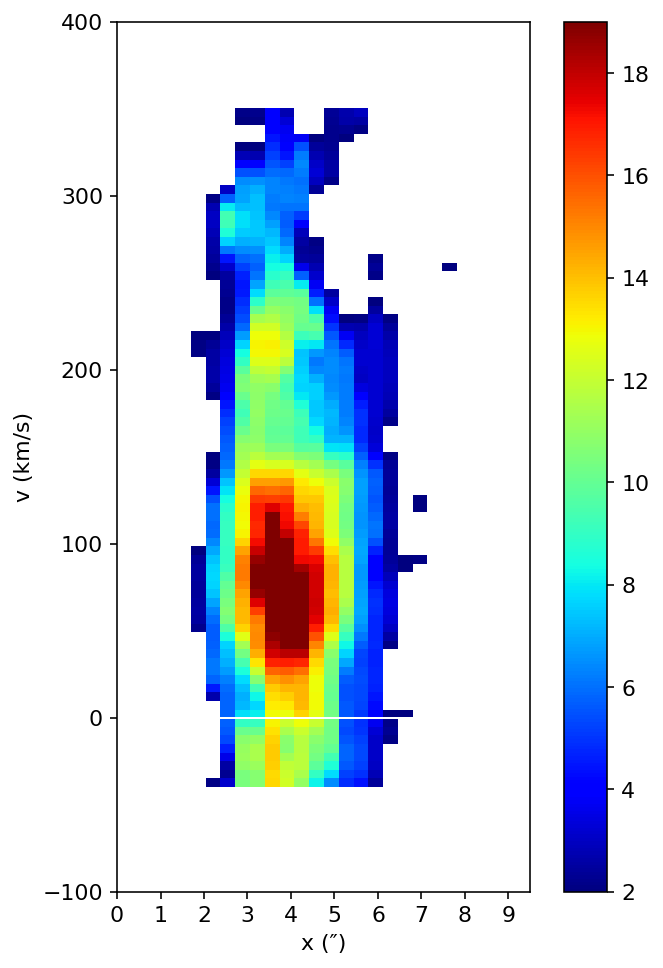

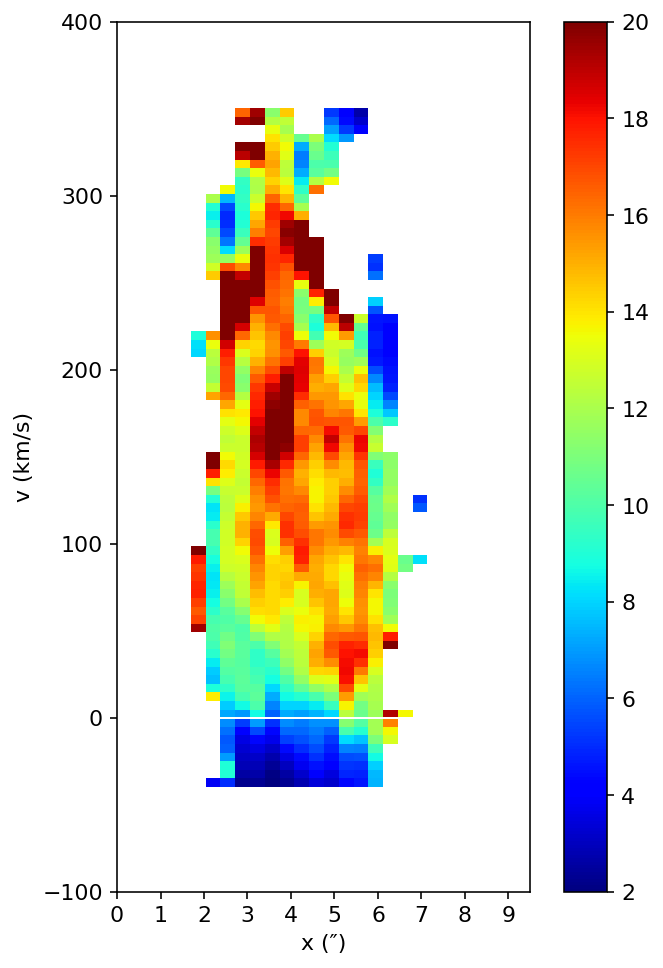

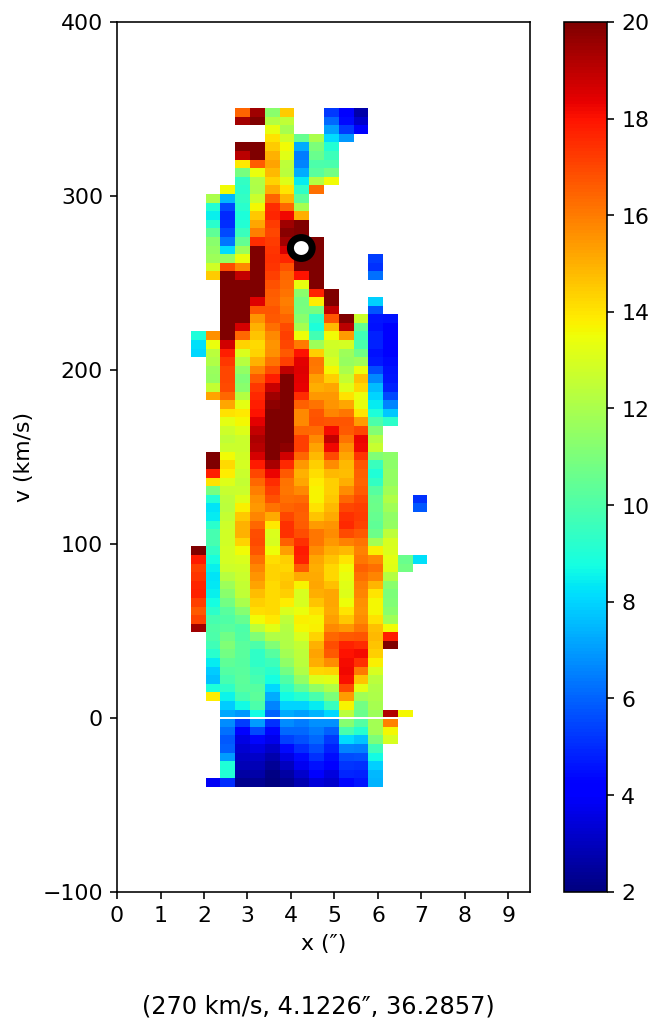

In [37]:
minpix = 0
maxpix = 240
tick = (-100, 500, 100)
m_oiiic = remove_noise(m_oiii, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 2
maxpix = 19
tick = (-100, 500, 100)
m_oiii2c = remove_noise(m_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)


oiii_oiii2c = m_oiiic / m_oiii2c

minpix = 2
maxpix = 20
tick = (-100, 500, 100)
plot_new_vx_slice(oiii_oiii2c, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, oiii_oiii2c, minpix, maxpix, tick)

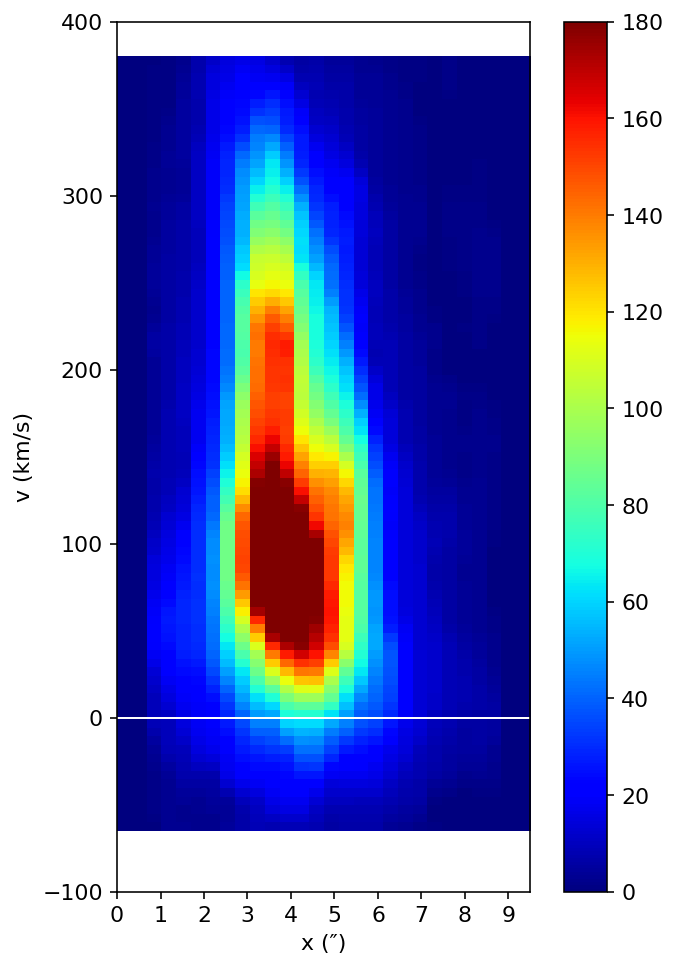

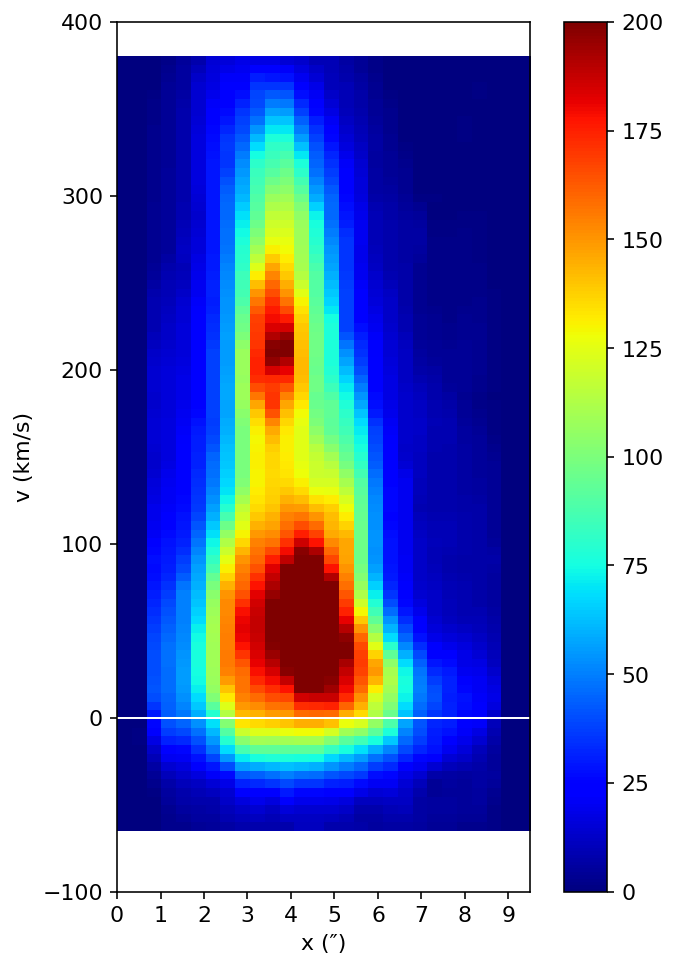

In [38]:
m_vvals, m_s5007 , m_hbeta = match_grids(new_s5007_vvals, new_s5007, new_hbeta_vvals, new_hbeta)

minpix = 0
maxpix = 180
tick = (-100, 500, 100)

plot_new_vx_slice(m_s5007, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 0
maxpix = 200
tick = (-100, 500, 100)

plot_new_vx_slice(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.4591766050551098, std = 1.2174052328094347


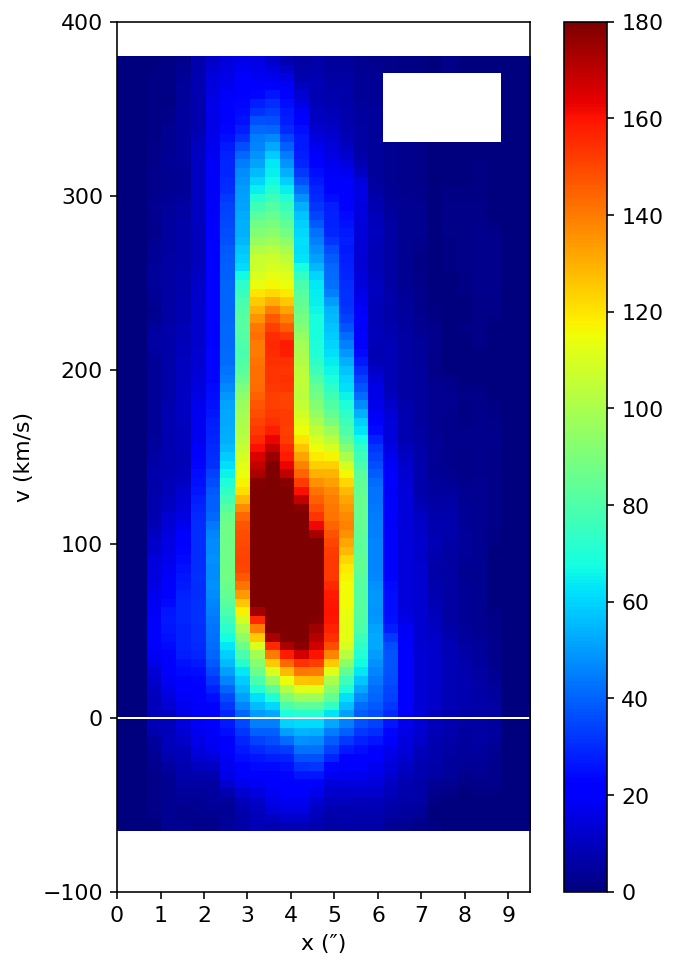

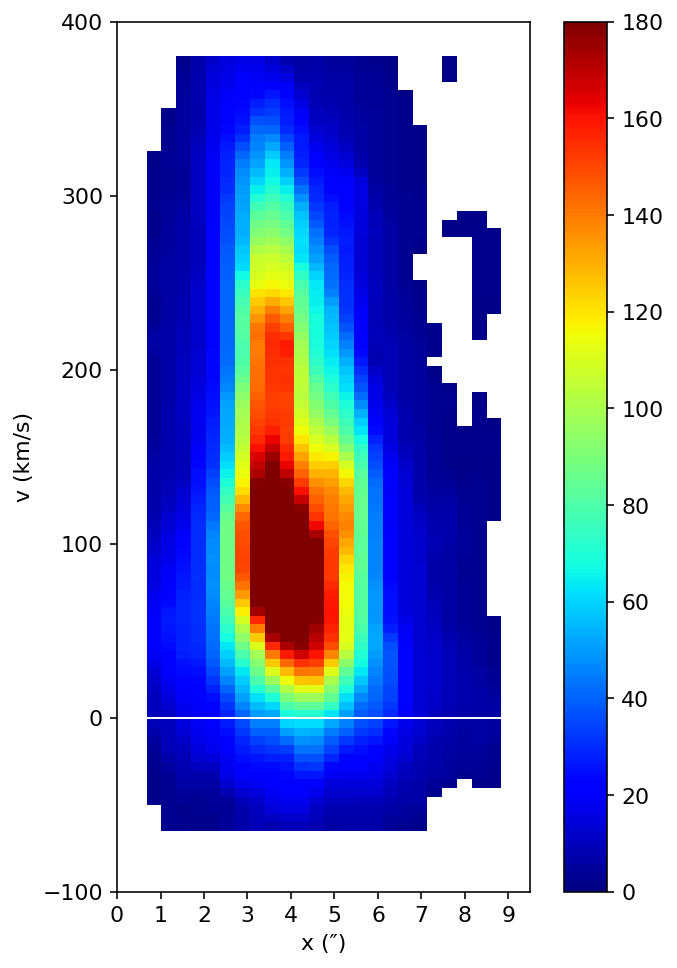

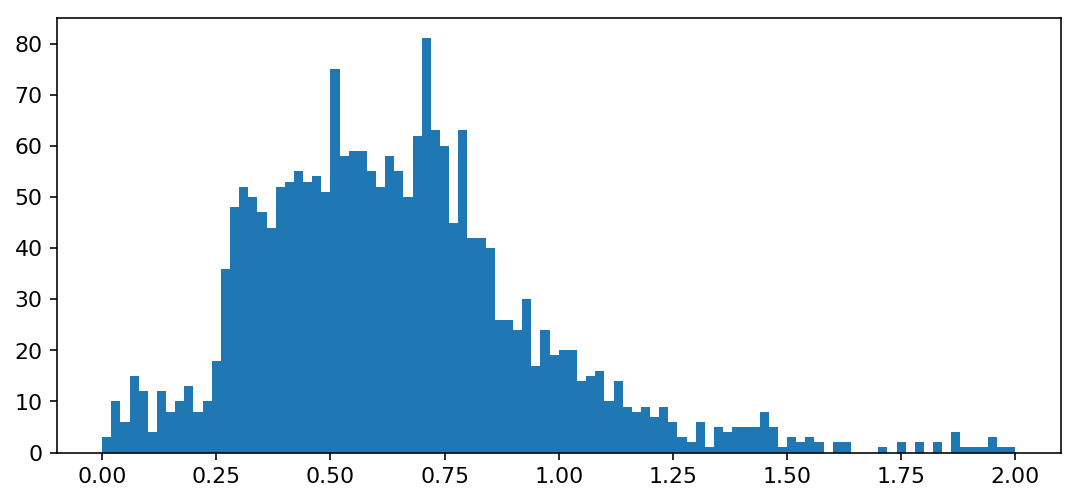

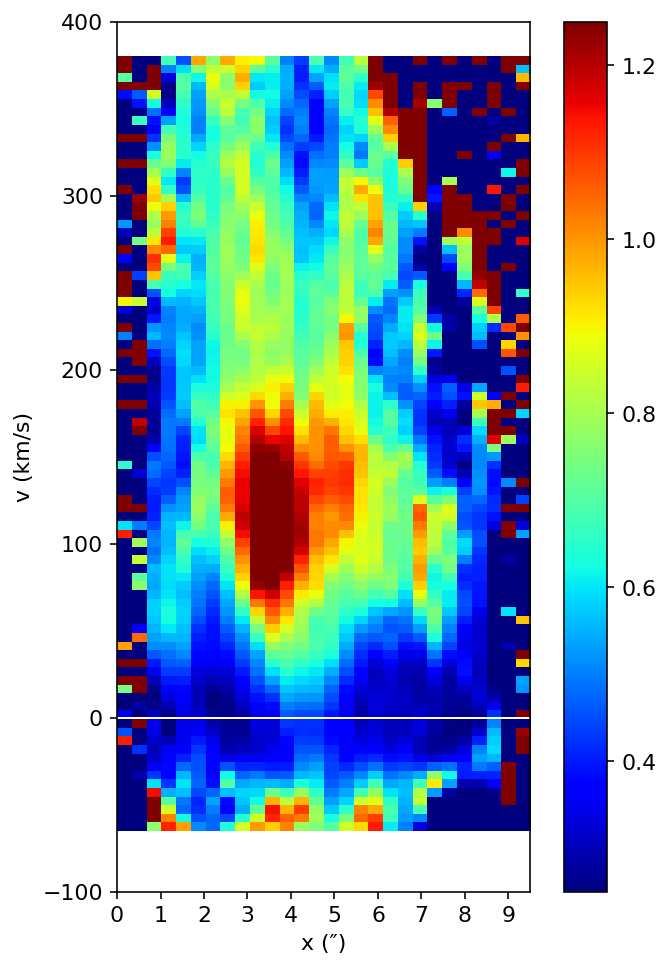

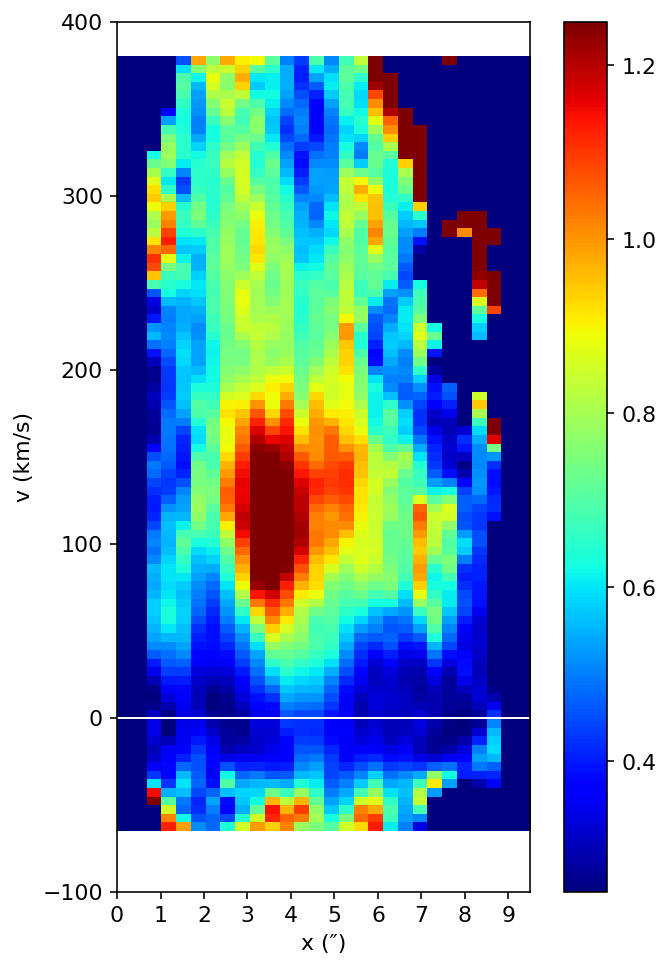

In [39]:
minpix = 0
maxpix = 180
tick = (-100, 500, 100)

m_s5007c = remove_noise(m_s5007, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 0.1)

minpix = 0.25
maxpix = 1.25
tick = (-100, 500, 100)

s5007_hbeta = m_s5007 / m_hbeta

plot_hist(s5007_hbeta[s5007_hbeta == s5007_hbeta], [0, 2])
plt.show() 
        
plot_new_vx_slice(s5007_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

for i in range(len(s5007_hbeta)):
    for j in range(len(s5007_hbeta[0])):
        if m_s5007c[i][j] != m_s5007c[i][j]:
            s5007_hbeta[i][j] = 0.1
            
plot_new_vx_slice(s5007_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.4591766050551098, std = 1.2174052328094347


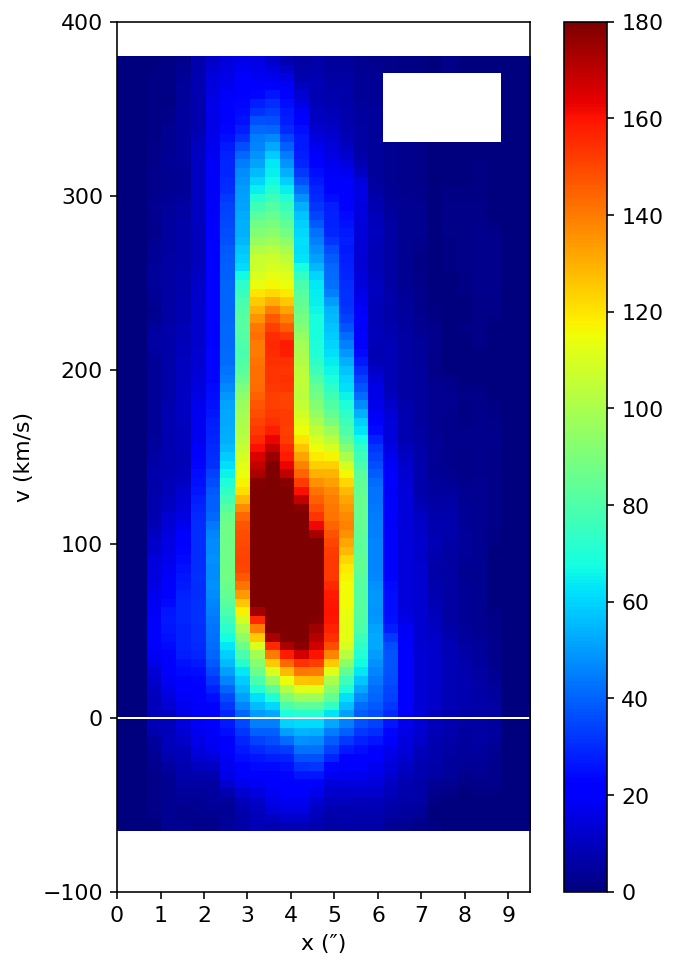

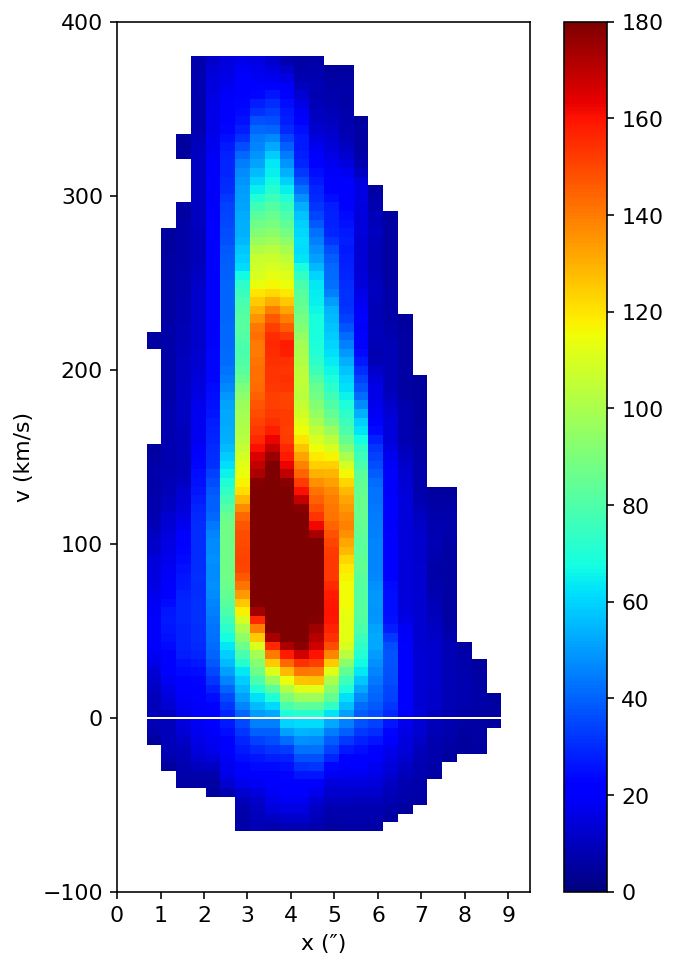

median = 0.4322717621369795, std = 0.9821280729204425


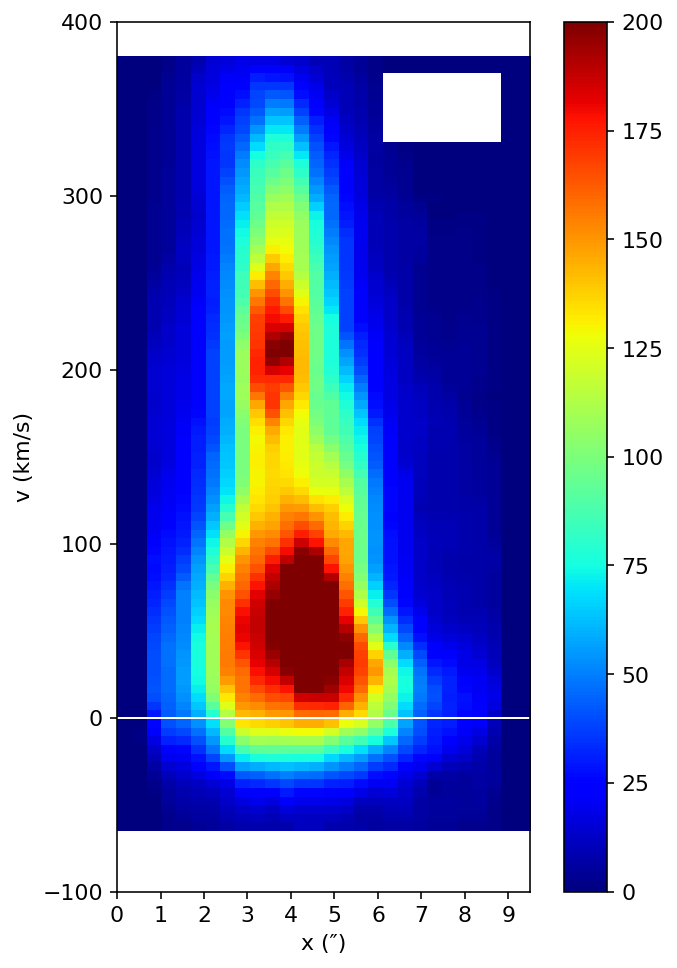

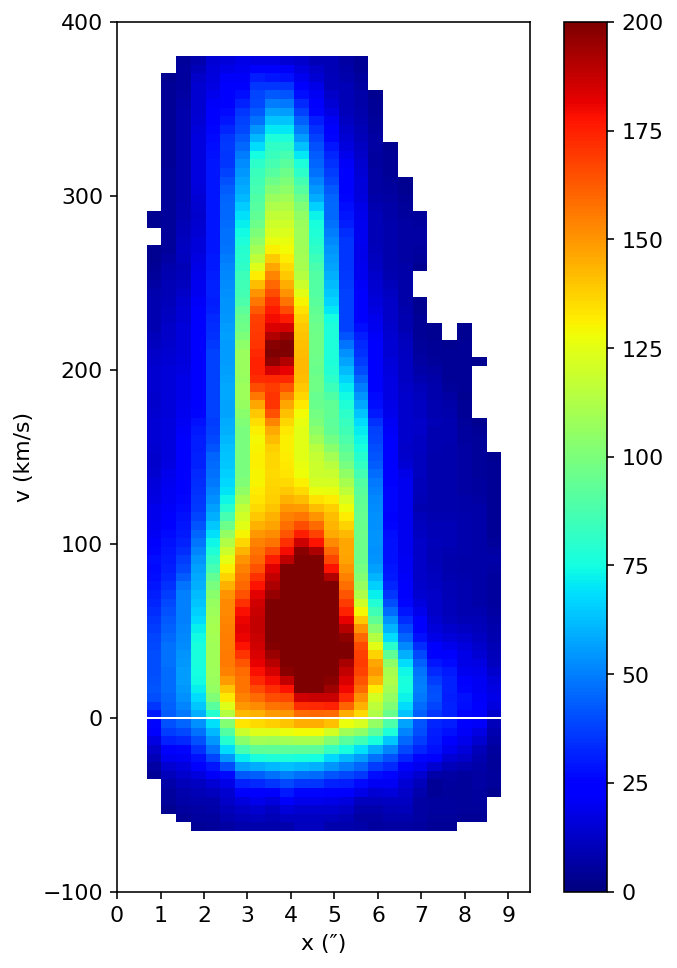

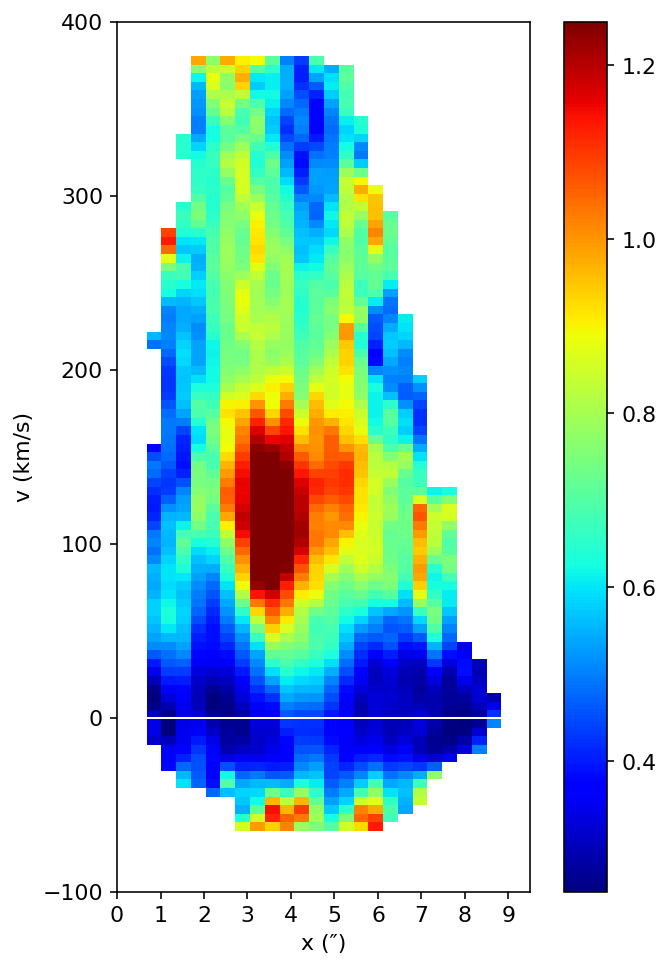

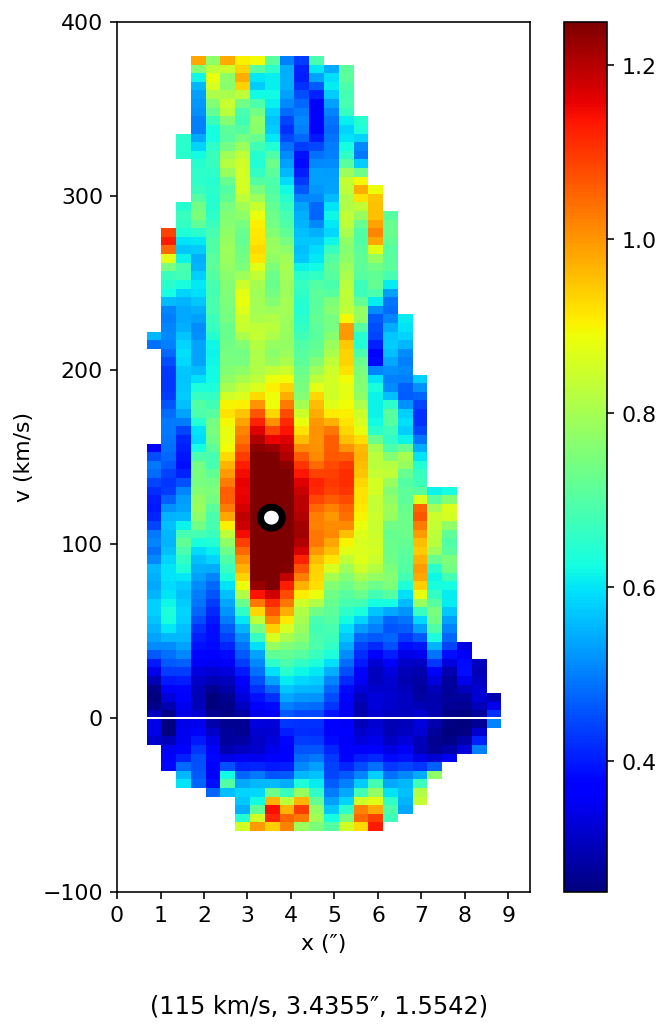

In [40]:
minpix = 0
maxpix = 180
tick = (-100, 500, 100)

m_s5007c = remove_noise(m_s5007, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 0
maxpix = 200
tick = (-100, 500, 100)

m_hbetac = remove_noise(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)


s5007c_hbetac = m_s5007c / m_hbetac

minpix = 0.25
maxpix = 1.25
tick = (-100, 500, 100)
plot_new_vx_slice(s5007c_hbetac, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, s5007c_hbetac, minpix, maxpix, tick)

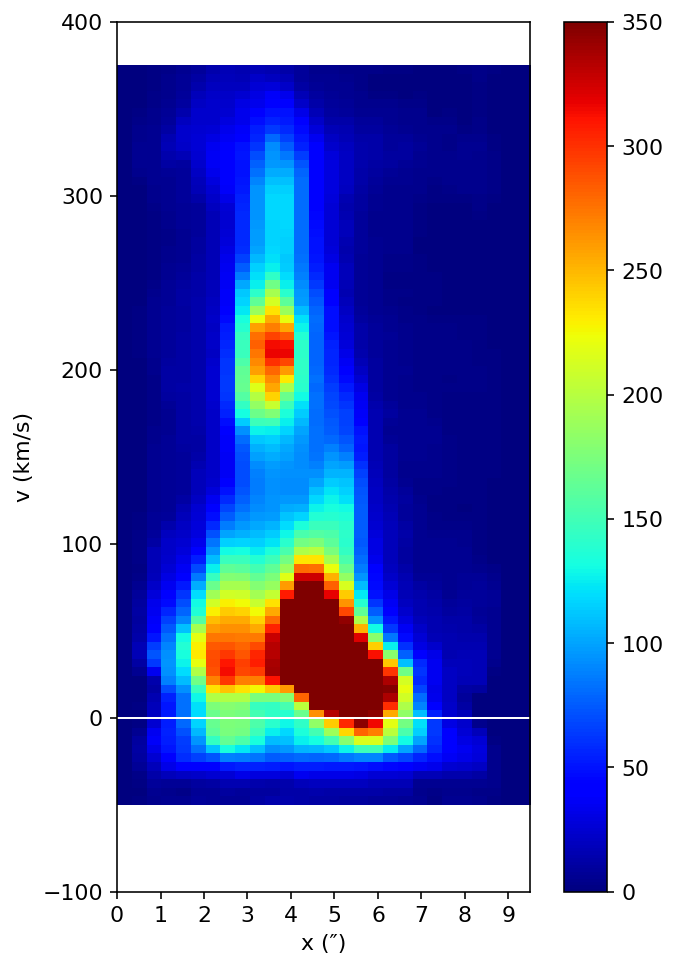

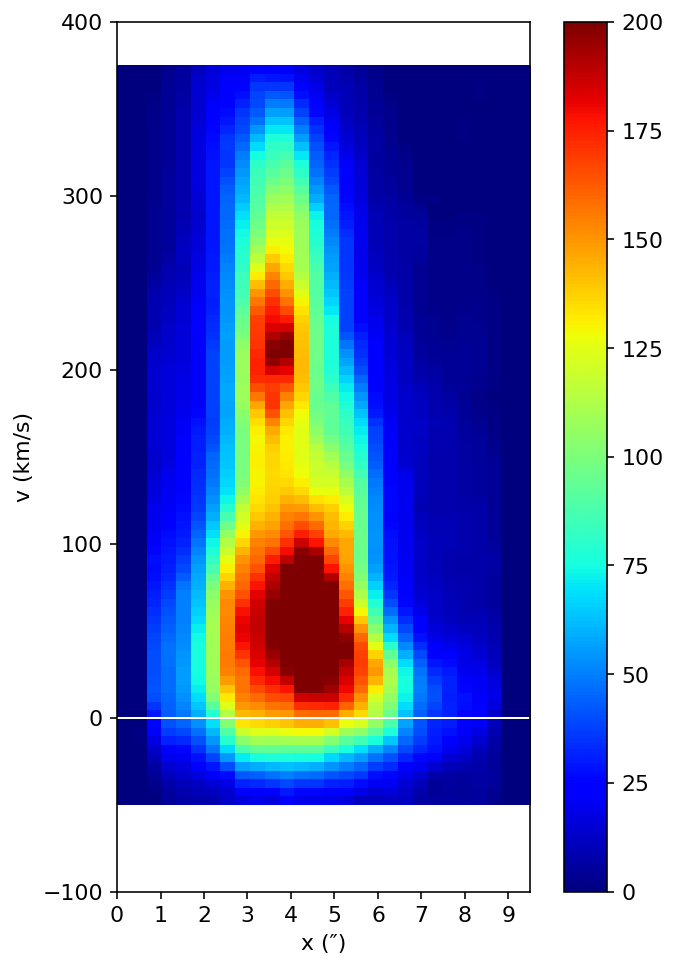

In [41]:
m_vvals, m_oi , m_hbeta = match_grids(new_oi_vvals, new_oi, new_hbeta_vvals, new_hbeta)

minpix = 0
maxpix = 350
tick = (-100, 500, 100)

plot_new_vx_slice(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 0
maxpix = 200
tick = (-100, 500, 100)

plot_new_vx_slice(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

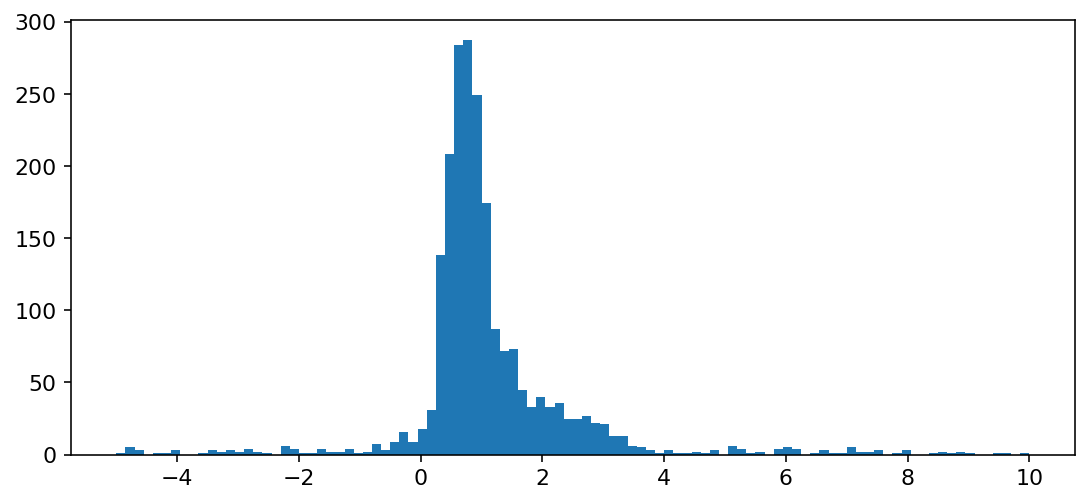

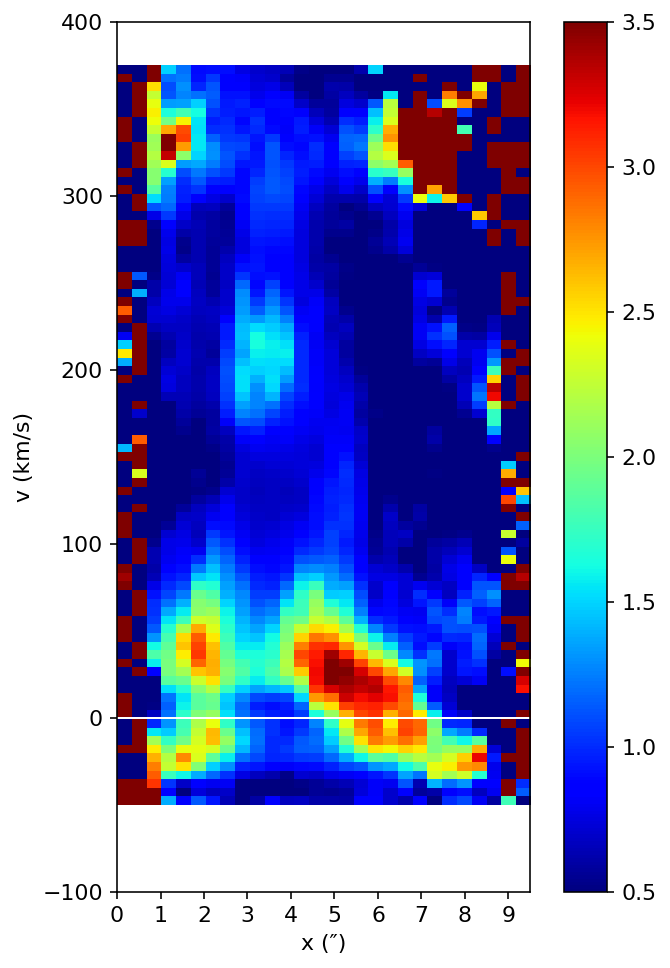

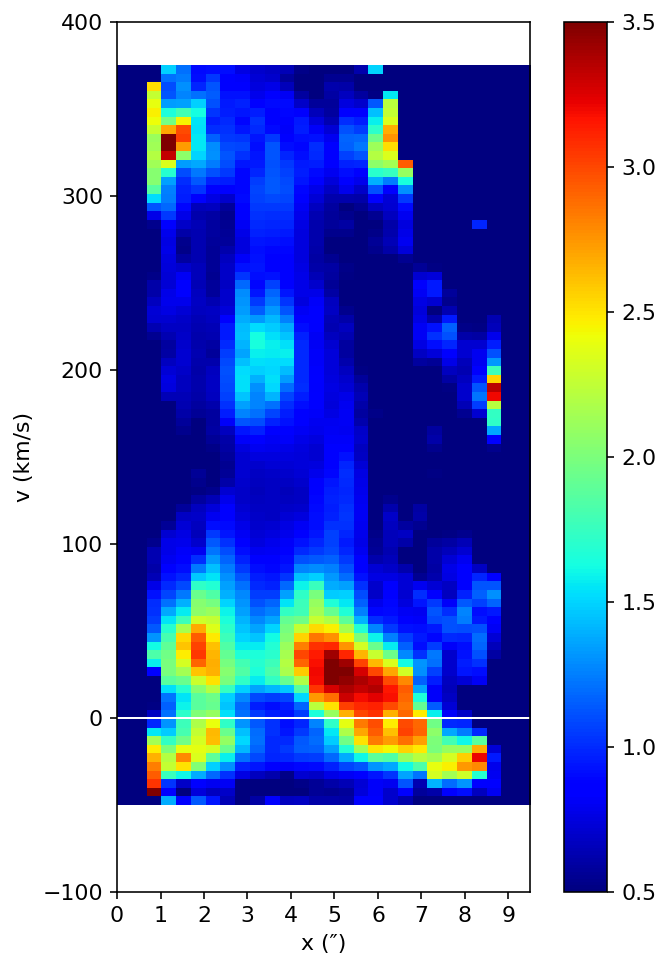

In [42]:
minpix = 0.5
maxpix = 3.5
tick = (-100, 500, 100)

oi_hbeta = m_oi / m_hbeta

plot_hist(oi_hbeta[oi_hbeta == oi_hbeta], [-5, 10])
plt.show() 
        
plot_new_vx_slice(oi_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()


for i in range(len(oi_hbeta)):
    for j in range(len(oi_hbeta[0])):
        if oi_hbeta[i][j] > 4:
            oi_hbeta[i][j] = 0   
            
for i in range(len(oi_hbeta)):
    for j in range(2):
            oi_hbeta[i][j] = 0
            
for i in range(len(oi_hbeta)):
    for j in range(3):
            oi_hbeta[i][-j] = 0
            
for i in range(19):
    for j in range(9):
            oi_hbeta[-i][-j] = 0.1
            
plot_new_vx_slice(oi_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 3.572364347664486, std = 2.633504466580577


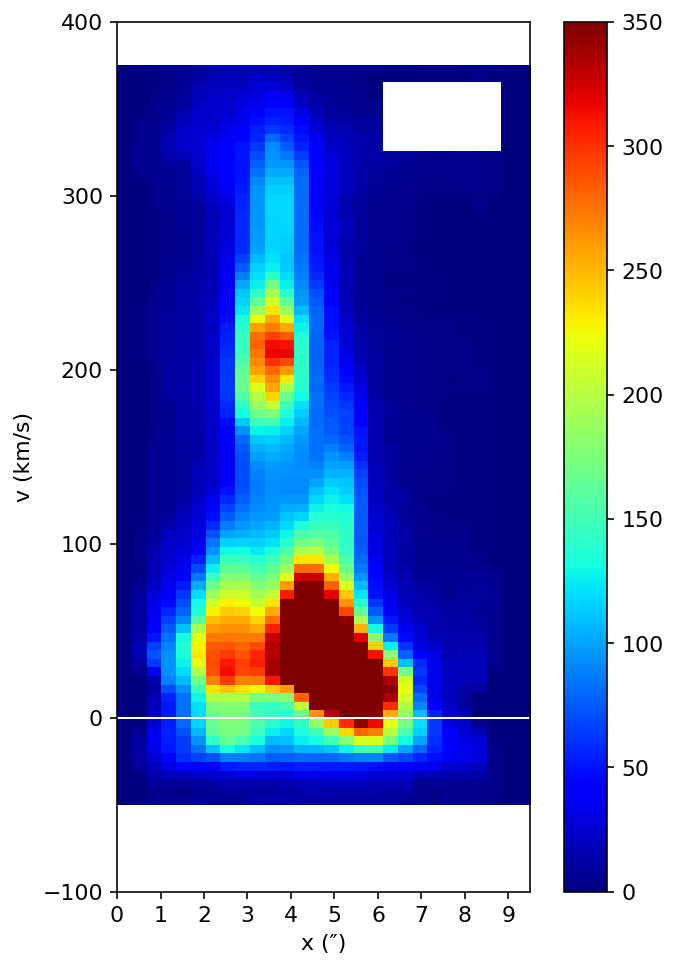

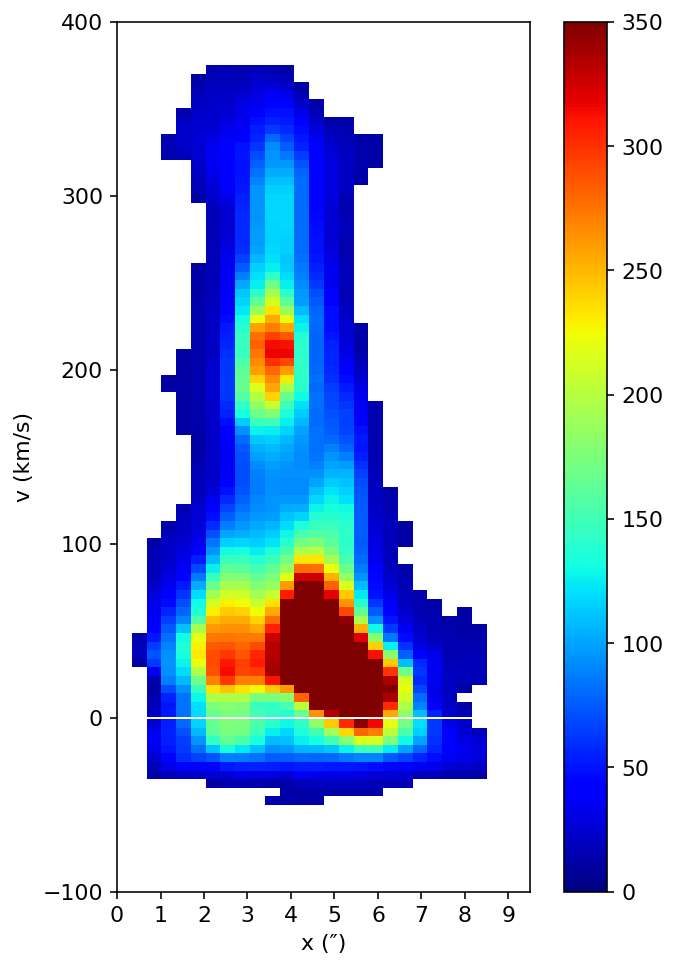

median = 0.47579630353329, std = 1.0224612137288231


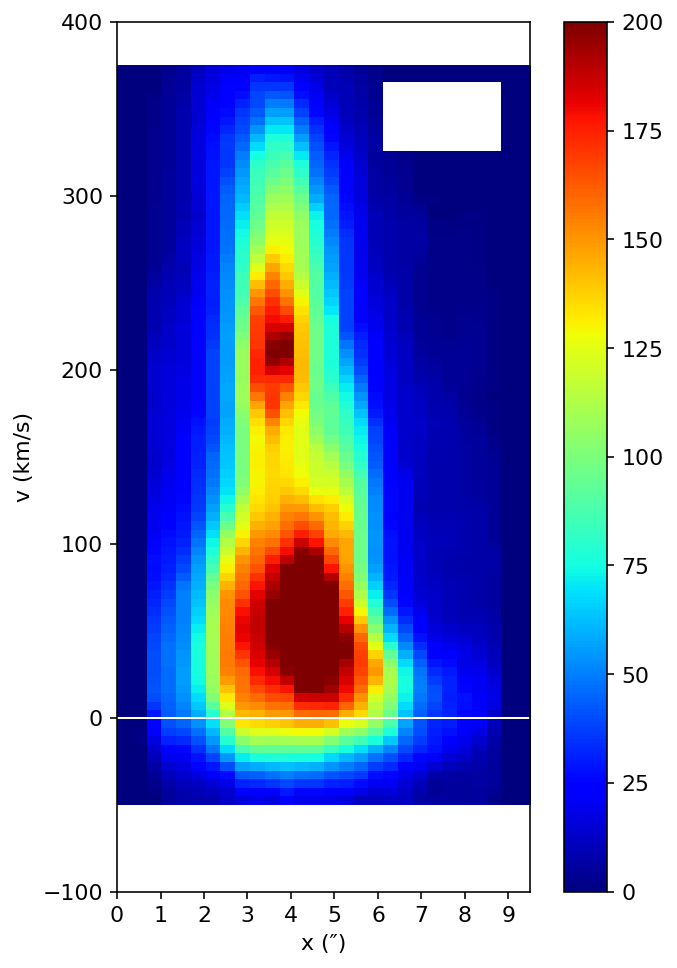

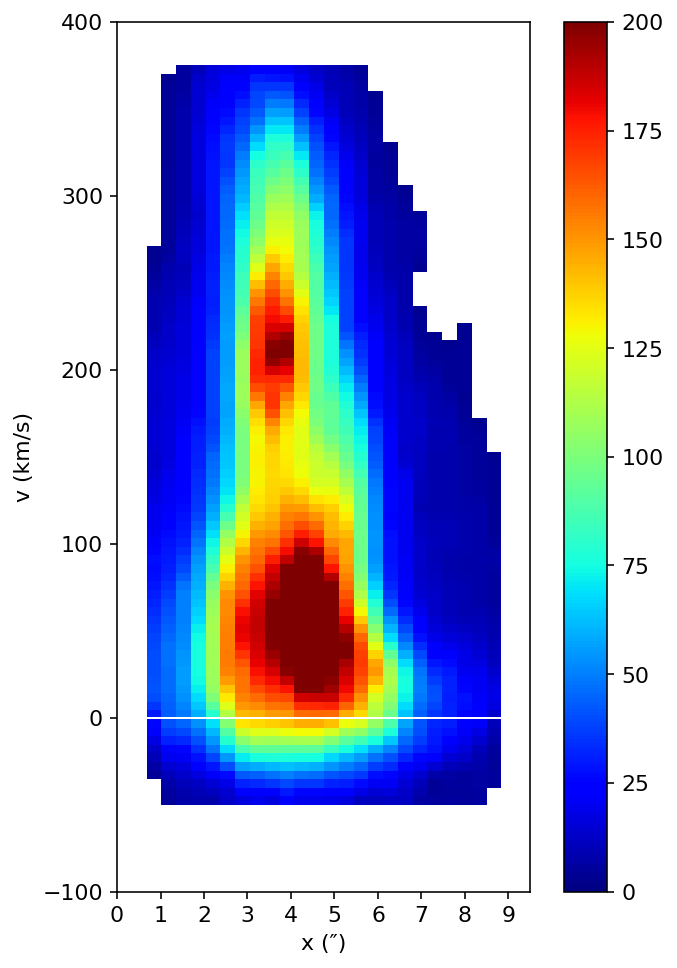

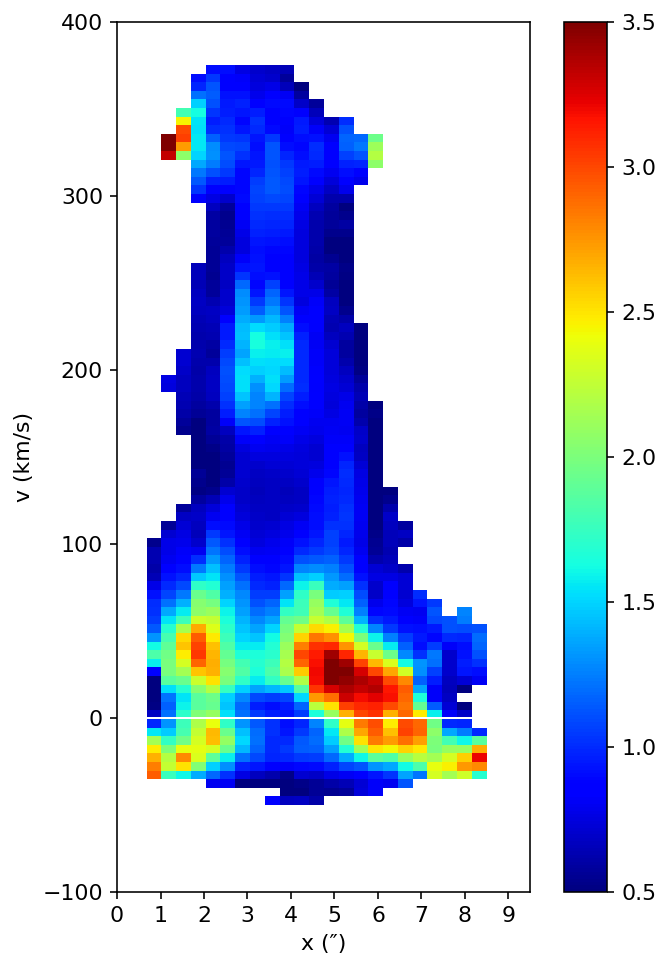

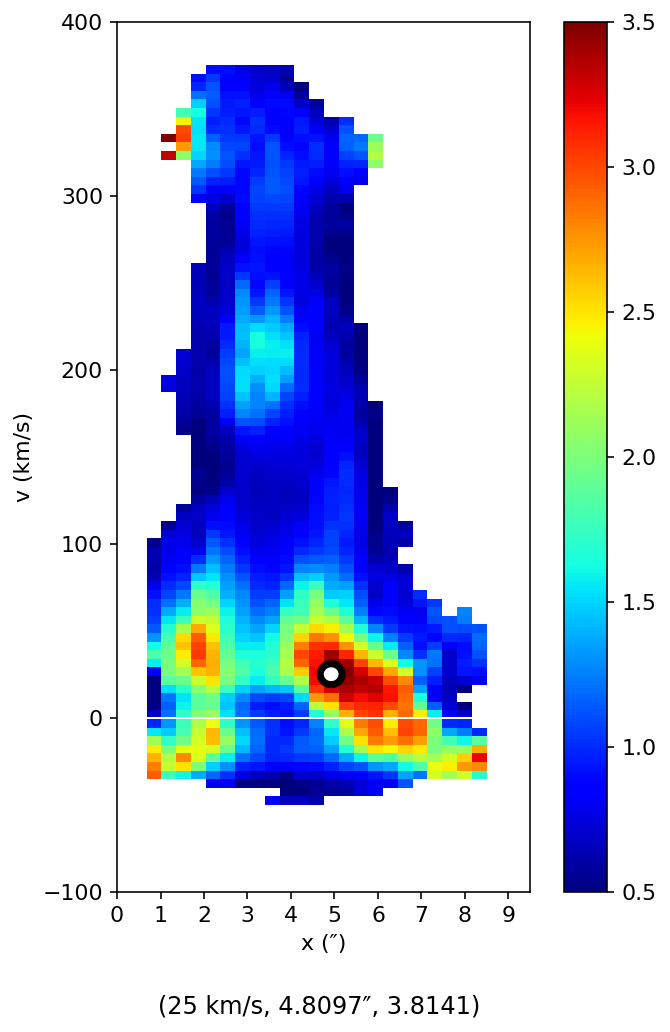

In [43]:
minpix = 0
maxpix = 350
tick = (-100, 500, 100)
m_oic = remove_noise(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 0
maxpix = 200
tick = (-100, 500, 100)
m_hbetac = remove_noise(m_hbeta, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

oi_hbetac = m_oic / m_hbetac

minpix = 0.5
maxpix = 3.5
tick = (-100, 500, 100)
plot_new_vx_slice(oi_hbetac, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, oi_hbetac, minpix, maxpix, tick, True)

v_low = -4.8376683544563575, v_high = 465.49119943915133, aspect = 0.03333333333333333


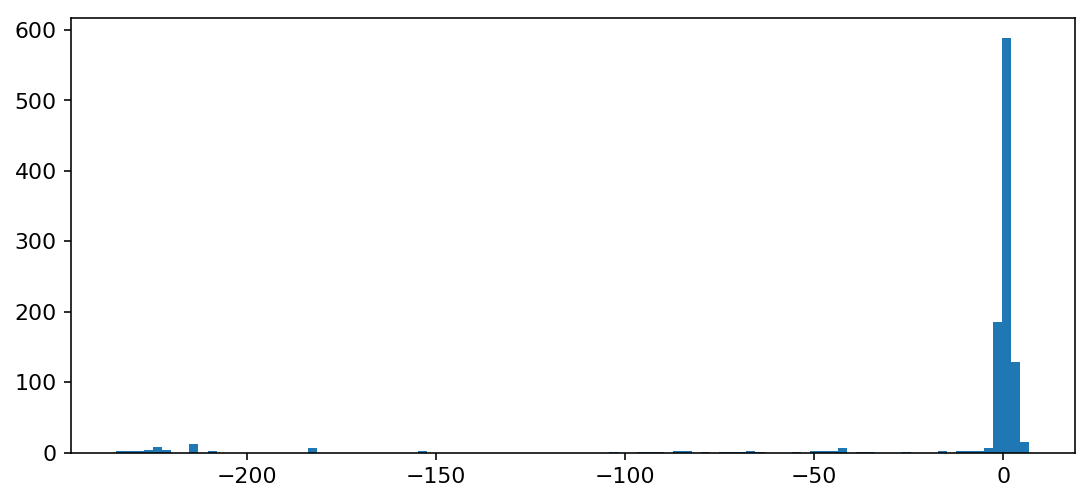

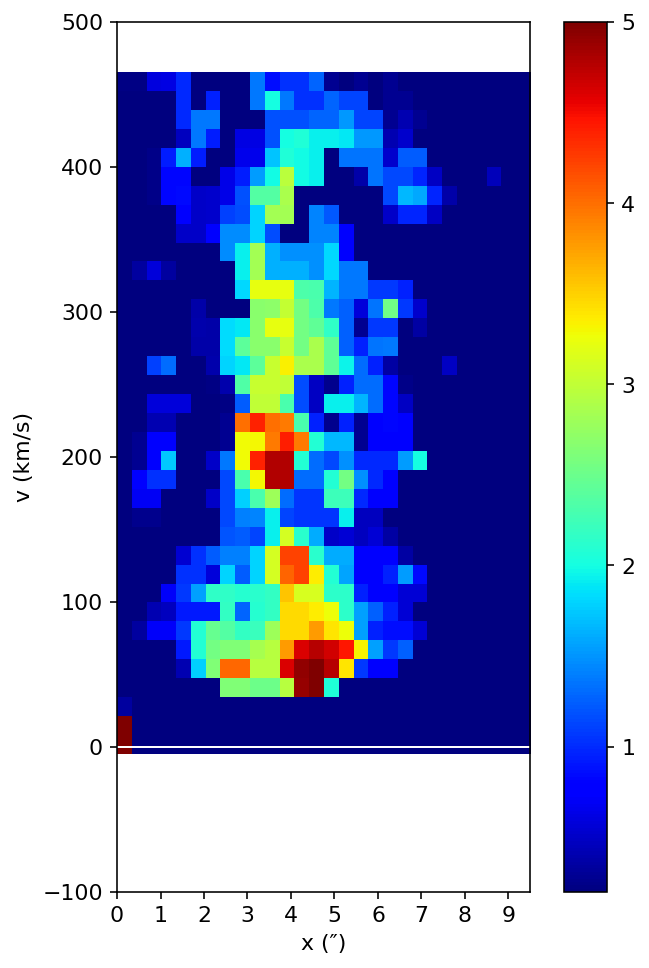

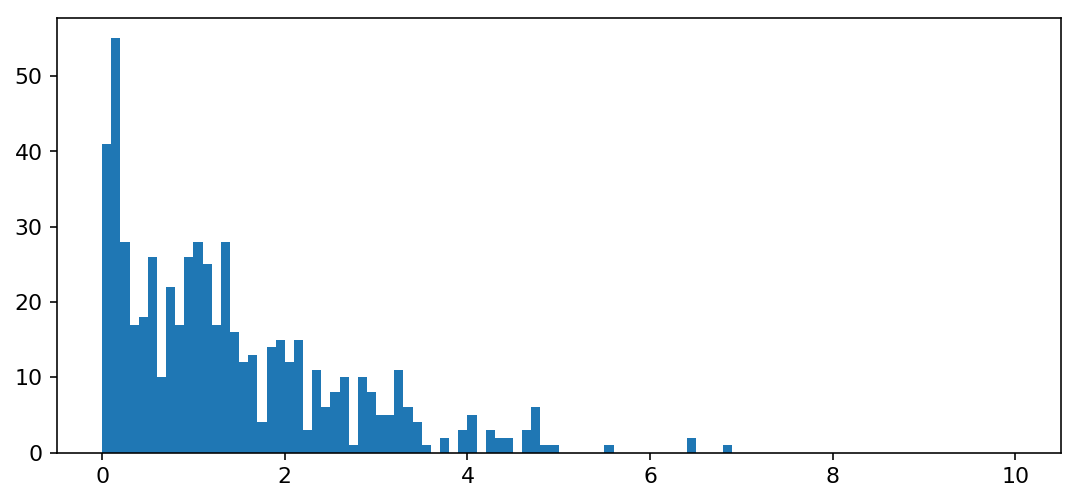

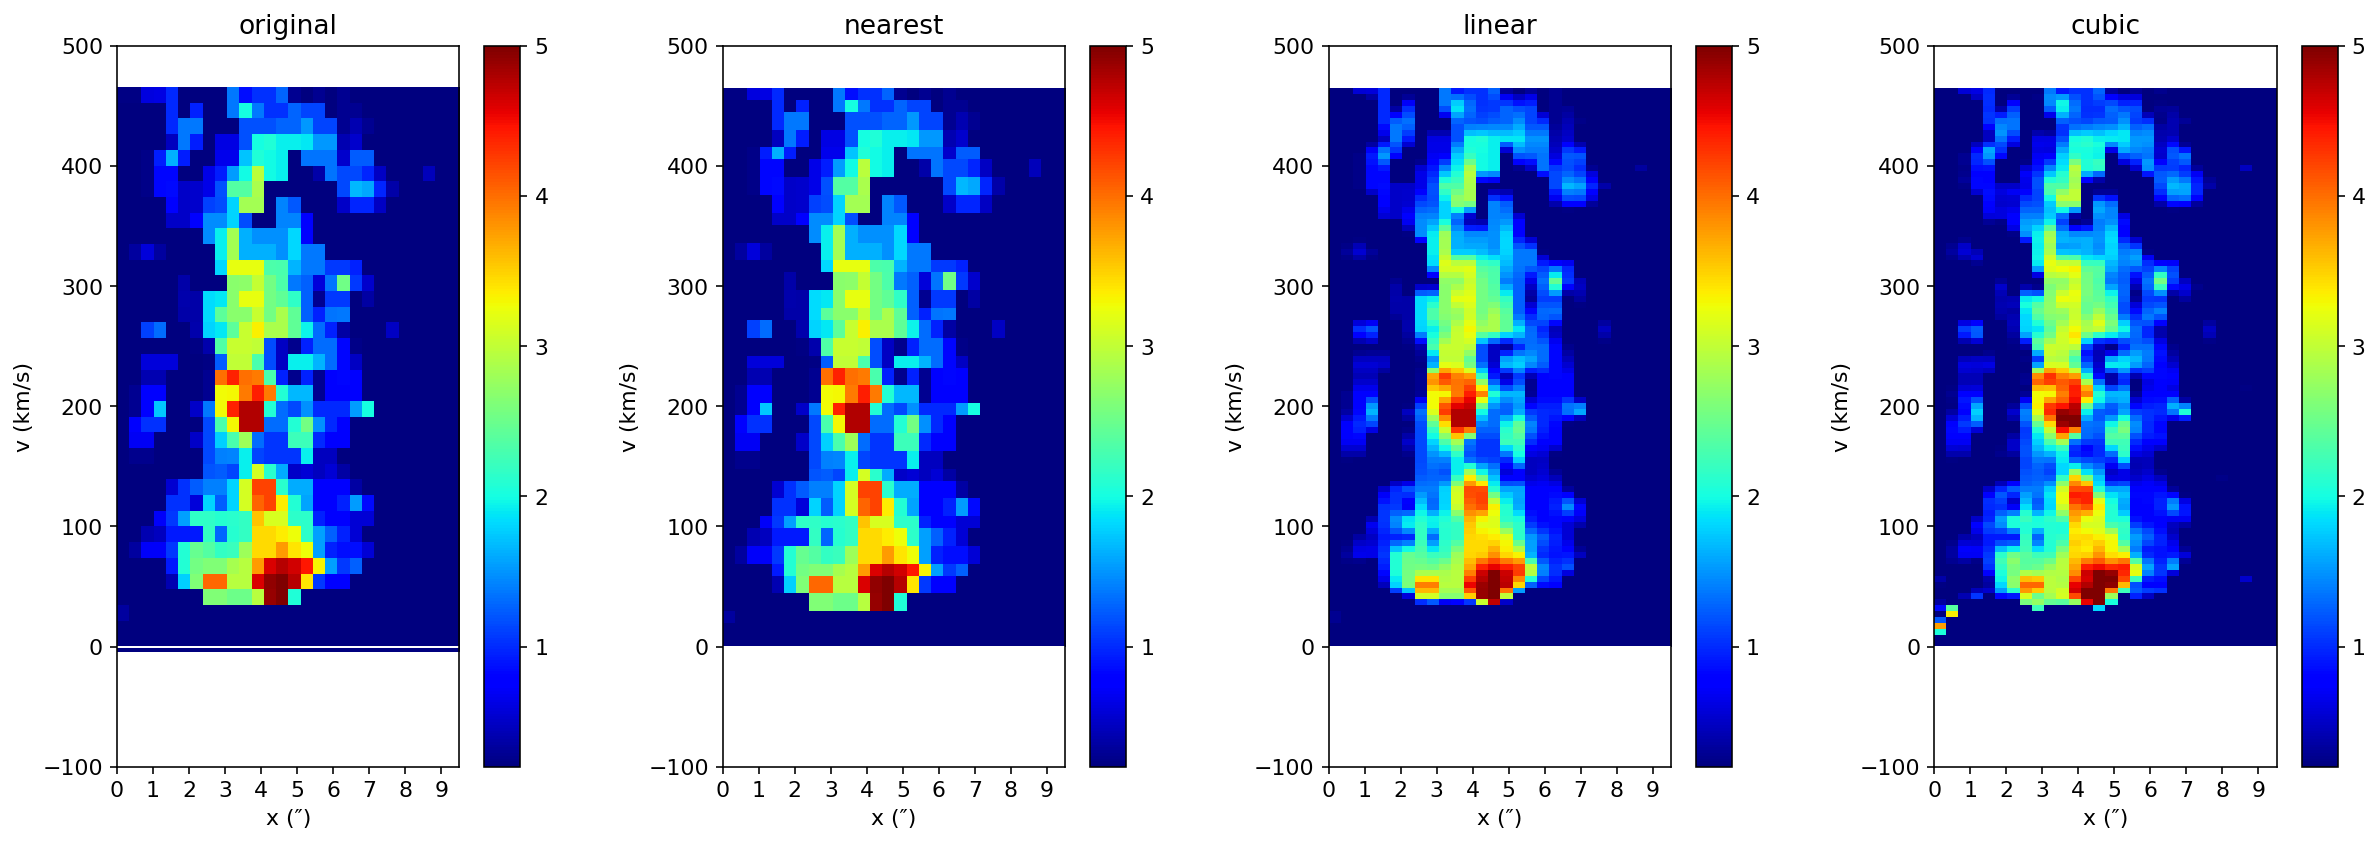

In [44]:
center = 5577.34
low =  5577.25
high = 5586.00
minpix = 0.2
maxpix = 5
tick = (-100, 600, 100)
color = "red"

oi2_vvals, oi2 = plot_vx_slice(center, low, high, minpix, maxpix, tick, color, 3)
plt.show()

plot_hist(oi2, [0, 10])
plt.show()

for i in range(2):
    for j in range(len(oi2[0])):
        if oi2[i][j] > 2:
            oi2[i][j] = 0
        
new_oi2_vvals, new_oi2 = test_grid_methods(oi2_vvals, oi2, minpix, maxpix, tick)
plt.show()

for i in range(15):
    for j in range(5):
        if new_oi2[i][j] > 1:
            new_oi2[i][j] = 0.1

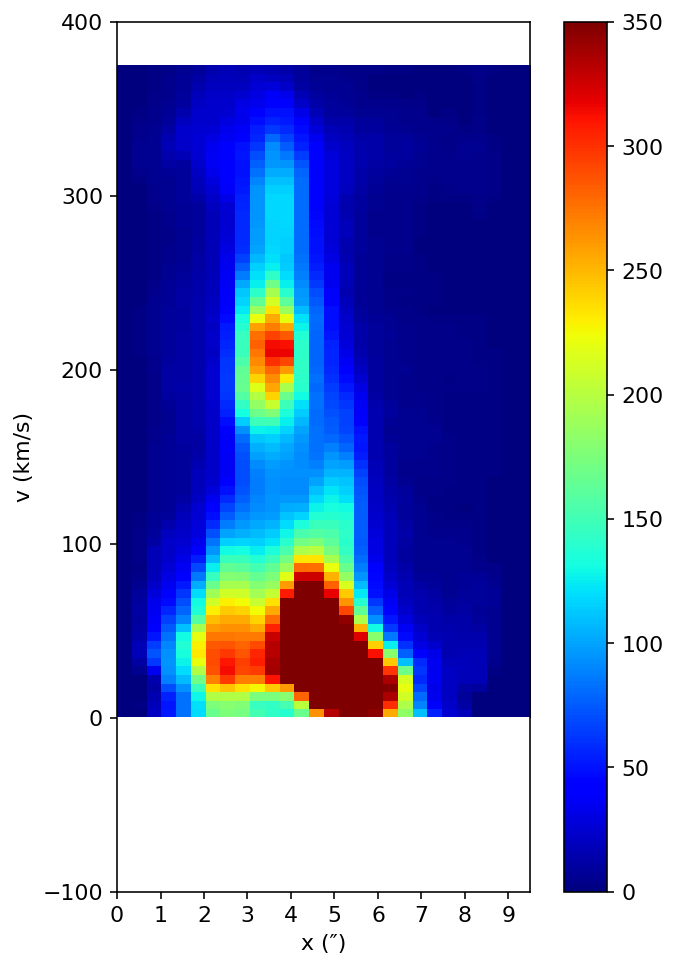

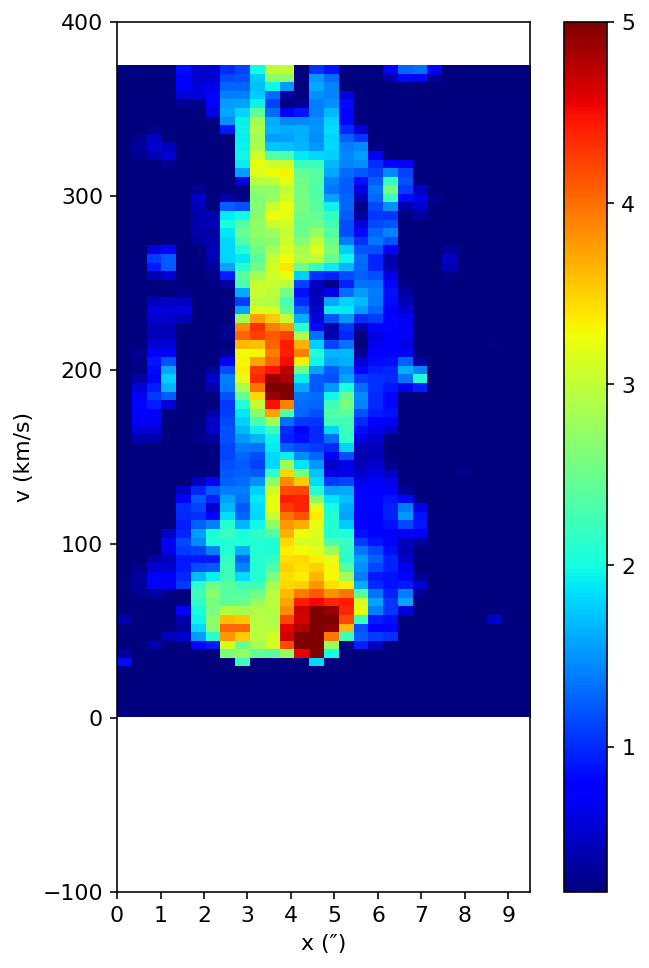

In [45]:
m_vvals, m_oi , m_oi2 = match_grids(new_oi_vvals, new_oi, new_oi2_vvals, new_oi2)

minpix = 0
maxpix = 350
tick = (-100, 500, 100)

plot_new_vx_slice(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 0.2
maxpix = 5
tick = (-100, 500, 100)

plot_new_vx_slice(m_oi2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

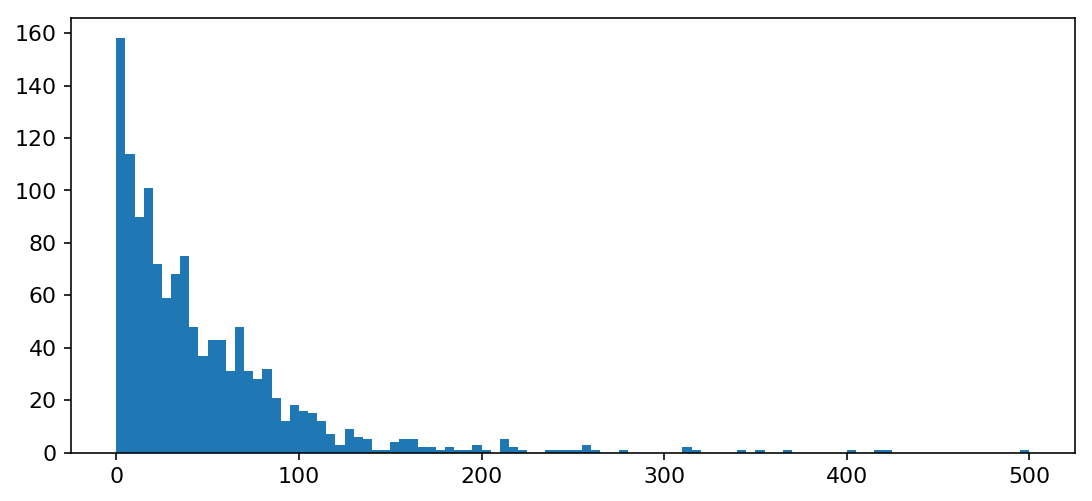

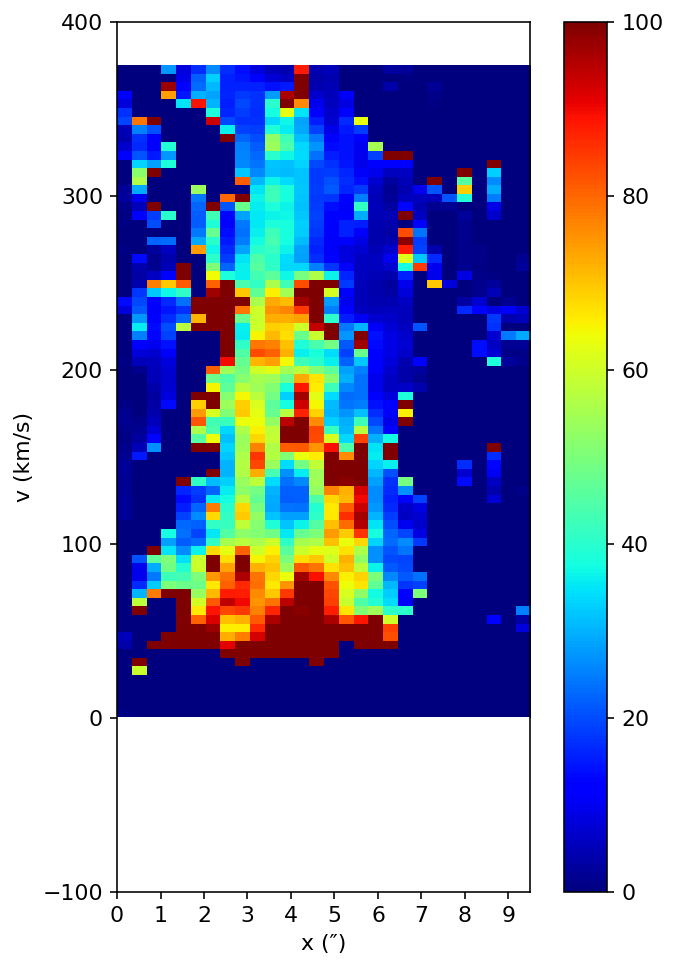

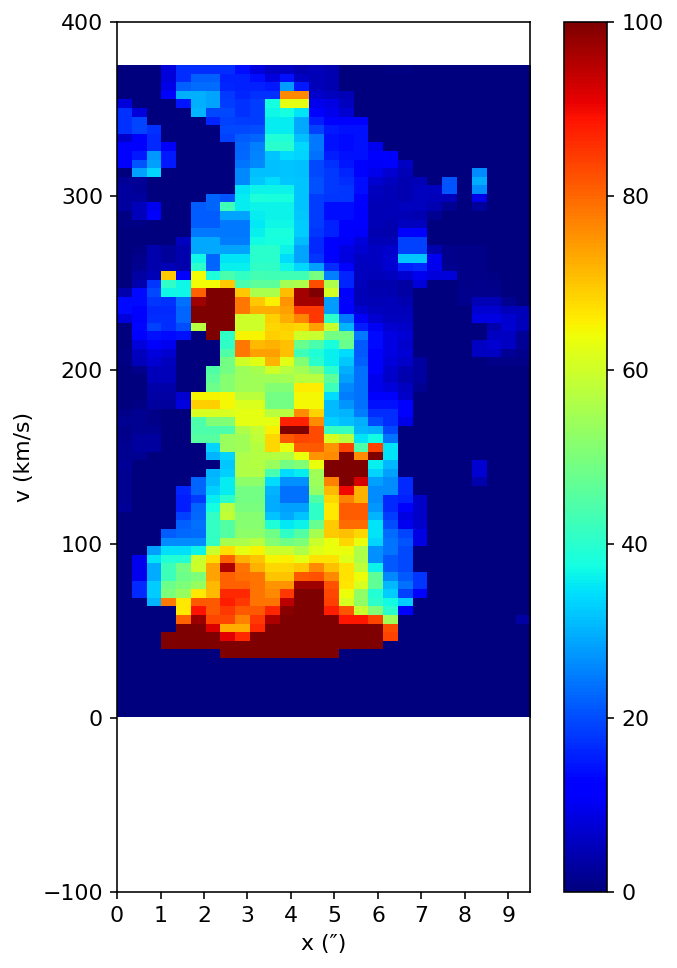

In [46]:
minpix = 0
maxpix = 100
tick = (-100, 500, 100)

oi_oi2 = m_oi / m_oi2

plot_hist(oi_oi2[oi_oi2 == oi_oi2], [0, 500])
plt.show() 
        
plot_new_vx_slice(oi_oi2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

oi_oi2_med = ndimage.median_filter(oi_oi2, 3)
plot_new_vx_slice(oi_oi2_med, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)

median = 3.572364347664486, std = 2.633504466580577


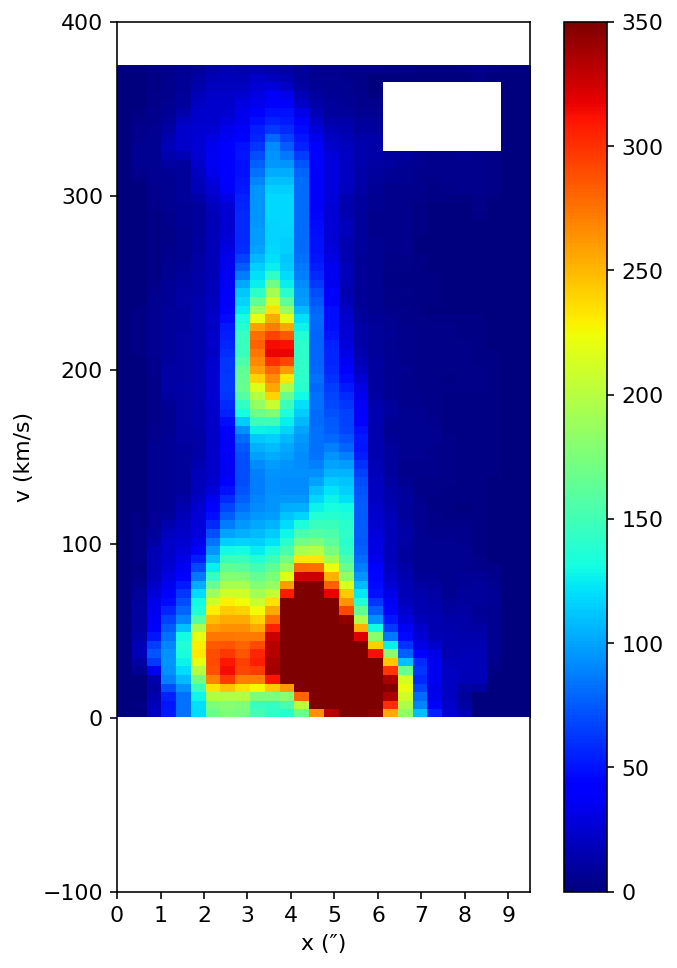

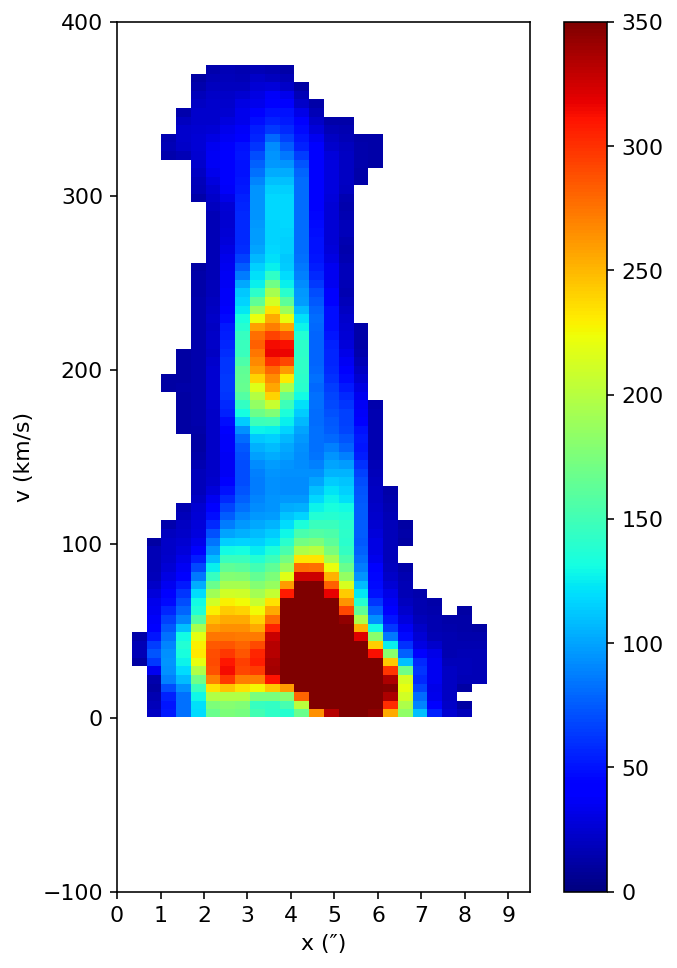

median = 0.15577086620565447, std = 0.7531196840480838


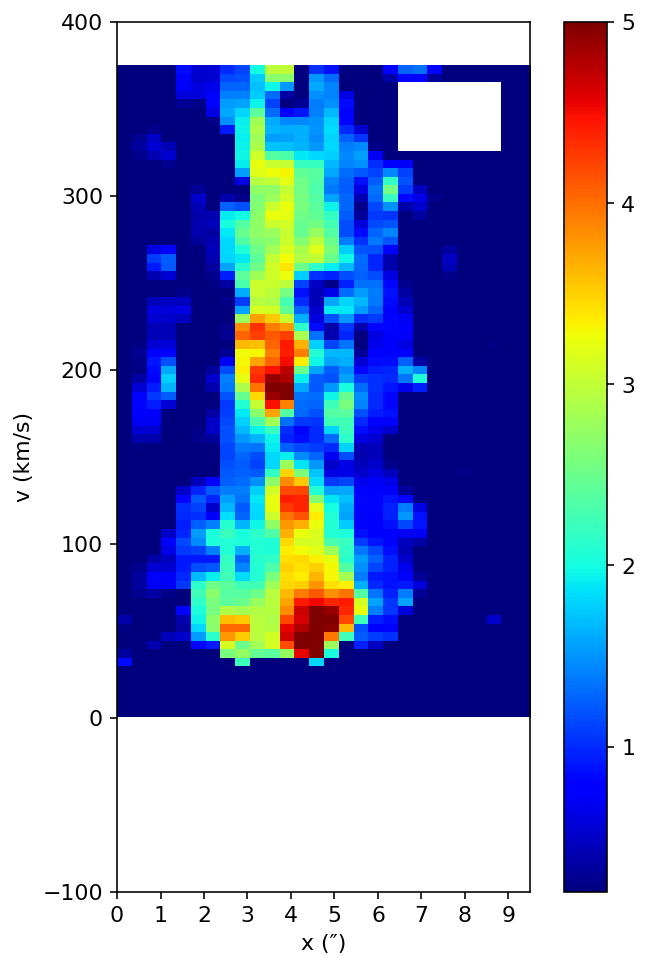

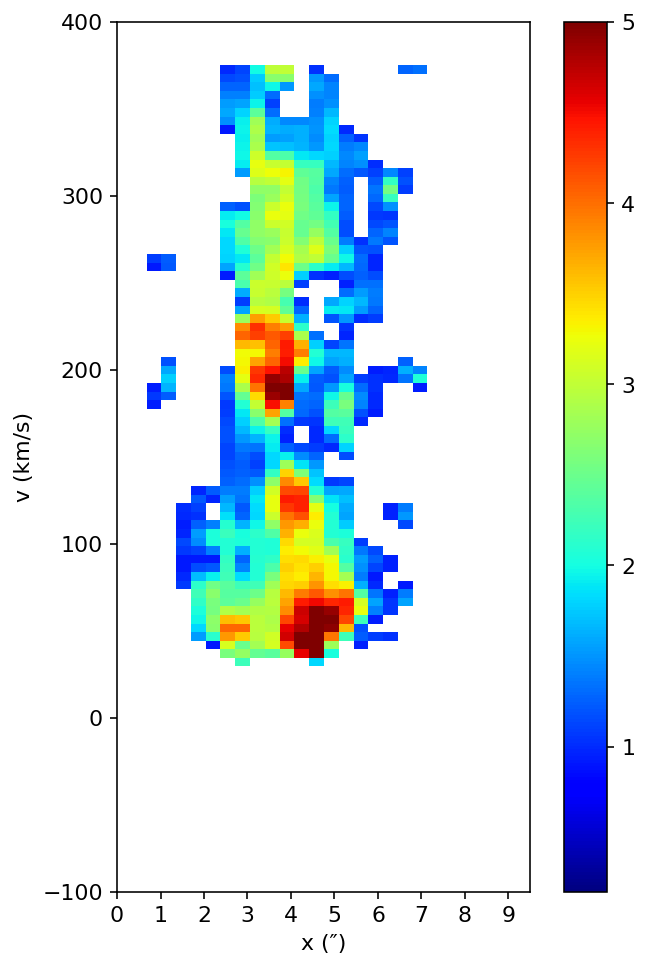

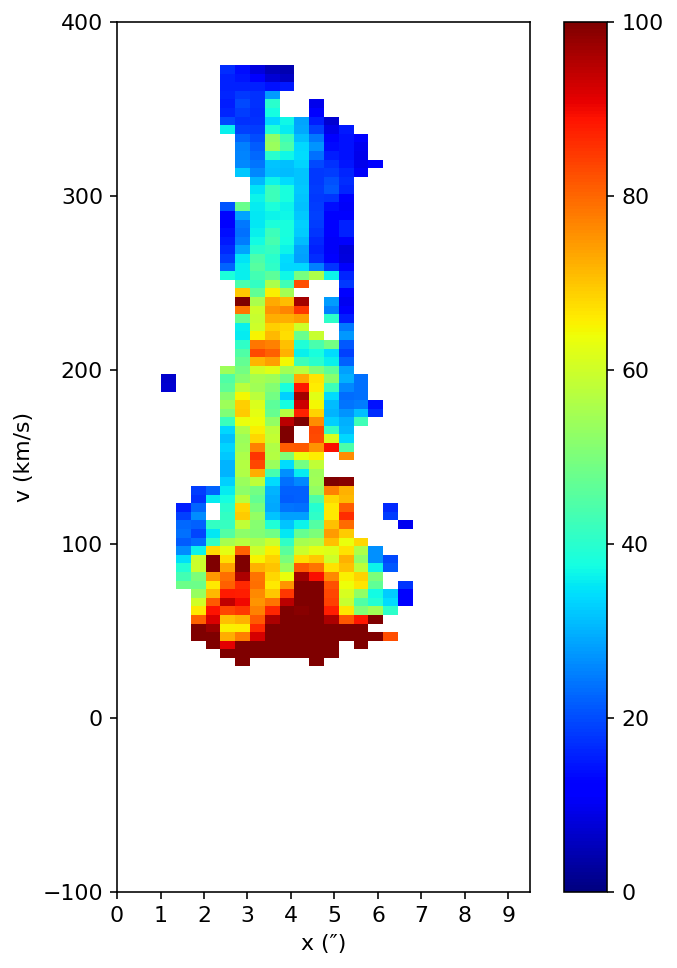

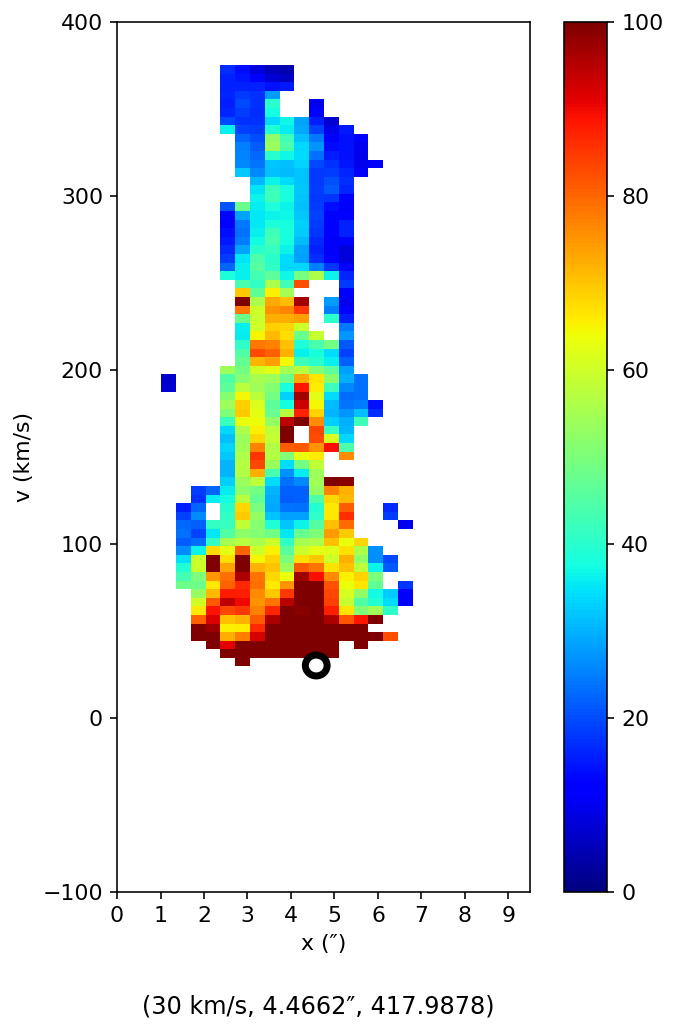

In [47]:
minpix = 0
maxpix = 350
tick = (-100, 500, 100)
m_oic = remove_noise(m_oi, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 0.2
maxpix = 5
tick = (-100, 500, 100)
m_oi2c = remove_noise(m_oi2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 1, (8,7))


oi_oi2c = m_oic / m_oi2c

minpix = 0
maxpix = 100
tick = (-100, 500, 100)

plot_new_vx_slice(oi_oi2c, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, oi_oi2c, minpix, maxpix, tick)

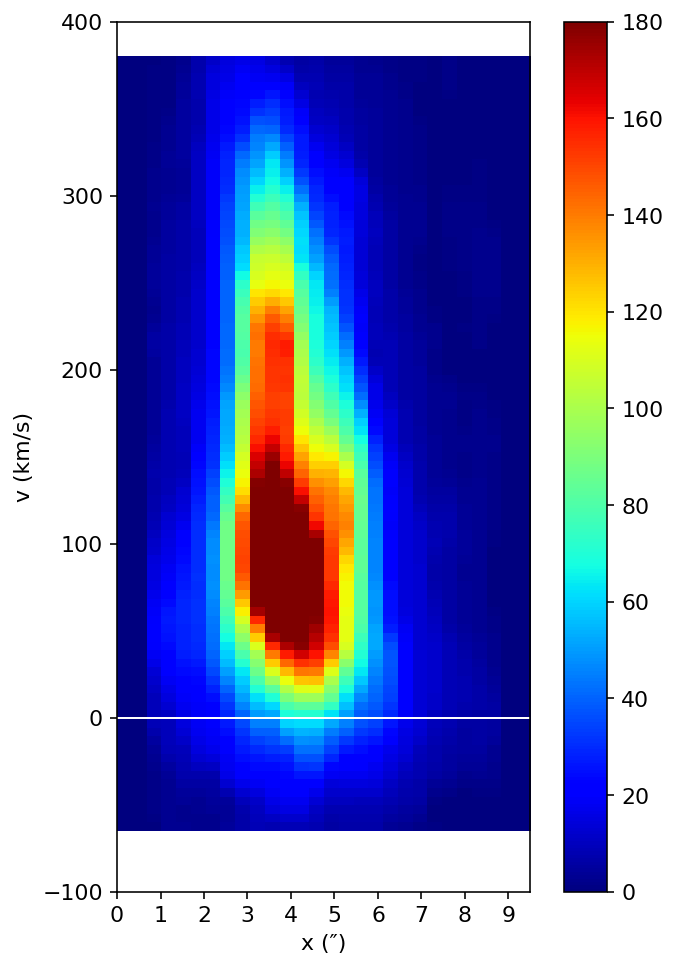

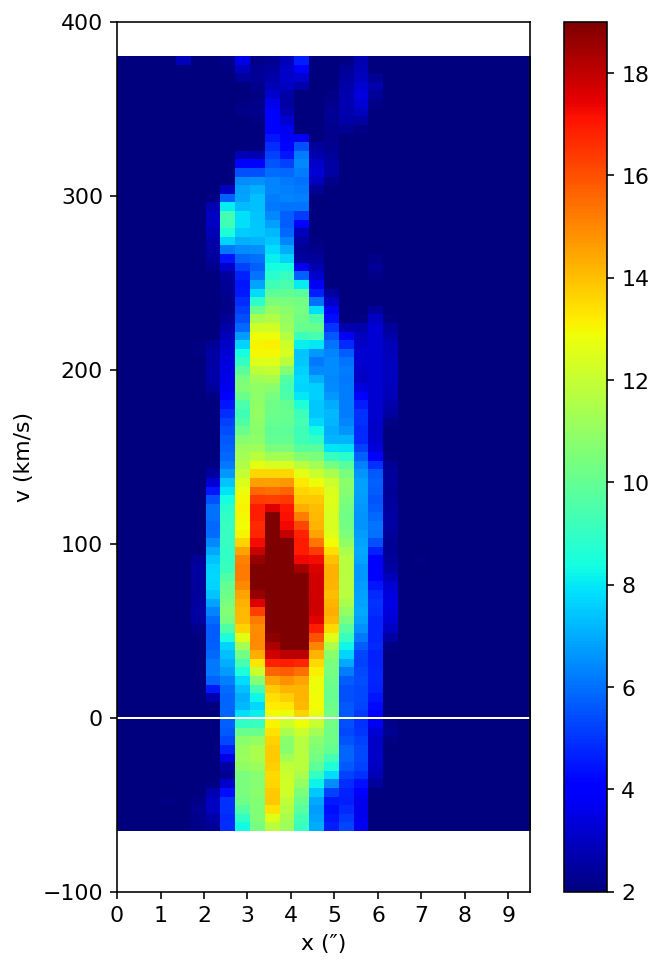

In [48]:
m_vvals, m_s5007, m_oiii2 = match_grids(new_s5007_vvals, new_s5007, new_oiii2_vvals, new_oiii2)

minpix = 0
maxpix = 180
tick = (-100, 500, 100)

plot_new_vx_slice(m_s5007, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

minpix = 2
maxpix = 19
tick = (-100, 500, 100)

plot_new_vx_slice(m_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

median = 1.4591766050551098, std = 1.2174052328094347


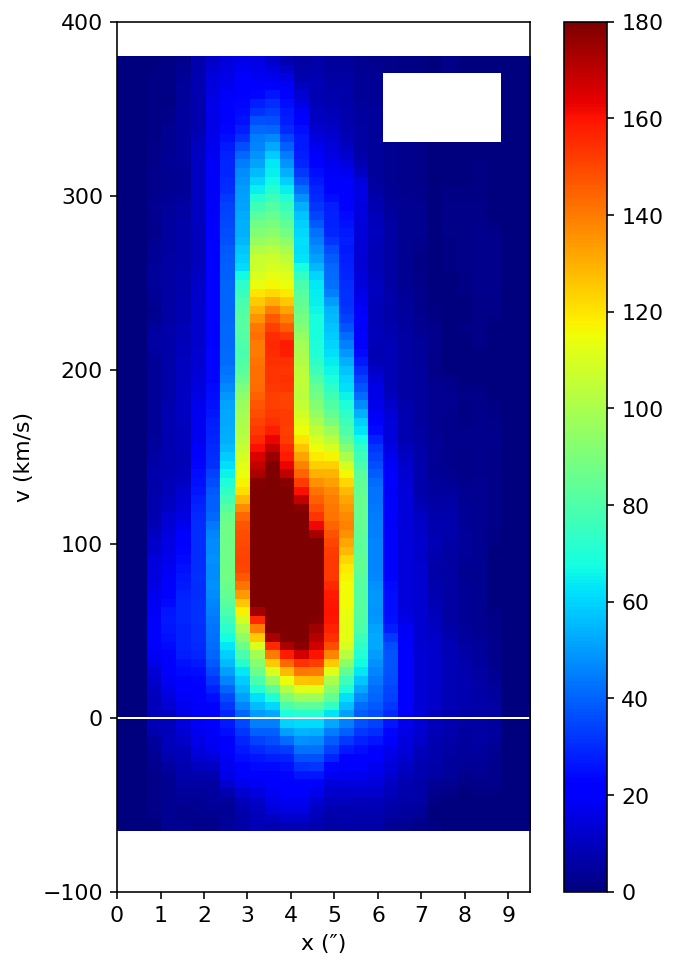

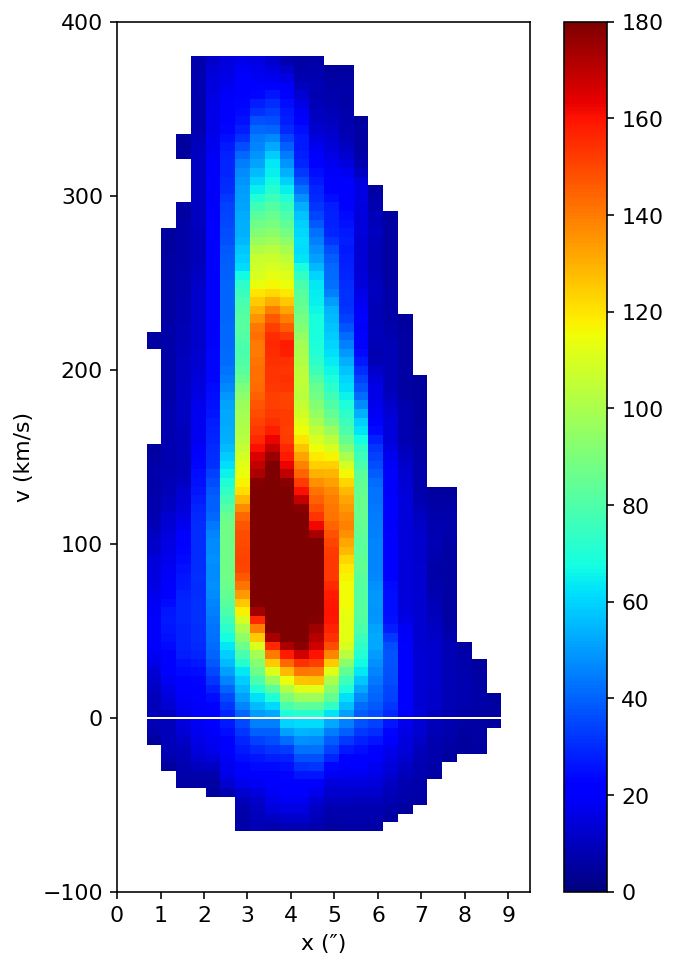

median = 0.5352637970033409, std = 0.947281073868466


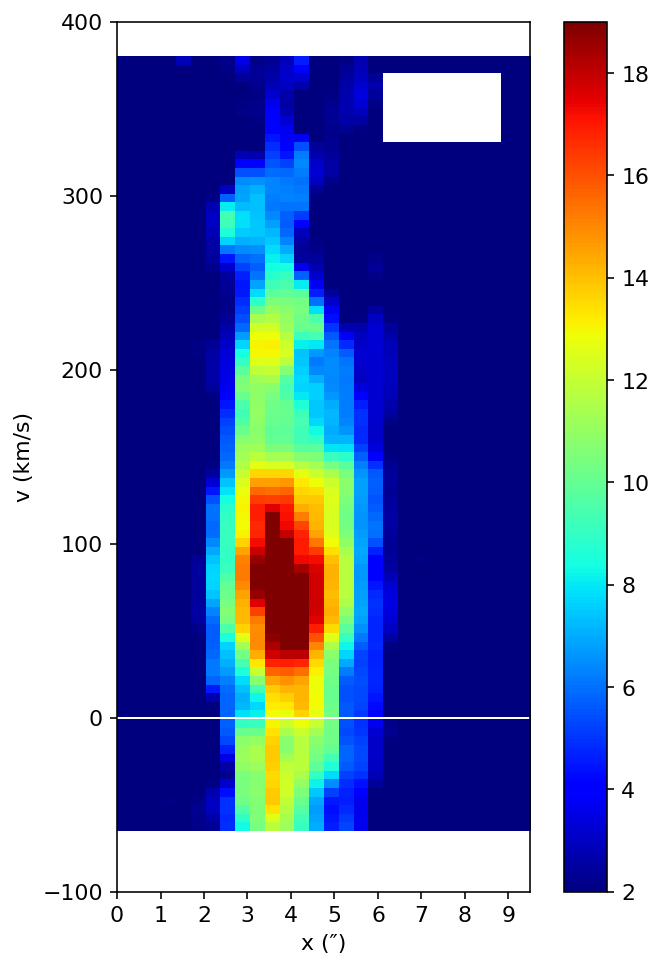

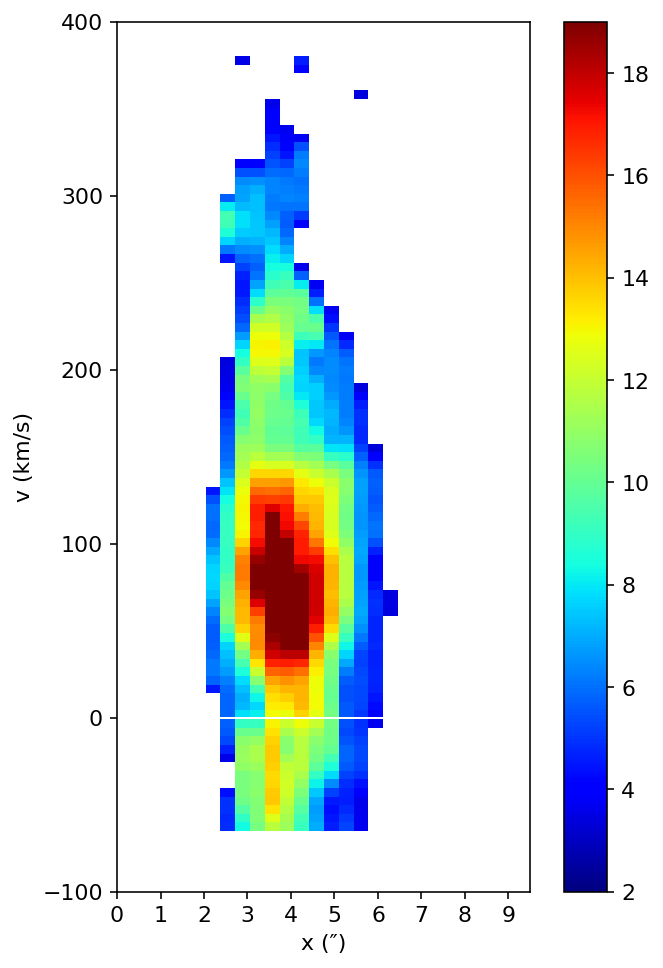

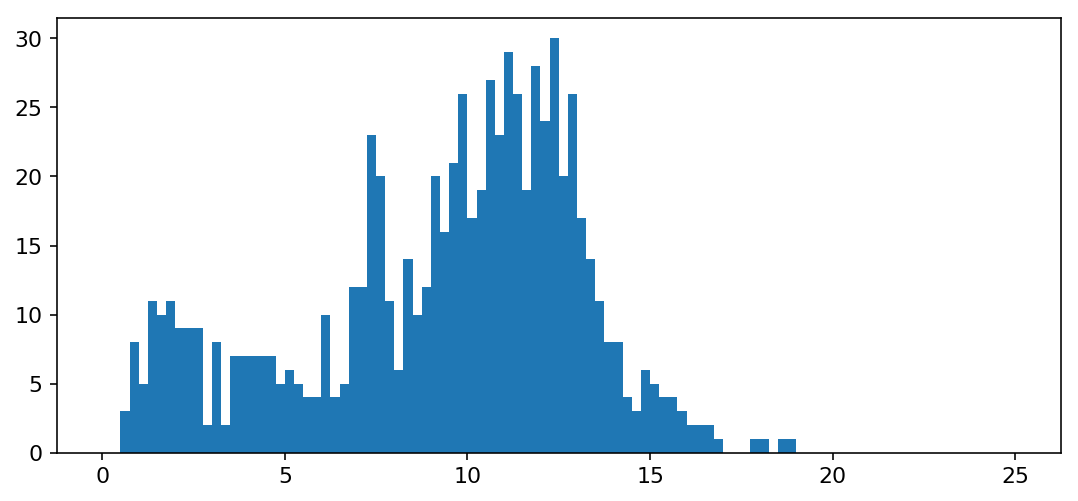

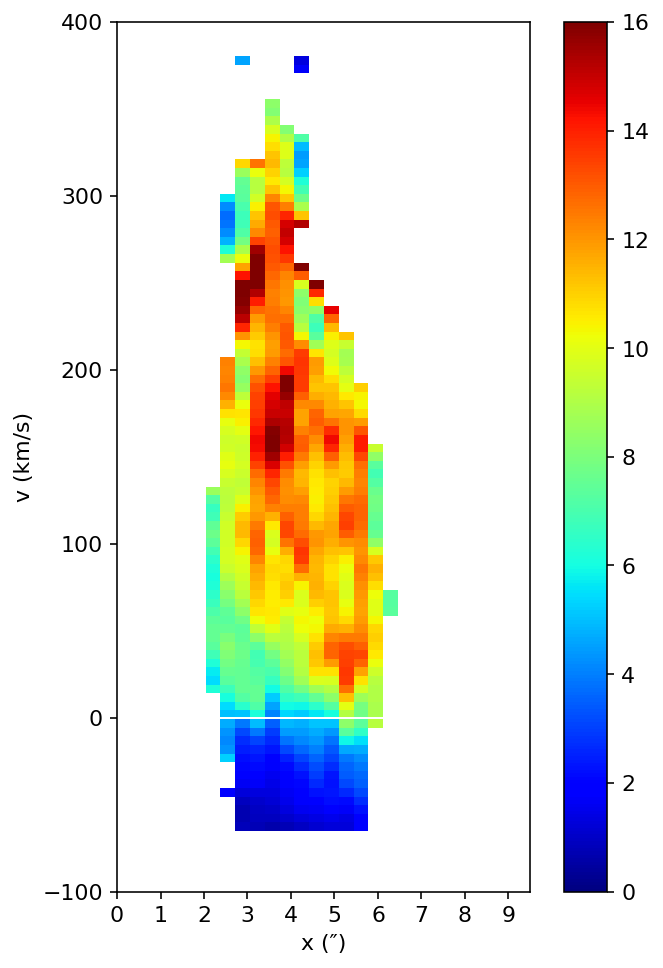

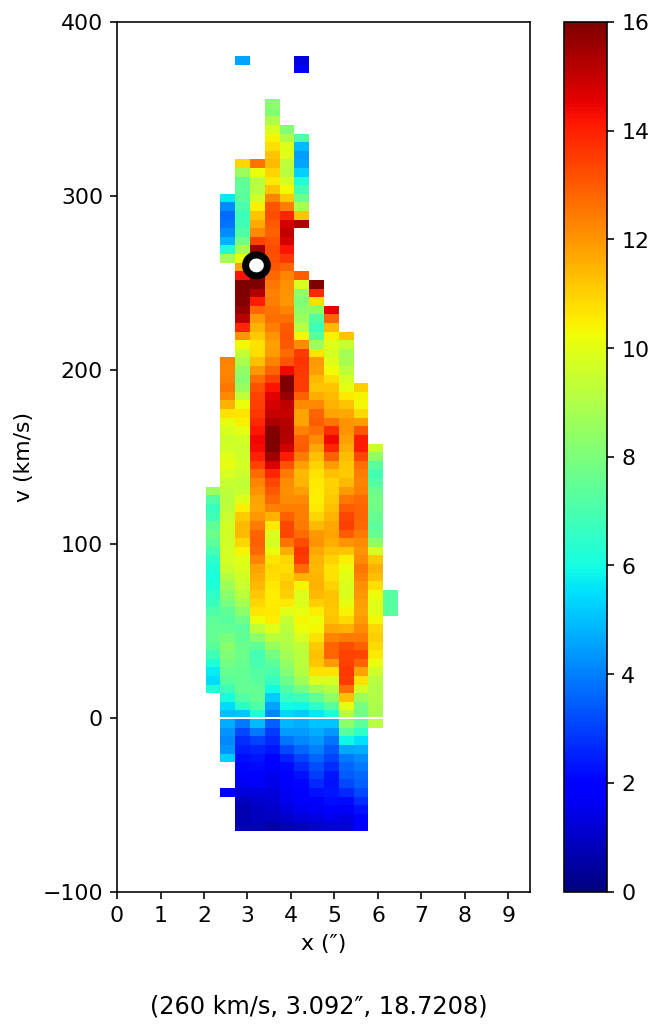

In [49]:
minpix = 0
maxpix = 180
tick = (-100, 500, 100)
m_s5007c = remove_noise(m_s5007, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)

minpix = 2
maxpix = 19
tick = (-100, 500, 100)
m_oiii2c = remove_noise(m_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick, 3)


s5007_oiii2c = m_s5007c / m_oiii2c

plot_hist(s5007_oiii2c[s5007_oiii2c == s5007_oiii2c], [0, 25])
plt.show() 

minpix = 0
maxpix = 16
tick = (-100, 500, 100)
plot_new_vx_slice(s5007_oiii2c, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

find_max_flux(m_vvals, s5007_oiii2c, minpix, maxpix, tick, True)

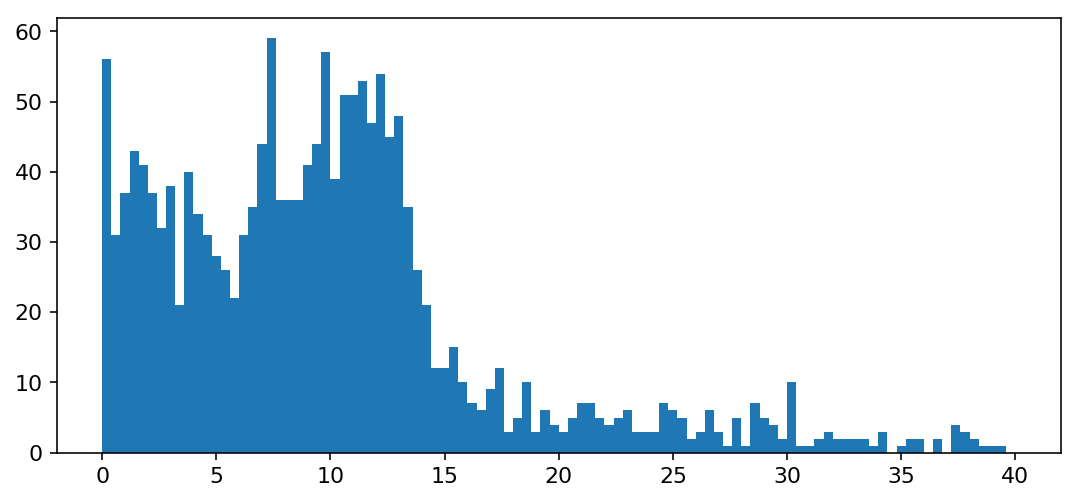

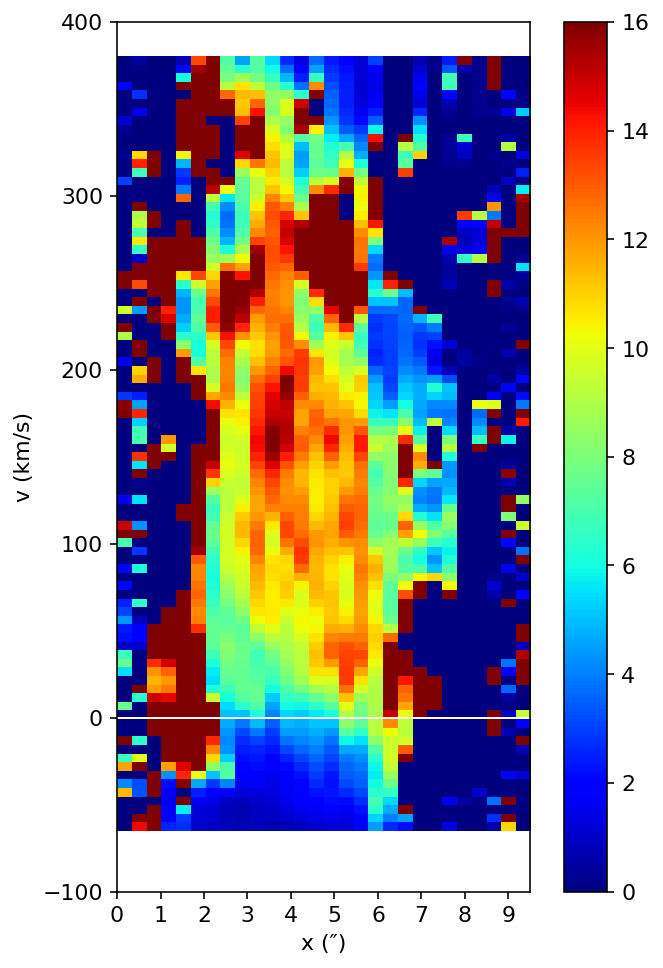

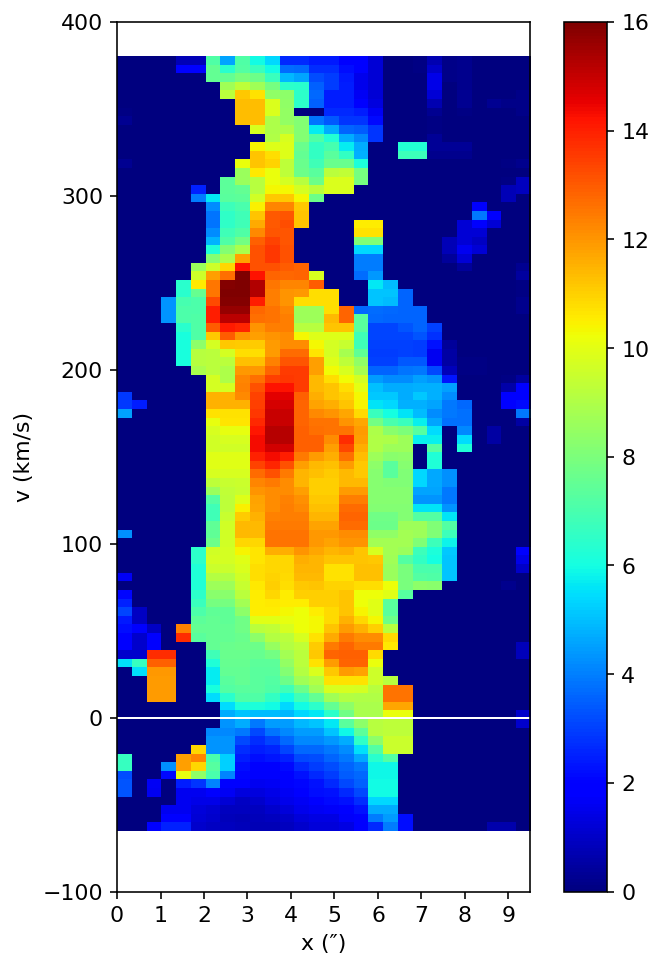

In [50]:
minpix = 0
maxpix = 16
tick = (-100, 500, 100)

s5007_oiii2 = m_s5007 / m_oiii2

plot_hist(s5007_oiii2[s5007_oiii2 == s5007_oiii2], [0, 40])
plt.show() 
        
plot_new_vx_slice(s5007_oiii2, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()

for i in range(len(s5007_oiii2)):
    for j in range(len(s5007_oiii2[0])):
        if s5007_oiii2c[i][j] != s5007_oiii2c[i][j]:
            if  s5007_oiii2[i][j] > 19:
                s5007_oiii2[i][j] = 0
                
s5007_oiii2_med = ndimage.median_filter(s5007_oiii2, 3)
plot_new_vx_slice(s5007_oiii2_med, m_vvals[0], m_vvals[-1], minpix, maxpix, tick)
plt.show()